# S&P500

In [19]:
# Important libraries
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
import sklearn
from sklearn.metrics import auc
from matplotlib.gridspec import SubplotSpec
import joblib
import seaborn as sns
# import gpflow

# KNN
from scipy.spatial import KDTree

# Cond Gaussian
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.stats import pearsonr

# Weighted
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# import weightedcalcs as wc

# Gaussian Copula
from scipy import stats
from scipy.stats import norm, truncnorm

# BNN
import torchbnn as bnn
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
import random

# DER
# from lightning.pytorch import Trainer, seed_everything
# from lightning import LightningDataModule
# from lightning.pytorch.callbacks import EarlyStopping
# from torch_uncertainty.models.mlp import mlp
# from torch_uncertainty.losses import DERLoss
# from torch_uncertainty.routines import RegressionRoutine
# from torch_uncertainty.layers.distributions import NormalInverseGammaLayer

import contextlib

data_label = "snp500"
seed = 2023

# File paths
fp_notebooks_folder = "./"
fp_code_folder = "../"
fp_processed_folder = os.path.join(fp_code_folder, "../processed_data")
fp_preprocessed_data_dict = os.path.join(fp_processed_folder, "snp500_data_dict.joblib")
fp_scaler = os.path.join(fp_processed_folder, "snp500_scaler.pkl")

fp_project_checkpoints = os.path.join(fp_code_folder, "checkpoints", data_label)
fp_tuning = os.path.join(fp_project_checkpoints, "tuning")
fp_project_models = os.path.join(fp_project_checkpoints, "models")
fp_project_predictions = os.path.join(fp_project_checkpoints, "predictions")
fp_project_pi_predictions = os.path.join(fp_project_checkpoints, "pi_predictions")
fp_project_model_evaluations = os.path.join(fp_project_checkpoints, "model_evaluation")
fp_project_consolidated_results = os.path.join(fp_project_checkpoints, "consolidated_results")
fp_time_log = os.path.join(fp_project_consolidated_results, "runtime.log")

def create_folder(fp):
    if not os.path.exists(fp):
        os.makedirs(fp)
        return True
    else:
        False

def create_all_seed_folders(cur_seed):
    fp_checkpoint_folders = [fp_project_models, fp_tuning, fp_project_predictions, fp_project_model_evaluations, fp_project_pi_predictions]
    for fp_folder in fp_checkpoint_folders:
        fp = os.path.join(fp_folder, str(cur_seed))
        create_folder(fp)
    print(f"All folders created for seed = {cur_seed}!")

batch_size = 64

feat_days = 5
ori_feat_cols = ["U$", "Mkt-RF", "SMB", "HML", "Mom"]
feat_cols = [f"{feat_col}_day{i}" for i in range(feat_days) for feat_col in ori_feat_cols]

# Create all folders
create_all_seed_folders(seed)
create_folder(fp_project_consolidated_results)

# Check GPU is available
# print(tf.config.list_physical_devices('GPU'))

# function to show df
def display_df(df):
    display(df.head())
    print("Shape:", df.shape)

All folders created for seed = 2023!


## Load Data

In [2]:
def display_data_dict(data_dict):
    len_df, time_labels = [], []
    splits = ["train_df", "valid_df", "test_df", "outputs"]
    for time_label, time_info_dict in data_dict.items():
        print(time_label)
        stat_dict = {}
        for split_df_name in splits:
            print(f"- {split_df_name}:")
            split_df = time_info_dict[split_df_name]
            if split_df_name == "outputs":
                stat_dict["pred_col"] = split_df[0]
                continue
            display(split_df.head())
            stat_dict[split_df_name] = len(split_df)
        len_df.append(stat_dict)
        time_labels.append(time_label)
    len_df = pd.DataFrame(len_df, index=time_labels)
    display(len_df)
    
data_dict = joblib.load(fp_preprocessed_data_dict)
display_data_dict(data_dict)

t+1
- train_df:


input_start date input end date target_date_t+1  input start index  \
0       1964-01-02     1964-01-08      1964-01-09                  0   
1       1964-01-03     1964-01-09      1964-01-10                  1   
2       1964-01-06     1964-01-10      1964-01-13                  2   
3       1964-01-07     1964-01-13      1964-01-14                  3   
4       1964-01-08     1964-01-14      1964-01-15                  4   

   input end index  target_index_t+1   U$_day0  Mkt-RF_day0  SMB_day0  \
0                4                 5 -0.770049     0.636563  1.183738   
1                5                 6 -0.769873     0.163873  0.240015   
2                6                 7 -0.769444     0.229830  0.200693   
3                7                 8 -0.769394     0.020966  0.141710   
4                8                 9 -0.768612     0.350750  0.102388   

   HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
0  1.227446  ...  0.141710  1.608279 -0.732825 -0.768612     0.350750   
1  0.734603  ...  0.102388 -0.363093 -0.063602 -0.767906     0.306779   
2 -0.004662  ...  0.063066 -0.833534  0.421585 -0.768007    -0.066976   
3  1.608279  ... -0.113882 -0.340691 -0.080333 -0.768058    -0.132933   
4 -0.363093  ... -0.035238  0.936220  0.036782 -0.767705     0.141887   

   SMB_day4  HML_day4  Mom_day4    U$_t+1  recession_t+1  
0  0.102388 -0.363093 -0.063602 -0.767906          False  
1  0.063066 -0.833534  0.421585 -0.768007          False  
2 -0.113882 -0.340691 -0.080333 -0.768058          False  
3 -0.035238  0.936220  0.036782 -0.767705          False  
4 -0.703709  1.406662  0.739466 -0.766999          False  

[5 rows x 33 columns]

- valid_df:


input_start date input end date target_date_t+1  input start index  \
10274       2004-10-25     2004-10-29      2004-11-01              10274   
10275       2004-10-26     2004-11-01      2004-11-02              10275   
10276       2004-10-27     2004-11-02      2004-11-03              10276   
10277       2004-10-28     2004-11-03      2004-11-04              10277   
10278       2004-10-29     2004-11-04      2004-11-05              10278   

       input end index  target_index_t+1   U$_day0  Mkt-RF_day0  SMB_day0  \
10274            10278             10279  1.799705    -0.055983  1.203399   
10275            10279             10280  1.840746     1.472015 -1.313197   
10276            10280             10281  1.876820     1.504994  0.770859   
10277            10281             10282  1.881962     0.119902 -0.644726   
10278            10282             10283  1.888920     0.174866 -1.116588   

       HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
10274  1.115436  ... -0.644726 -0.251083 -1.803583  1.888920     0.174866   
10275  1.541073  ... -1.116588  0.532985  0.354663  1.889701     0.042952   
10276 -2.513681  ...  0.810181 -0.183877 -0.264369  1.889777    -0.033998   
10277 -0.251083  ... -0.330152 -0.071868 -1.100898  1.921692     1.263152   
10278  0.532985  ...  0.869164 -0.183877  1.241384  1.968253     1.636907   

       SMB_day4  HML_day4  Mom_day4    U$_t+1  recession_t+1  
10274 -1.116588  0.532985  0.354663  1.889701          False  
10275  0.810181 -0.183877 -0.264369  1.889777          False  
10276 -0.330152 -0.071868 -1.100898  1.921692          False  
10277  0.869164 -0.183877  1.241384  1.968253          False  
10278 -1.313197  0.510583  0.337932  1.979597          False  

[5 rows x 33 columns]

- test_df:


input_start date input end date target_date_t+1  input start index  \
11742       2010-08-24     2010-08-30      2010-08-31              11742   
11743       2010-08-25     2010-08-31      2010-09-01              11743   
11744       2010-08-26     2010-09-01      2010-09-02              11744   
11745       2010-08-27     2010-09-02      2010-09-03              11745   
11746       2010-08-30     2010-09-03      2010-09-07              11746   

       input end index  target_index_t+1   U$_day0  Mkt-RF_day0  SMB_day0  \
11742            11746             11747  1.691458    -1.649939  0.259675   
11743            11747             11748  1.700180     0.471671  2.068479   
11744            11748             11749  1.679736    -0.858457 -0.153204   
11745            11749             11750  1.723524     1.977684  1.832548   
11746            11750             11751  1.684021    -1.715895 -1.667093   

       HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
11742  0.286564  ...  1.832548  0.779407  0.739466  1.684021    -1.715895   
11743 -0.049466  ... -1.667093 -0.990348 -0.180716  1.685055    -0.012012   
11744 -0.587113  ... -0.546422  1.765093  0.706005  1.763102     3.329798   
11745  0.779407  ...  1.203399  1.003426  0.856580  1.787832     1.043296   
11746 -0.990348  ...  0.495606 -0.855936  0.421585  1.824158     1.461023   

       SMB_day4  HML_day4  Mom_day4    U$_t+1  recession_t+1  
11742 -1.667093 -0.990348 -0.180716  1.685055          False  
11743 -0.546422  1.765093  0.706005  1.763102          False  
11744  1.203399  1.003426  0.856580  1.787832          False  
11745  0.495606 -0.855936  0.421585  1.824158          False  
11746  0.652894  0.443377  0.170626  1.792218          False  

[5 rows x 33 columns]

- outputs:
t+2
- train_df:


input_start date input end date target_date_t+2  input start index  \
0       1964-01-02     1964-01-08      1964-01-10                  0   
1       1964-01-03     1964-01-09      1964-01-13                  1   
2       1964-01-06     1964-01-10      1964-01-14                  2   
3       1964-01-07     1964-01-13      1964-01-15                  3   
4       1964-01-08     1964-01-14      1964-01-16                  4   

   input end index  target_index_t+2   U$_day0  Mkt-RF_day0  SMB_day0  \
0                4                 6 -0.770049     0.636563  1.183738   
1                5                 7 -0.769873     0.163873  0.240015   
2                6                 8 -0.769444     0.229830  0.200693   
3                7                 9 -0.769394     0.020966  0.141710   
4                8                10 -0.768612     0.350750  0.102388   

   HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
0  1.227446  ...  0.141710  1.608279 -0.732825 -0.768612     0.350750   
1  0.734603  ...  0.102388 -0.363093 -0.063602 -0.767906     0.306779   
2 -0.004662  ...  0.063066 -0.833534  0.421585 -0.768007    -0.066976   
3  1.608279  ... -0.113882 -0.340691 -0.080333 -0.768058    -0.132933   
4 -0.363093  ... -0.035238  0.936220  0.036782 -0.767705     0.141887   

   SMB_day4  HML_day4  Mom_day4    U$_t+2  recession_t+2  
0  0.102388 -0.363093 -0.063602 -0.768007          False  
1  0.063066 -0.833534  0.421585 -0.768058          False  
2 -0.113882 -0.340691 -0.080333 -0.767705          False  
3 -0.035238  0.936220  0.036782 -0.766999          False  
4 -0.703709  1.406662  0.739466 -0.767226          False  

[5 rows x 33 columns]

- valid_df:


input_start date input end date target_date_t+2  input start index  \
10273       2004-10-22     2004-10-28      2004-11-01              10273   
10274       2004-10-25     2004-10-29      2004-11-02              10274   
10275       2004-10-26     2004-11-01      2004-11-03              10275   
10276       2004-10-27     2004-11-02      2004-11-04              10276   
10277       2004-10-28     2004-11-03      2004-11-05              10277   

       input end index  target_index_t+2   U$_day0  Mkt-RF_day0  SMB_day0  \
10273            10277             10279  1.802050    -1.122284 -1.293536   
10274            10278             10280  1.799705    -0.055983  1.203399   
10275            10279             10281  1.840746     1.472015 -1.313197   
10276            10280             10282  1.876820     1.504994  0.770859   
10277            10281             10283  1.881962     0.119902 -0.644726   

       HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
10273  1.496269  ...  0.770859 -2.513681 -2.573190  1.881962     0.119902   
10274  1.115436  ... -0.644726 -0.251083 -1.803583  1.888920     0.174866   
10275  1.541073  ... -1.116588  0.532985  0.354663  1.889701     0.042952   
10276 -2.513681  ...  0.810181 -0.183877 -0.264369  1.889777    -0.033998   
10277 -0.251083  ... -0.330152 -0.071868 -1.100898  1.921692     1.263152   

       SMB_day4  HML_day4  Mom_day4    U$_t+2  recession_t+2  
10273 -0.644726 -0.251083 -1.803583  1.889701          False  
10274 -1.116588  0.532985  0.354663  1.889777          False  
10275  0.810181 -0.183877 -0.264369  1.921692          False  
10276 -0.330152 -0.071868 -1.100898  1.968253          False  
10277  0.869164 -0.183877  1.241384  1.979597          False  

[5 rows x 33 columns]

- test_df:


input_start date input end date target_date_t+2  input start index  \
11741       2010-08-23     2010-08-27      2010-08-31              11741   
11742       2010-08-24     2010-08-30      2010-09-01              11742   
11743       2010-08-25     2010-08-31      2010-09-02              11743   
11744       2010-08-26     2010-09-01      2010-09-03              11744   
11745       2010-08-27     2010-09-02      2010-09-07              11745   

       input end index  target_index_t+2   U$_day0  Mkt-RF_day0  SMB_day0  \
11741            11745             11747  1.730507    -0.572645 -1.863702   
11742            11746             11748  1.691458    -1.649939  0.259675   
11743            11747             11749  1.700180     0.471671  2.068479   
11744            11748             11750  1.679736    -0.858457 -0.153204   
11745            11749             11751  1.723524     1.977684  1.832548   

       HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
11741 -0.945544  ... -0.153204 -0.587113  0.555430  1.723524     1.977684   
11742  0.286564  ...  1.832548  0.779407  0.739466  1.684021    -1.715895   
11743 -0.049466  ... -1.667093 -0.990348 -0.180716  1.685055    -0.012012   
11744 -0.587113  ... -0.546422  1.765093  0.706005  1.763102     3.329798   
11745  0.779407  ...  1.203399  1.003426  0.856580  1.787832     1.043296   

       SMB_day4  HML_day4  Mom_day4    U$_t+2  recession_t+2  
11741  1.832548  0.779407  0.739466  1.685055          False  
11742 -1.667093 -0.990348 -0.180716  1.763102          False  
11743 -0.546422  1.765093  0.706005  1.787832          False  
11744  1.203399  1.003426  0.856580  1.824158          False  
11745  0.495606 -0.855936  0.421585  1.792218          False  

[5 rows x 33 columns]

- outputs:
t+3
- train_df:


input_start date input end date target_date_t+3  input start index  \
0       1964-01-02     1964-01-08      1964-01-13                  0   
1       1964-01-03     1964-01-09      1964-01-14                  1   
2       1964-01-06     1964-01-10      1964-01-15                  2   
3       1964-01-07     1964-01-13      1964-01-16                  3   
4       1964-01-08     1964-01-14      1964-01-17                  4   

   input end index  target_index_t+3   U$_day0  Mkt-RF_day0  SMB_day0  \
0                4                 7 -0.770049     0.636563  1.183738   
1                5                 8 -0.769873     0.163873  0.240015   
2                6                 9 -0.769444     0.229830  0.200693   
3                7                10 -0.769394     0.020966  0.141710   
4                8                11 -0.768612     0.350750  0.102388   

   HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
0  1.227446  ...  0.141710  1.608279 -0.732825 -0.768612     0.350750   
1  0.734603  ...  0.102388 -0.363093 -0.063602 -0.767906     0.306779   
2 -0.004662  ...  0.063066 -0.833534  0.421585 -0.768007    -0.066976   
3  1.608279  ... -0.113882 -0.340691 -0.080333 -0.768058    -0.132933   
4 -0.363093  ... -0.035238  0.936220  0.036782 -0.767705     0.141887   

   SMB_day4  HML_day4  Mom_day4    U$_t+3  recession_t+3  
0  0.102388 -0.363093 -0.063602 -0.768058          False  
1  0.063066 -0.833534  0.421585 -0.767705          False  
2 -0.113882 -0.340691 -0.080333 -0.766999          False  
3 -0.035238  0.936220  0.036782 -0.767226          False  
4 -0.703709  1.406662  0.739466 -0.767200          False  

[5 rows x 33 columns]

- valid_df:


input_start date input end date target_date_t+3  input start index  \
10272       2004-10-21     2004-10-27      2004-11-01              10272   
10273       2004-10-22     2004-10-28      2004-11-02              10273   
10274       2004-10-25     2004-10-29      2004-11-03              10274   
10275       2004-10-26     2004-11-01      2004-11-04              10275   
10276       2004-10-27     2004-11-02      2004-11-05              10276   

       input end index  target_index_t+3   U$_day0  Mkt-RF_day0  SMB_day0  \
10272            10276             10279  1.829149     0.383729  1.341025   
10273            10277             10280  1.802050    -1.122284 -1.293536   
10274            10278             10281  1.799705    -0.055983  1.203399   
10275            10279             10282  1.840746     1.472015 -1.313197   
10276            10280             10283  1.876820     1.504994  0.770859   

       HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
10272  0.084946  ... -1.313197  1.541073  0.220818  1.876820     1.504994   
10273  1.496269  ...  0.770859 -2.513681 -2.573190  1.881962     0.119902   
10274  1.115436  ... -0.644726 -0.251083 -1.803583  1.888920     0.174866   
10275  1.541073  ... -1.116588  0.532985  0.354663  1.889701     0.042952   
10276 -2.513681  ...  0.810181 -0.183877 -0.264369  1.889777    -0.033998   

       SMB_day4  HML_day4  Mom_day4    U$_t+3  recession_t+3  
10272  0.770859 -2.513681 -2.573190  1.889701          False  
10273 -0.644726 -0.251083 -1.803583  1.889777          False  
10274 -1.116588  0.532985  0.354663  1.921692          False  
10275  0.810181 -0.183877 -0.264369  1.968253          False  
10276 -0.330152 -0.071868 -1.100898  1.979597          False  

[5 rows x 33 columns]

- test_df:


input_start date input end date target_date_t+3  input start index  \
11740       2010-08-20     2010-08-26      2010-08-31              11740   
11741       2010-08-23     2010-08-27      2010-09-01              11741   
11742       2010-08-24     2010-08-30      2010-09-02              11742   
11743       2010-08-25     2010-08-31      2010-09-03              11743   
11744       2010-08-26     2010-09-01      2010-09-07              11744   

       input end index  target_index_t+3   U$_day0  Mkt-RF_day0  SMB_day0  \
11740            11744             11747  1.741422    -0.330803  0.534928   
11741            11745             11748  1.730507    -0.572645 -1.863702   
11742            11746             11749  1.691458    -1.649939  0.259675   
11743            11747             11750  1.700180     0.471671  2.068479   
11744            11748             11751  1.679736    -0.858457 -0.153204   

       HML_day0  ...  SMB_day3  HML_day3  Mom_day3   U$_day4  Mkt-RF_day4  \
11740 -0.564711  ...  2.068479 -0.049466  0.003320  1.679736    -0.858457   
11741 -0.945544  ... -0.153204 -0.587113  0.555430  1.723524     1.977684   
11742  0.286564  ...  1.832548  0.779407  0.739466  1.684021    -1.715895   
11743 -0.049466  ... -1.667093 -0.990348 -0.180716  1.685055    -0.012012   
11744 -0.587113  ... -0.546422  1.765093  0.706005  1.763102     3.329798   

       SMB_day4  HML_day4  Mom_day4    U$_t+3  recession_t+3  
11740 -0.153204 -0.587113  0.555430  1.685055          False  
11741  1.832548  0.779407  0.739466  1.763102          False  
11742 -1.667093 -0.990348 -0.180716  1.787832          False  
11743 -0.546422  1.765093  0.706005  1.824158          False  
11744  1.203399  1.003426  0.856580  1.792218          False  

[5 rows x 33 columns]

- outputs:


train_df  valid_df  test_df pred_col
t+1     10274      1468     2935   U$_t+1
t+2     10273      1468     2936   U$_t+2
t+3     10272      1468     2937   U$_t+3

In [3]:
print("Feature Columns:", feat_cols)

Feature Columns: ['U$_day0', 'Mkt-RF_day0', 'SMB_day0', 'HML_day0', 'Mom_day0', 'U$_day1', 'Mkt-RF_day1', 'SMB_day1', 'HML_day1', 'Mom_day1', 'U$_day2', 'Mkt-RF_day2', 'SMB_day2', 'HML_day2', 'Mom_day2', 'U$_day3', 'Mkt-RF_day3', 'SMB_day3', 'HML_day3', 'Mom_day3', 'U$_day4', 'Mkt-RF_day4', 'SMB_day4', 'HML_day4', 'Mom_day4']


## Timer Function

In [47]:
class Timer:
    def __init__(self, seed):
        self.seed = seed

    def restart_timer(self):
        self.description = None
        self.start_time = None
        self.end_time = None
        self.duration = None
        
    def start(self, description):
        self.restart_timer()
        self.description = description
        self.start_time = time.time()

    def end(self):
        self.end_time = time.time()
        self.duration = self.end_time-self.start_time
        print(f"{self.description} took {self.duration}s. ")
        self._log_time()

    def _log_time(self):
        with open(fp_time_log, "a+") as myfile:
            myfile.write(f"{self.seed},{self.description},{self.duration}\n")

## RUE

In [163]:
def set_seed(seed):
    tf.config.experimental.enable_op_determinism()
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def display_history(history, show_acc=False):
    if show_acc:
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5))
        axes[0].plot(history.history['loss'])
        axes[0].plot(history.history['val_loss'])
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Val'], loc='upper left')
        axes[1].plot(history.history['accuracy'])
        axes[1].plot(history.history['val_accuracy'])
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='upper left')
        axes[2].plot(history.history['f1_score'])
        axes[2].plot(history.history['val_f1_score'])
        axes[2].set_title('Model F1 Score')
        axes[2].set_ylabel('F1 Score')
        axes[2].set_xlabel('Epoch')
        axes[2].legend(['Train', 'Val'], loc='upper left')
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
        axes.plot(history.history['loss'])
        axes.plot(history.history['val_loss'])
        axes.set_title('Model Loss')
        axes.set_ylabel('Loss')
        axes.set_xlabel('Epoch')
        axes.legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()
    plt.show()

from keras import regularizers

class AE_Regressor:
    def __init__(self, encoder_width, encoder_depth, decoder_width, decoder_depth, predictors, output_features):
        from keras.layers import Dense, Dropout
        self.predictors = predictors
        self.output_features = output_features
        self.num_predictors = len(self.predictors)
        self.num_outputs = len(self.output_features)
        self.encoder_width = encoder_width
        self.encoder_depth = encoder_depth
        self.decoder_width = decoder_width
        self.decoder_depth = decoder_depth
        
        # Instantiate model layers
        self.inputs = tf.keras.Input(shape=(self.num_predictors,))
        self.encoder = tf.keras.Sequential(list(
            Dense(self.encoder_width, "relu") for i in range(self.encoder_depth) # , kernel_regularizer="l2"
        ), name="encoder")
        self.decoder = tf.keras.Sequential([
            Dense(self.decoder_width, "relu", kernel_regularizer="l1") for i in range(self.decoder_depth-1) # , kernel_regularizer="l2", tf.keras.regularizers.L2(l2=0.1)
        ]+[Dense(self.num_predictors)], name="decoder")
        self.regressor = tf.keras.Sequential([
            Dropout(rate=0.2),
            Dense(self.num_outputs)
        ], name="regressor")
    
    # Smote is external
    def train_regressor(
        self, train_X, train_y, val_X, val_y, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Define regressor
        pred = self.encoder(self.inputs)
        pred = self.regressor(pred)
        self.predictor = tf.keras.Model(inputs=self.inputs, outputs=pred, name="regression_model")
        # Train predictor
        self.predictor.compile(
            loss="mse",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)
        self.predictor_history = self.predictor.fit(
            train_X, train_y, 
            epochs=max_epochs, 
            validation_data=(val_X, val_y),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es],
        )
        print("- Regressor Training History")
        display_history(self.predictor_history)
        best_index = np.argmin(self.predictor_history.history['val_loss'])
        return (
            self.predictor_history.history['val_loss'][best_index], 
            best_index
        )
        
    def train_decoder(
        self, train_X, val_X, batch_size, max_epochs, verbose, patience):
        from tensorflow.keras.callbacks import EarlyStopping
        # Define AE
        self.encoder.trainable=False # Freeze weights
        x = self.encoder(self.inputs)
        x = self.decoder(x)
        self.ae = tf.keras.Model(inputs=self.inputs, outputs=x, name="ae_model")
        # Train AE
        self.ae.compile(
            loss="mae",
            optimizer=tf.keras.optimizers.Adam()
        )
        es = EarlyStopping(
            monitor='val_loss', mode='min', verbose=1, patience=patience, restore_best_weights=True)
        self.ae_history = self.ae.fit(
            train_X, train_X, 
            epochs=max_epochs, 
            validation_data=(val_X, val_X),
            verbose=verbose,
            batch_size=batch_size,
            callbacks=[es]
        )
        print("- Autoencoder Training History")
        display_history(self.ae_history)
        best_epoch = np.argmin(self.ae_history.history['val_loss'])
        return self.ae_history.history['val_loss'][best_epoch], best_epoch

    def replace_encoder_predictor(self, prev_model):
        self.encoder = prev_model.encoder
        self.regressor = prev_model.regressor
        self.encoder_width = prev_model.encoder_width
        self.encoder_depth = prev_model.encoder_depth

    def predict(self, inputs, with_mae=True, weighted=False, dropout_activated=False):
        # Encode
        encoder_output = self.encoder(inputs)
        
        # Get forecast result
        regressor_output = self.regressor(encoder_output, training=dropout_activated)
        if with_mae:
            # Reconstruct
            decoder_output = self.decoder(encoder_output)
            return regressor_output, decoder_output
        else:
            return regressor_output

    def get_config(self):
        return dict(
            encoder_width=self.encoder_width, 
            encoder_depth=self.encoder_depth, 
            decoder_width=self.decoder_width, 
            decoder_depth=self.decoder_depth, 
            predictors=self.predictors, 
            output_features=self.output_features
        )
        
def save_model(model, name, fp_checkpoints, override=False):
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    if os.path.exists(model_folder):
        print("Model checkpoint already exists!")
        if not override:
            return
    else:
        os.makedirs(model_folder)
    
    # Save Parameters
    parameters_to_save = model.get_config()
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    with open(parameter_filename, 'wb') as handle:
        pickle.dump(parameters_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save Model
    inputs = model.inputs
    encoder_output = model.encoder(inputs)
    decoder_output = model.decoder(encoder_output)
    regressor_output = model.regressor(encoder_output)
    model = tf.keras.Model(inputs, [regressor_output, decoder_output])
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    model.save(model_filename)
    print("Model saved!")

def load_model(name, fp_checkpoints): 
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    parameter_filename = os.path.join(fp_checkpoints, name, "parameters.pickle")
    model_filename = os.path.join(fp_checkpoints, name, "model.h5")
    
    if not os.path.exists(model_folder):
        print("model checkpoint does not exist!")
        return
    model = tf.keras.models.load_model(model_filename)
    with open(parameter_filename, 'rb') as handle:
        parameters = pickle.load(handle)
    
    ae_regressor = AE_Regressor(**parameters)
    ae_regressor.encoder = model.get_layer("encoder")
    ae_regressor.decoder = model.get_layer("decoder")
    ae_regressor.regressor = model.get_layer("regressor")
    
    return ae_regressor

def model_tuning_regressor(
    param_grid, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    loss_list = []
    epoch_list = []
    time_spent_list = []
    tuning_df_list = []
    parameter_list = list(ParameterGrid(param_grid))
    pbar = tqdm(parameter_list)
    for param_dict in pbar:
        pbar.set_description(f"{param_dict}")
        set_seed(seed)
        regressor = AE_Regressor(**param_dict, predictors=predictors, output_features=pred_cols)
        start = time.time()
        val_loss, best_epoch = regressor.train_regressor(
            train_X, train_y, valid_X, valid_y, batch_size, max_epochs, verbose, patience)
        cur_param_dict = param_dict.copy()
        cur_param_dict["loss"] = val_loss
        cur_param_dict["epochs"] = best_epoch
        cur_param_dict["time/s"] = time.time()-start
        tuning_df_list.append(cur_param_dict)
    tuning_df = pd.DataFrame(tuning_df_list)
    best_param_idx = tuning_df['loss'].idxmin()
    tuning_df["best_hyperparameter"] = [True if i==best_param_idx else False for i in range(len(tuning_df))]
    best_param = parameter_list[best_param_idx]
    return tuning_df, best_param

def get_model_error_corr(predictor, x, y):
    y_pred, x_pred = predictor.predict(x)
    rue = np.mean(np.abs(x-x_pred), axis=-1)
    mae = np.mean(np.abs(y-y_pred), axis=-1)
    corr, pvalue = pearsonr(mae, rue)
    return corr

def model_tuning_decoder(
    param_grid, predictors, pred_cols, train_df, valid_df, seed, prev_model,
    atch_size=128, max_epochs=5000, verbose=1, patience=10):
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    tuning_df_list = []
    parameter_list = list(ParameterGrid(param_grid))
    best_corr = -np.inf
    pbar = tqdm(parameter_list)
    for param_dict in pbar:
        pbar.set_description(f"{param_dict}, best corr: {best_corr:.5f}")
        set_seed(seed)
        predictor = AE_Regressor(**param_dict, predictors=predictors, output_features=pred_cols)
        predictor.replace_encoder_predictor(prev_model)
        start = time.time()
        val_loss, best_epoch = predictor.train_decoder(
            train_X, valid_X, batch_size, max_epochs, verbose, patience)
        timing = time.time()-start
        corr = get_model_error_corr(predictor, valid_X, valid_y)
        cur_param_dict = param_dict.copy()
        cur_param_dict["loss"] = val_loss
        cur_param_dict["corr"] = corr
        cur_param_dict["epochs"] = best_epoch
        cur_param_dict["time/s"] = timing
        tuning_df_list.append(cur_param_dict)
        best_corr = max(corr, best_corr)
    tuning_df = pd.DataFrame(tuning_df_list)
    best_param_idx = tuning_df["corr"].idxmax()
    tuning_df["best_hyperparameter"] = [True if i==best_param_idx else False for i in range(len(tuning_df))]
    best_param = parameter_list[best_param_idx]
    return tuning_df, best_param

def model_training(
    hp_dict, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    set_seed(seed)
    timer = Timer(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    ae_regressor = AE_Regressor(**hp_dict, predictors=predictors, output_features=pred_cols)
    timer.start(description="Training Encoder and Predictor")
    valid_loss_regressor, best_epoch = ae_regressor.train_regressor(
        train_X, train_y, valid_X, valid_y, 
        batch_size, max_epochs, verbose, patience)
    timer.end()
    
    # Train decoder
    timer.start(description="Training Decoder")
    valid_loss_ae = ae_regressor.train_decoder(
        train_X, valid_X, batch_size, max_epochs, verbose, patience)
    timer.end()
    return ae_regressor

def model_training_predictor(
    hp_dict, predictors, pred_cols, train_df, valid_df, seed,
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    
    from tqdm import tqdm
    import time
    set_seed(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    ae_regressor = AE_Regressor(**hp_dict, predictors=predictors, output_features=pred_cols)
    
    start = time.time()
    # Train classifier
    valid_loss_regressor, best_epoch = ae_regressor.train_regressor(
        train_X, train_y, valid_X, valid_y, 
        batch_size, max_epochs, verbose, patience)
    
    # Train decoder
    # valid_loss_ae = ae_regressor.train_decoder(
    #     train_X, valid_X, batch_size, max_epochs, verbose, patience)
    
    print(f"Training took {time.time()-start}s.")
    return ae_regressor

def model_training_decoder(
    hp_dict, predictors, pred_cols, train_df, valid_df, seed, prev_model, 
    batch_size=128, max_epochs=5000, verbose=1, patience=10):
    
    from tqdm import tqdm
    import time
    set_seed(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float32'), train_df[pred_cols].values.astype('float32'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float32'), valid_df[pred_cols].values.astype('float32'))
    
    # Train Regressor
    ae_regressor = AE_Regressor(**hp_dict, predictors=predictors, output_features=pred_cols)
    ae_regressor.replace_encoder_predictor(prev_model)
    
    start = time.time()
    # Train classifier
    # valid_loss_regressor, best_epoch = ae_regressor.train_regressor(
    #     train_X, train_y, valid_X, valid_y, 
    #     batch_size, max_epochs, verbose, patience)
    
    # Train decoder
    valid_loss_ae = ae_regressor.train_decoder(
        train_X, valid_X, batch_size, max_epochs, verbose, patience)
    
    print(f"Training took {time.time()-start}s.")
    return ae_regressor

def model_test_predictions(
    ae_regressor, df_train, df_test, pred_cols, predictors, regressor_label, pred_min, T=10, seed=seed):
    df_test = df_test.copy()
    set_seed(seed)
    timer = Timer(seed)
    test_X, test_y = (
        df_test[predictors].values.astype('float32'), df_test[pred_cols].values.astype('float32'))
    
    # MAE
    timer.start(description="Predicting with Decoder + Predictor")
    test_y_pred, test_X_reconstruction = ae_regressor.predict(inputs=test_X)
    timer.end()
    # - Add to df
    predicted_colnames = [col+"_direct"+regressor_label for col in pred_cols]
    reconstruction_colnames = [col+"_reconstruction"+regressor_label for col in predictors]
    rue_colname = "rue"
    df_test[predicted_colnames] = test_y_pred
    df_test[reconstruction_colnames] = test_X_reconstruction
    df_test[rue_colname] = np.mean(np.abs(test_X_reconstruction-test_X), axis=1)
    
    # For MC Dropout
    # - Sample with dropout
    timer.start(description="Predicting with MC Dropout")
    test_y_sample_preds = []
    for i in range(T):
        test_y_pred = ae_regressor.predict(inputs=test_X, dropout_activated=True, with_mae=False)
        test_y_sample_preds.append(test_y_pred)
    timer.end()
    test_y_sample_preds = np.array(test_y_sample_preds)
    test_y_sample_preds =  test_y_sample_preds.transpose((1, 2, 0))
    # - Get mean and std of all sample predictions
    test_y_mean_pred = np.mean(test_y_sample_preds, axis=-1)
    test_y_std_pred = np.std(test_y_sample_preds, axis=-1, ddof=1)

    # - Add to df
    predicted_mean_colnames = [col+"_mean"+regressor_label for col in pred_cols]
    predicted_std_colnames = [col+"_std"+regressor_label for col in pred_cols]
    mcd_colname = "mcd"
    df_test[predicted_mean_colnames] = test_y_mean_pred
    df_test[predicted_std_colnames] = test_y_std_pred
    df_test[mcd_colname] = np.mean(test_y_std_pred, axis=-1)
    
    return df_test

### Tune and Train Predictor

#### Tune Predictor

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000


I0000 00:00:1729657456.931017 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729657456.931326 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729657456.931581 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729657456.931837 2200513 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

110/161 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.3424 

2024-10-23 11:24:17.990232: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1729657458.083432 2206017 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2727 - val_loss: 0.0347
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.0369 - val_loss: 0.0187
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0257 - val_loss: 0.0140
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0184 - val_loss: 0.0132
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0138 - val_loss: 0.0068
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0104 - val_loss: 0.0063
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.0096 - val_loss: 0.0096
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0087 - val_loss: 0.0118
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0073 - val_loss: 0.0042
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0062 - val_loss: 0.0041
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0056 - val_loss: 0.0051
Epoch 12/1000

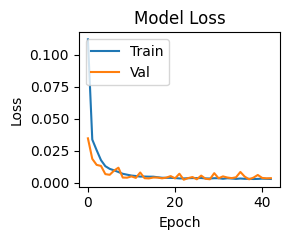

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2661 - val_loss: 0.0271
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0235 - val_loss: 0.0173
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0166 - val_loss: 0.0126
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.0119 - val_loss: 0.0131
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.0097 - val_loss: 0.0068
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0079 - val_loss: 0.0067
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.0060 - val_loss: 0.0058
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.0055 - val_loss: 0.0044
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0047 - val_loss: 0.0058
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 0.0044 - val_loss: 0.0044
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.0042 - val_loss: 0.0045

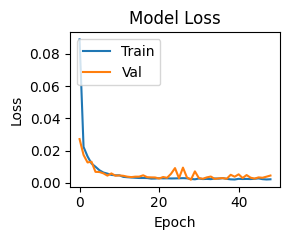

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1570 - val_loss: 0.0244
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0167 - val_loss: 0.0459
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0117 - val_loss: 0.0067
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 0.0059 - val_loss: 0.0062
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 0.0045 - val_loss: 0.0050
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.0043 - val_loss: 0.0063
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.0037 - val_loss: 0.0042
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 0.0025 - val_loss: 0.0077

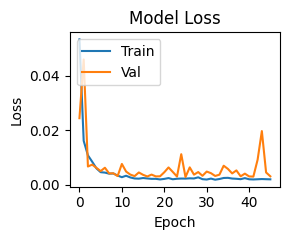

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1207 - val_loss: 0.0185
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0163 - val_loss: 0.0200
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.0132 - val_loss: 0.0117
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0101 - val_loss: 0.0179
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.0077 - val_loss: 0.0079
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0077 - val_loss: 0.0310
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0063 - val_loss: 0.0247
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.0059 - val_loss: 0.0126
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0055 - val_loss: 0.0076
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0056 - val_loss: 0.0060
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0050 - val_loss: 0.0057

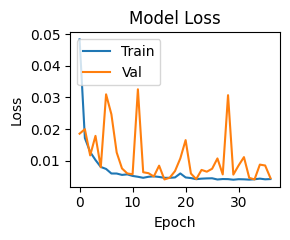

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0918 - val_loss: 0.0156
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0127 - val_loss: 0.0120
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0089 - val_loss: 0.0090
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.0076 - val_loss: 0.0162
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0068 - val_loss: 0.0073
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0060 - val_loss: 0.0053
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0050 - val_loss: 0.0076
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0049 - val_loss: 0.0067
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0039 - val_loss: 0.0051
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0031 - val_loss: 0.0041

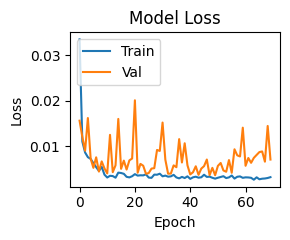

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1137 - val_loss: 0.0136
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0114 - val_loss: 0.0272
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0091 - val_loss: 0.0187
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0075 - val_loss: 0.0126
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0056 - val_loss: 0.0209
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0045 - val_loss: 0.0092
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0036 - val_loss: 0.0081
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.0033 - val_loss: 0.0048
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0033 - val_loss: 0.0057
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0034 - val_loss: 0.0150

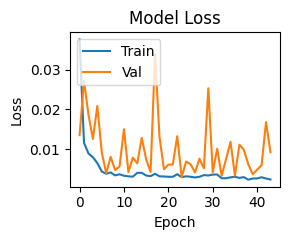

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1163 - val_loss: 0.0229
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0117 - val_loss: 0.0118
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0086 - val_loss: 0.0195
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0073 - val_loss: 0.0147
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0067 - val_loss: 0.0158
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0067 - val_loss: 0.0256
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.0061 - val_loss: 0.0132
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0057 - val_loss: 0.0070
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0052 - val_loss: 0.0128
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0056 - val_loss: 0.0156
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0049 - val_loss: 0.0085

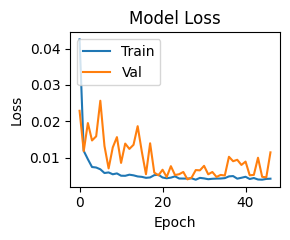

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0886 - val_loss: 0.0161
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0104 - val_loss: 0.0205
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0069 - val_loss: 0.0138
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.0049 - val_loss: 0.0096
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0045 - val_loss: 0.0151
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 0.0049 - val_loss: 0.0141
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0047 - val_loss: 0.0051
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.0041 - val_loss: 0.0058
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0041 - val_loss: 0.0064
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0045 - val_loss: 0.0137
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0038 - val_loss: 0.0069

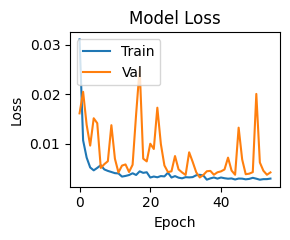

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1219 - val_loss: 0.0102
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0090 - val_loss: 0.0188
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.0060 - val_loss: 0.0247
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0041 - val_loss: 0.0072
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0048 - val_loss: 0.0232
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.0060 - val_loss: 0.0063
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0033 - val_loss: 0.0178
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0035 - val_loss: 0.0111
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0028 - val_loss: 0.0059
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0025 - val_loss: 0.0077

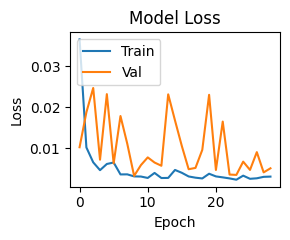

decoder_depth  decoder_width  encoder_depth  encoder_width      loss  \
0              2            128              1            256  0.002492   
1              2            128              1            512  0.001914   
2              2            128              1           1028  0.002853   
3              2            128              2            256  0.004083   
4              2            128              2            512  0.003654   
5              2            128              2           1028  0.003044   
6              2            128              3            256  0.003995   
7              2            128              3            512  0.003150   
8              2            128              3           1028  0.003220   

   epochs     time/s  best_hyperparameter  
0      22   7.249279                False  
1      28   7.873470                 True  
2      25   7.501477                False  
3      16   7.224357                False  
4      49  11.863265                False  
5      23   8.119690                False  
6      26   9.005495                False  
7      34  10.245044                False  
8       8   6.487299                False

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2836 - val_loss: 0.0300
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0380 - val_loss: 0.0225
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0259 - val_loss: 0.0158
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0211 - val_loss: 0.0126
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0149 - val_loss: 0.0093
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0121 - val_loss: 0.0076
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0095 - val_loss: 0.0073
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0089 - val_loss: 0.0068
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0074 - val_loss: 0.0052
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0069 - val_loss: 0.0065
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0065 - val_loss: 0.0052

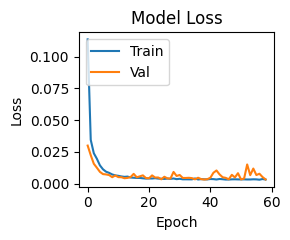

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2545 - val_loss: 0.0228
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0233 - val_loss: 0.0159
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0166 - val_loss: 0.0132
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0136 - val_loss: 0.0108
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.0104 - val_loss: 0.0091
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 0.0082 - val_loss: 0.0071
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 0.0080 - val_loss: 0.0055
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.0063 - val_loss: 0.0052
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.0042 - val_loss: 0.0053
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.0041 - val_loss: 0.0057

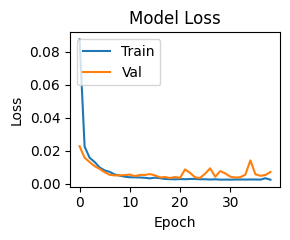

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1460 - val_loss: 0.0187
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.0164 - val_loss: 0.0230
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 0.0118 - val_loss: 0.0162
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.0087 - val_loss: 0.0074
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0073 - val_loss: 0.0061
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.0055 - val_loss: 0.0058
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.0037 - val_loss: 0.0048
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0035 - val_loss: 0.0048
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0034 - val_loss: 0.0054
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.0030 - val_loss: 0.0050

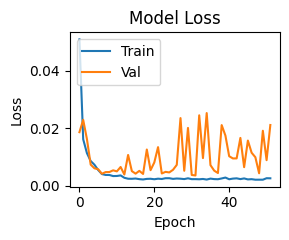

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1193 - val_loss: 0.0264
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0174 - val_loss: 0.0168
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0114 - val_loss: 0.0137
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0088 - val_loss: 0.0115
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0082 - val_loss: 0.0148
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.0078 - val_loss: 0.0089
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0074 - val_loss: 0.0107
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0065 - val_loss: 0.0397
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0064 - val_loss: 0.0095
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0054 - val_loss: 0.0082
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0051 - val_loss: 0.0173

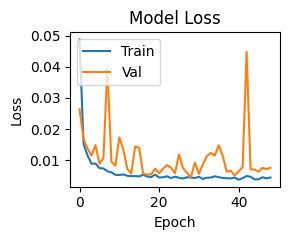

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0825 - val_loss: 0.0393
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0124 - val_loss: 0.0111
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0099 - val_loss: 0.0107
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0078 - val_loss: 0.0254
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0072 - val_loss: 0.0126
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.0056 - val_loss: 0.0084
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0047 - val_loss: 0.0115
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0047 - val_loss: 0.0075
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0048 - val_loss: 0.0061
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0044 - val_loss: 0.0231
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0044 - val_loss: 0.0077

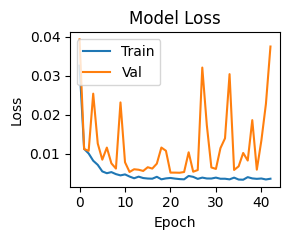

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0893 - val_loss: 0.0148
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.0110 - val_loss: 0.0153
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0076 - val_loss: 0.0100
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0060 - val_loss: 0.0067
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0057 - val_loss: 0.0068
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0049 - val_loss: 0.0089
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0044 - val_loss: 0.0250
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0051 - val_loss: 0.0046
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0042 - val_loss: 0.0070
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.0036 - val_loss: 0.0142
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0035 - val_loss: 0.0319

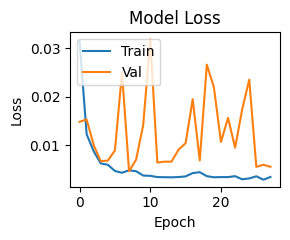

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1176 - val_loss: 0.0241
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0144 - val_loss: 0.0165
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0099 - val_loss: 0.0215
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.0085 - val_loss: 0.0151
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0075 - val_loss: 0.0141
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 0.0068 - val_loss: 0.0180
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0069 - val_loss: 0.0115
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0068 - val_loss: 0.0084
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.0061 - val_loss: 0.0339
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.0061 - val_loss: 0.0102
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.0060 - val_loss: 0.0085

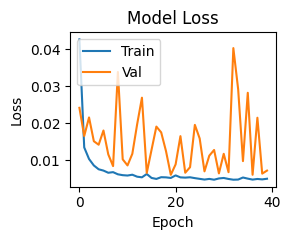

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0844 - val_loss: 0.0185
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0092 - val_loss: 0.0104
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0068 - val_loss: 0.0337
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.0072 - val_loss: 0.0122
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.0054 - val_loss: 0.0080
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0046 - val_loss: 0.0075
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0046 - val_loss: 0.0107
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.0042 - val_loss: 0.0090
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.0038 - val_loss: 0.0078
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0037 - val_loss: 0.0121
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.0036 - val_loss: 0.0074

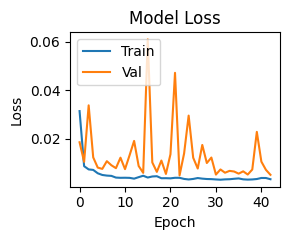

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1245 - val_loss: 0.0408
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.0078 - val_loss: 0.0072
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - loss: 0.0056 - val_loss: 0.0066
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.0048 - val_loss: 0.0210
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0051 - val_loss: 0.0074
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0040 - val_loss: 0.0165
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0034 - val_loss: 0.0102
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0043 - val_loss: 0.0150
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 0.0032 - val_loss: 0.0075
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0040 - val_loss: 0.0064
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 0.0037 - val_loss: 0.0077

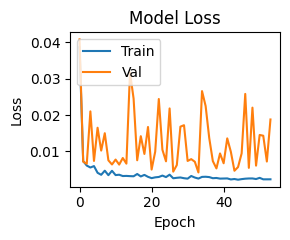

decoder_depth  decoder_width  encoder_depth  encoder_width      loss  \
0              2            128              1            256  0.003331   
1              2            128              1            512  0.003598   
2              2            128              1           1028  0.003608   
3              2            128              2            256  0.004505   
4              2            128              2            512  0.005055   
5              2            128              2           1028  0.004621   
6              2            128              3            256  0.005994   
7              2            128              3            512  0.004780   
8              2            128              3           1028  0.004188   

   epochs     time/s  best_hyperparameter  
0      38   9.164196                 True  
1      18   6.453863                False  
2      31   8.206497                False  
3      28   8.522282                False  
4      22   7.711809                False  
5       7   5.685050                False  
6      19   8.107011                False  
7      22   8.357214                False  
8      33  10.031868                False

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2899 - val_loss: 0.0432
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0383 - val_loss: 0.0263
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 0.0252 - val_loss: 0.0214
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 0.0192 - val_loss: 0.0151
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.0142 - val_loss: 0.0116
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0118 - val_loss: 0.0119
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0096 - val_loss: 0.0104
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0084 - val_loss: 0.0075
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0079 - val_loss: 0.0065
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0068 - val_loss: 0.0099
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0068 - val_loss: 0.0086

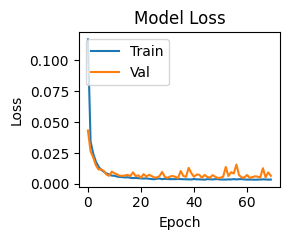

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2677 - val_loss: 0.0225
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 0.0230 - val_loss: 0.0175
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 0.0169 - val_loss: 0.0152
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.0132 - val_loss: 0.0148
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.0098 - val_loss: 0.0117
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0086 - val_loss: 0.0107
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0074 - val_loss: 0.0102
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.0052 - val_loss: 0.0085
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0047 - val_loss: 0.0060
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 0.0046 - val_loss: 0.0068

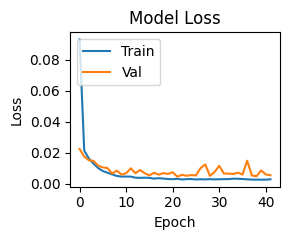

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1588 - val_loss: 0.0306
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.0147 - val_loss: 0.0117
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.0112 - val_loss: 0.0149
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.0096 - val_loss: 0.0080
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.0065 - val_loss: 0.0105
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.0061 - val_loss: 0.0067
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.0044 - val_loss: 0.0077
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.0042 - val_loss: 0.0075
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.0038 - val_loss: 0.0089
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 0.0038 - val_loss: 0.0083
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.0037 - val_loss: 0.0089

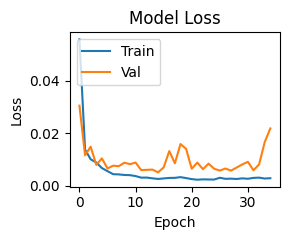

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1213 - val_loss: 0.0305
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0157 - val_loss: 0.0239
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.0121 - val_loss: 0.0257
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0104 - val_loss: 0.0137
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0078 - val_loss: 0.0117
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0073 - val_loss: 0.0232
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0069 - val_loss: 0.0123
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0064 - val_loss: 0.0117
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.0058 - val_loss: 0.0099
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0055 - val_loss: 0.0112
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0054 - val_loss: 0.0186

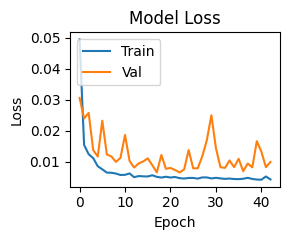

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0914 - val_loss: 0.0187
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0128 - val_loss: 0.0272
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0104 - val_loss: 0.0232
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0084 - val_loss: 0.0239
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0081 - val_loss: 0.0113
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 0.0061 - val_loss: 0.0143
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0056 - val_loss: 0.0502
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0076 - val_loss: 0.0108
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.0048 - val_loss: 0.0095
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.0046 - val_loss: 0.0089
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 0.0041 - val_loss: 0.0106

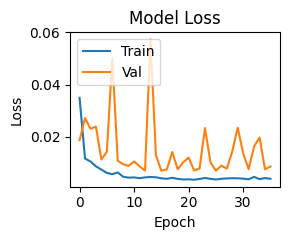

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0954 - val_loss: 0.0751
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.0131 - val_loss: 0.0359
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0088 - val_loss: 0.0469
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.0074 - val_loss: 0.0252
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0059 - val_loss: 0.0098
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0045 - val_loss: 0.0109
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0045 - val_loss: 0.0128
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 0.0046 - val_loss: 0.0074
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0039 - val_loss: 0.0103
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 0.0040 - val_loss: 0.0227
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0040 - val_loss: 0.0078

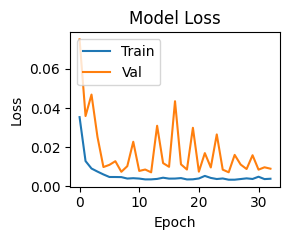

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1220 - val_loss: 0.0405
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0131 - val_loss: 0.0286
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.0111 - val_loss: 0.0147
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.0081 - val_loss: 0.0235
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.0073 - val_loss: 0.0128
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0071 - val_loss: 0.0098
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0065 - val_loss: 0.0134
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.0069 - val_loss: 0.0103
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0059 - val_loss: 0.0161
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0059 - val_loss: 0.0082
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.0053 - val_loss: 0.0080

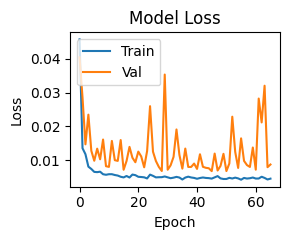

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0872 - val_loss: 0.0308
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0094 - val_loss: 0.0253
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0083 - val_loss: 0.0178
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0072 - val_loss: 0.0144
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0055 - val_loss: 0.0110
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0047 - val_loss: 0.0106
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0057 - val_loss: 0.0107
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0041 - val_loss: 0.0167
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 0.0045 - val_loss: 0.0080
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0041 - val_loss: 0.0100
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.0045 - val_loss: 0.0168

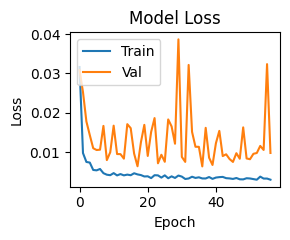

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1413 - val_loss: 0.0234
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 0.0067 - val_loss: 0.0144
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0065 - val_loss: 0.0211
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0050 - val_loss: 0.0103
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.0061 - val_loss: 0.0257
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0045 - val_loss: 0.0209
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.0042 - val_loss: 0.0210
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.0040 - val_loss: 0.0094
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0037 - val_loss: 0.0090
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0040 - val_loss: 0.0191
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.0041 - val_loss: 0.0143

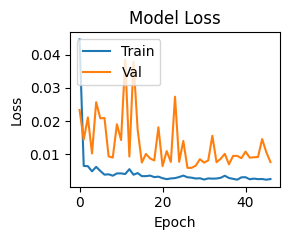

decoder_depth  decoder_width  encoder_depth  encoder_width      loss  \
0              2            128              1            256  0.004722   
1              2            128              1            512  0.004665   
2              2            128              1           1028  0.005168   
3              2            128              2            256  0.006526   
4              2            128              2            512  0.007040   
5              2            128              2           1028  0.007110   
6              2            128              3            256  0.006752   
7              2            128              3            512  0.006426   
8              2            128              3           1028  0.005942   

   epochs     time/s  best_hyperparameter  
0      49  10.792693                False  
1      21   6.943459                 True  
2      14   5.961279                False  
3      22   7.715945                False  
4      15   6.812504                False  
5      12   6.468003                False  
6      45  11.662547                False  
7      36  10.103201                False  
8      26   9.110753                False

['../checkpoints/snp500/tuning/2023/all_rue_predictor_best_hp.joblib']

In [10]:
all_rue_best_hp = {}
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    rue_tuning_df, rue_best_hp = model_tuning_regressor(
        param_grid=dict(
            encoder_width = [256, 512, 1028], 
            encoder_depth = [1, 2, 3],
            decoder_width = [128],
            decoder_depth = [2]
        ), predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], seed=seed,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    )
    display(rue_tuning_df)
    rue_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_rue_{time_label}.csv"))
    all_rue_best_hp[time_label] = rue_best_hp
joblib.dump(all_rue_best_hp, os.path.join(fp_tuning, str(seed), "all_rue_predictor_best_hp.joblib"))

In [12]:
all_rue_predictor_best_hp = joblib.load(os.path.join(fp_tuning, str(seed), "all_rue_predictor_best_hp.joblib"))
all_rue_predictor_best_hp

{'t+1': {'decoder_depth': 2,
  'decoder_width': 128,
  'encoder_depth': 1,
  'encoder_width': 512},
 't+2': {'decoder_depth': 2,
  'decoder_width': 128,
  'encoder_depth': 1,
  'encoder_width': 256},
 't+3': {'decoder_depth': 2,
  'decoder_width': 128,
  'encoder_depth': 1,
  'encoder_width': 512}}

#### Train Predictor

In [ ]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    best_predictor_hp = all_rue_predictor_best_hp[time_label]
    ae_regressor = model_training_predictor(
        best_predictor_hp, predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    ) 
    save_model(model=ae_regressor, name=f"rue_predictor_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)), override=True)

### Tune and Train Decoder

#### Tune Decoder

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 42.7696 - val_loss: 1.6434
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 1.0071 - val_loss: 1.2843
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.9736 - val_loss: 1.2948
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 0.9519 - val_loss: 1.2627
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.9477 - val_loss: 1.2463
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.9387 - val_loss: 1.2759
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 0.9433 - val_loss: 1.2459
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.9269 - val_loss: 1.2320
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 0.9244 - val_loss: 1.2362
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.9173 - val_loss: 1.2296
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 0.9125 - val_loss: 1.246

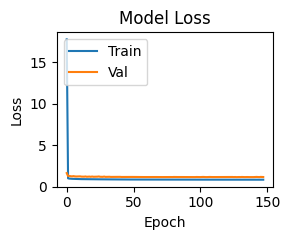

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 62.0843 - val_loss: 1.9309
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 1.3383 - val_loss: 1.7866
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.3224 - val_loss: 1.7212
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 1.3266 - val_loss: 1.6865
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 1.3156 - val_loss: 1.5837
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.2855 - val_loss: 1.6201
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.2760 - val_loss: 1.6252
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 1.2757 - val_loss: 1.5633
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.2603 - val_loss: 1.5719
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1.2444 - val_loss: 1.5513
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.2448 - val_loss: 1.566

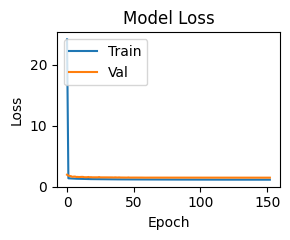

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 82.7809 - val_loss: 2.5256
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.9992 - val_loss: 2.4770
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.9963 - val_loss: 2.4522
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 1.9849 - val_loss: 2.2900
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 1.9747 - val_loss: 2.5128
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 1.9409 - val_loss: 2.2358
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.9407 - val_loss: 2.2258
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1.9268 - val_loss: 2.2041
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 1.8925 - val_loss: 2.1895
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 1.8734 - val_loss: 2.1741
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 1.8619 - val_loss: 2.168

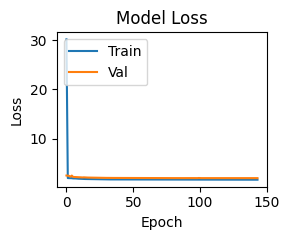

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 84.7605 - val_loss: 2.0171
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 1.3265 - val_loss: 2.0092
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.3201 - val_loss: 2.0053
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1.3163 - val_loss: 2.0024
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1.3142 - val_loss: 1.9991
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 1.3119 - val_loss: 1.9985
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 1.3102 - val_loss: 2.0001
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 1.3092 - val_loss: 1.9973
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1.3079 - val_loss: 1.9935
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.3071 - val_loss: 1.9939
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 1.3061 - val_loss: 1.992

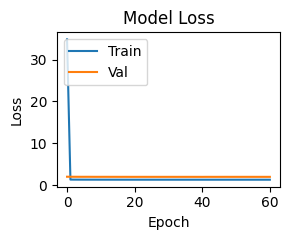

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 160.3332 - val_loss: 3.3089
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 2.6181 - val_loss: 3.2893
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 2.6031 - val_loss: 3.2835
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 2.5931 - val_loss: 3.2706
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 2.5848 - val_loss: 3.2733
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 2.5800 - val_loss: 3.2788
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 2.5761 - val_loss: 3.2610
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 2.5726 - val_loss: 3.2581
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 2.5701 - val_loss: 3.2461
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 2.5666 - val_loss: 3.2513
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.5641 - val_loss: 3.25

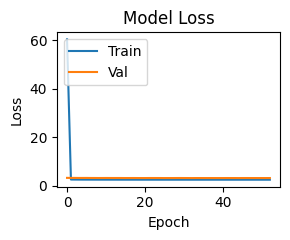

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 310.4102 - val_loss: 7.8221
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1319 - val_loss: 7.7088
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 7.0857 - val_loss: 7.7000
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 7.0639 - val_loss: 7.7384
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 7.0480 - val_loss: 7.7357
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 7.0344 - val_loss: 7.7896
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 7.0320 - val_loss: 7.6881
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 7.0165 - val_loss: 7.6628
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 7.0085 - val_loss: 7.6682
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 7.0009 - val_loss: 7.6598
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 6.9911 - val_loss: 7.664

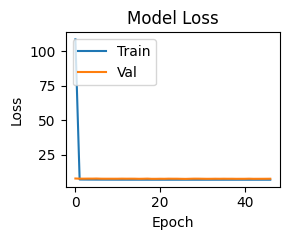

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 126.8185 - val_loss: 2.3425
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 1.6559 - val_loss: 2.3377
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 1.6531 - val_loss: 2.3404
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 1.6522 - val_loss: 2.3425
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.6522 - val_loss: 2.3360
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.6508 - val_loss: 2.3410
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.6506 - val_loss: 2.3418
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.6504 - val_loss: 2.3391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.6501 - val_loss: 2.3311
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 1.6491 - val_loss: 2.3376
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 1.6490 - val_loss: 2.33

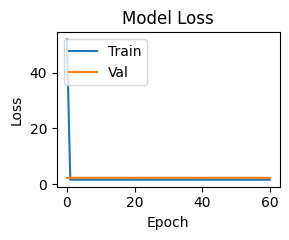

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 258.5830 - val_loss: 4.5941
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 3.9158 - val_loss: 4.5790
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 3.9111 - val_loss: 4.6001
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 3.9116 - val_loss: 4.5897
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 3.9081 - val_loss: 4.6086
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3.9076 - val_loss: 4.6372
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 3.9077 - val_loss: 4.5942
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 3.9061 - val_loss: 4.5900
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 3.9069 - val_loss: 4.5631
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 3.9027 - val_loss: 4.5910
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 3.9014 - val_loss: 4.6

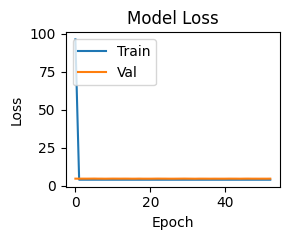

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 538.0858 - val_loss: 13.0660
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3963 - val_loss: 12.8765
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3674 - val_loss: 12.9202
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3647 - val_loss: 13.0605
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3572 - val_loss: 13.0737
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3512 - val_loss: 13.2650
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3731 - val_loss: 13.0048
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3550 - val_loss: 12.9432
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3539 - val_loss: 12.9594
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3505 - val_loss: 13.0071
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3415 - val_loss: 13.

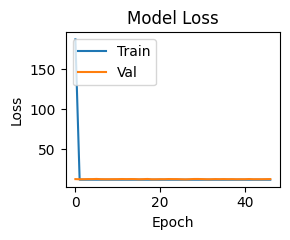

decoder_depth  decoder_width  encoder_depth  encoder_width       loss  \
0              2            512              1            512   1.158660   
1              2           1028              1            512   1.440658   
2              2           2048              1            512   1.994341   
3              3            512              1            512   1.983660   
4              3           1028              1            512   3.223630   
5              3           2048              1            512   7.549559   
6              4            512              1            512   2.328373   
7              4           1028              1            512   4.551850   
8              4           2048              1            512  12.774111   

       corr  epochs     time/s  best_hyperparameter  
0  0.455014     127  22.201779                False  
1  0.453489     132  21.773337                False  
2  0.454709     123  20.384920                False  
3  0.464354      40  10.016651                False  
4  0.464369      32   9.658911                False  
5  0.464331      26  10.622366                False  
6  0.464407      40  11.242236                 True  
7  0.464377      32  11.199237                False  
8  0.464327      26  12.605705                False

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 26.9913 - val_loss: 1.4428
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.8424 - val_loss: 1.2813
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.8192 - val_loss: 1.1402
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.7890 - val_loss: 1.2807
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.7833 - val_loss: 1.1266
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 0.7765 - val_loss: 1.0706
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.7753 - val_loss: 1.0607
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.7619 - val_loss: 1.0653
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.7672 - val_loss: 1.1109
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 0.7536 - val_loss: 1.0641
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.7532 - val_loss: 1.045

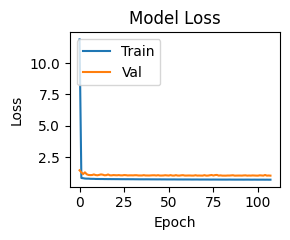

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 36.0569 - val_loss: 1.5873
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 1.0146 - val_loss: 1.3050
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.9836 - val_loss: 1.3661
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.9719 - val_loss: 1.3685
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.9644 - val_loss: 1.3227
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.9419 - val_loss: 1.2616
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.9468 - val_loss: 1.2831
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.9327 - val_loss: 1.2663
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 0.9197 - val_loss: 1.2765
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 0.9120 - val_loss: 1.2149
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.9164 - val_loss: 1.245

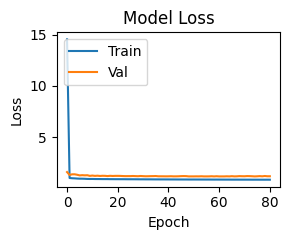

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 45.2585 - val_loss: 1.8470
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 1.3528 - val_loss: 1.8650
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1.3465 - val_loss: 1.8246
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1.3328 - val_loss: 1.6323
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 1.2943 - val_loss: 1.5594
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 1.2831 - val_loss: 1.5666
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 1.2675 - val_loss: 1.6644
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 1.2658 - val_loss: 1.6870
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 1.2557 - val_loss: 1.5310
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 1.2297 - val_loss: 1.5312
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 1.2260 - val_loss: 1.550

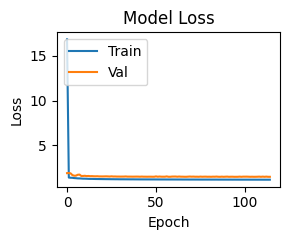

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 68.9949 - val_loss: 1.8545
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1.1730 - val_loss: 1.8476
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.1676 - val_loss: 1.8445
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1.1648 - val_loss: 1.8435
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.1629 - val_loss: 1.8406
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 1.1612 - val_loss: 1.8411
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.1600 - val_loss: 1.8409
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 1.1594 - val_loss: 1.8391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 1.1587 - val_loss: 1.8373
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 1.1581 - val_loss: 1.8382
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.1577 - val_loss: 1.838

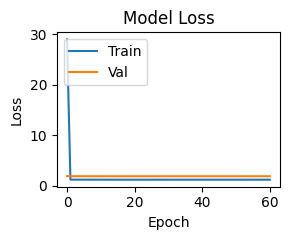

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 134.3206 - val_loss: 2.9846
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 2.3047 - val_loss: 2.9659
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 2.2899 - val_loss: 2.9601
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 2.2806 - val_loss: 2.9487
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 2.2733 - val_loss: 2.9510
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 2.2687 - val_loss: 2.9548
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 2.2654 - val_loss: 2.9417
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 2.2625 - val_loss: 2.9369
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 2.2599 - val_loss: 2.9251
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 2.2567 - val_loss: 2.9311
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 2.2542 - val_loss: 2.9

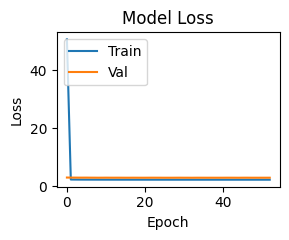

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 272.8976 - val_loss: 7.1677
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 6.4942 - val_loss: 7.0673
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 6.4520 - val_loss: 7.0595
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 6.4308 - val_loss: 7.0898
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 6.4150 - val_loss: 7.0850
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 6.4027 - val_loss: 7.1407
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 6.4020 - val_loss: 7.0443
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 6.3880 - val_loss: 7.0184
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 6.3810 - val_loss: 7.0284
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 6.3750 - val_loss: 7.0270
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 6.3673 - val_loss: 7.0

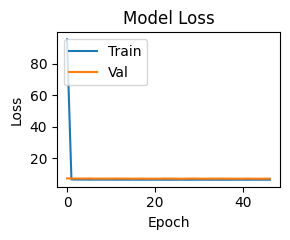

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 111.0584 - val_loss: 2.1841
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5037 - val_loss: 2.1791
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 1.5006 - val_loss: 2.1805
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 1.4994 - val_loss: 2.1810
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1.4990 - val_loss: 2.1766
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.4980 - val_loss: 2.1790
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1.4976 - val_loss: 2.1793
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1.4974 - val_loss: 2.1779
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1.4971 - val_loss: 2.1723
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 1.4964 - val_loss: 2.1749
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 1.4961 - val_loss: 2.175

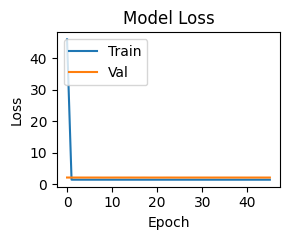

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 232.5699 - val_loss: 4.2714
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 3.6012 - val_loss: 4.2562
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 3.5956 - val_loss: 4.2771
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 3.5957 - val_loss: 4.2659
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 3.5928 - val_loss: 4.2786
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 3.5922 - val_loss: 4.3077
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 3.5917 - val_loss: 4.2704
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3.5901 - val_loss: 4.2655
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 3.5907 - val_loss: 4.2394
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 3.5868 - val_loss: 4.2649
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 3.5853 - val_loss: 4.2

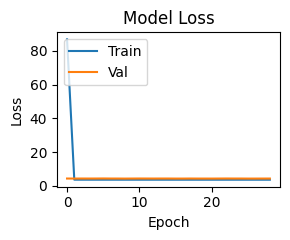

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 500.5702 - val_loss: 12.4258
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7586 - val_loss: 12.2423
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7322 - val_loss: 12.2756
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7302 - val_loss: 12.4068
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7214 - val_loss: 12.4190
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7155 - val_loss: 12.6072
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7374 - val_loss: 12.3515
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7196 - val_loss: 12.2941
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7181 - val_loss: 12.3161
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7142 - val_loss: 12.3606
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.7061 - val_loss: 12.

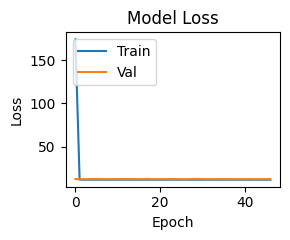

decoder_depth  decoder_width  encoder_depth  encoder_width       loss  \
0              2            512              1            256   1.015875   
1              2           1028              1            256   1.162191   
2              2           2048              1            256   1.436778   
3              3            512              1            256   1.833316   
4              3           1028              1            256   2.913305   
5              3           2048              1            256   6.933194   
6              4            512              1            256   2.172309   
7              4           1028              1            256   4.239409   
8              4           2048              1            256  12.141937   

       corr  epochs     time/s  best_hyperparameter  
0  0.462925      87  15.983562                False  
1  0.464347      60  12.247432                False  
2  0.462745      94  16.527986                False  
3  0.474507      40  11.090483                 True  
4  0.474485      32  10.068959                False  
5  0.474464      26  10.137671                False  
6  0.474482      25  10.254108                False  
7  0.474339       8   7.592967                False  
8  0.474470      26  12.365274                False

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 42.7748 - val_loss: 1.6477
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1.0184 - val_loss: 1.2752
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.9715 - val_loss: 1.2692
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.9550 - val_loss: 1.2620
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.9472 - val_loss: 1.2516
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.9413 - val_loss: 1.2337
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.9429 - val_loss: 1.2307
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 0.9266 - val_loss: 1.2263
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.9240 - val_loss: 1.2524
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 0.9274 - val_loss: 1.2318
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.9166 - val_loss: 1.237

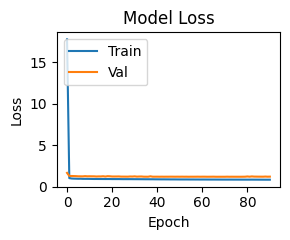

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 62.0922 - val_loss: 1.9512
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.3504 - val_loss: 1.6060
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.3197 - val_loss: 1.7059
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1.3070 - val_loss: 1.5771
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 1.2876 - val_loss: 1.6082
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 1.2903 - val_loss: 1.5705
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 1.2734 - val_loss: 1.5989
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 1.2665 - val_loss: 1.5726
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 1.2585 - val_loss: 1.6547
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 1.2568 - val_loss: 1.5750
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.2439 - val_loss: 1.580

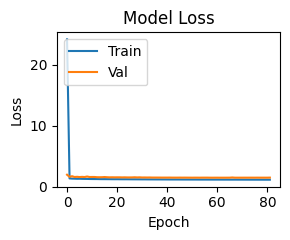

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 82.7875 - val_loss: 2.5613
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 2.0076 - val_loss: 2.4765
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.9835 - val_loss: 2.3368
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 1.9718 - val_loss: 2.3921
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 1.9565 - val_loss: 2.3537
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 1.9560 - val_loss: 2.2188
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1.9248 - val_loss: 2.2134
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.9108 - val_loss: 2.3180
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1.9064 - val_loss: 2.2131
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 1.8865 - val_loss: 2.2319
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 1.8722 - val_loss: 2.171

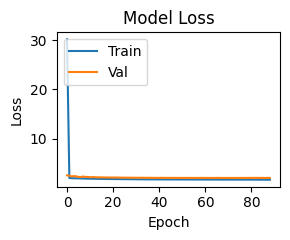

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 84.7665 - val_loss: 2.0256
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1.3366 - val_loss: 2.0183
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 1.3306 - val_loss: 2.0154
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.3268 - val_loss: 2.0131
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 1.3244 - val_loss: 2.0088
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.3220 - val_loss: 2.0080
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1.3203 - val_loss: 2.0084
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.3192 - val_loss: 2.0068
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1.3181 - val_loss: 2.0026
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.3168 - val_loss: 2.0034
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 1.3161 - val_loss: 2.002

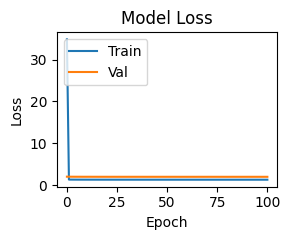

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 160.3412 - val_loss: 3.3134
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 2.6273 - val_loss: 3.2944
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 2.6139 - val_loss: 3.2906
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 2.6047 - val_loss: 3.2769
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 2.5964 - val_loss: 3.2820
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 2.5916 - val_loss: 3.2875
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 2.5880 - val_loss: 3.2706
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.5841 - val_loss: 3.2656
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.5818 - val_loss: 3.2545
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 2.5781 - val_loss: 3.2605
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 2.5751 - val_loss: 3.26

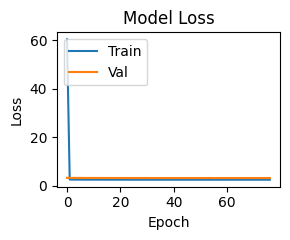

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 310.4198 - val_loss: 7.8210
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1465 - val_loss: 7.7130
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1019 - val_loss: 7.7108
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 7.0808 - val_loss: 7.7514
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 7.0665 - val_loss: 7.7498
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 7.0537 - val_loss: 7.8051
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 7.0519 - val_loss: 7.7043
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 7.0368 - val_loss: 7.6795
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 7.0289 - val_loss: 7.6771
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 7.0220 - val_loss: 7.6804
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 7.0128 - val_loss: 7.6845
E

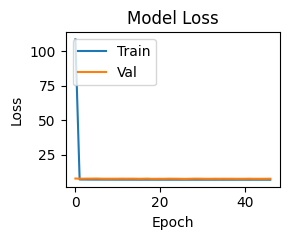

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 126.8268 - val_loss: 2.3543
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.6663 - val_loss: 2.3491
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 1.6634 - val_loss: 2.3510
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 1.6625 - val_loss: 2.3523
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 1.6623 - val_loss: 2.3455
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 1.6611 - val_loss: 2.3491
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 1.6608 - val_loss: 2.3524
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 1.6607 - val_loss: 2.3491
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 1.6602 - val_loss: 2.3405
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 1.6596 - val_loss: 2.3454
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 1.6592 - val_loss: 2.34

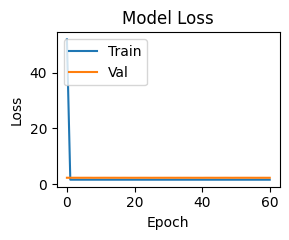

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 258.5912 - val_loss: 4.5985
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 3.9241 - val_loss: 4.5831
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 3.9191 - val_loss: 4.6043
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 3.9193 - val_loss: 4.5928
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3.9158 - val_loss: 4.6108
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 3.9153 - val_loss: 4.6416
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 3.9155 - val_loss: 4.5976
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 3.9134 - val_loss: 4.5942
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 3.9143 - val_loss: 4.5692
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 3.9103 - val_loss: 4.5950
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 3.9086 - val_loss: 4.62

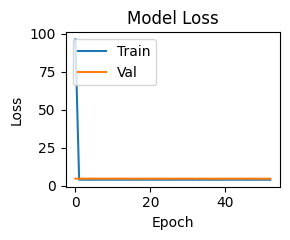

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 538.0950 - val_loss: 13.0808
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.4094 - val_loss: 12.8836
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3793 - val_loss: 12.9243
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3756 - val_loss: 13.0682
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3678 - val_loss: 13.0801
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3621 - val_loss: 13.2750
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3839 - val_loss: 13.0087
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3655 - val_loss: 12.9436
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3650 - val_loss: 12.9599
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3615 - val_loss: 13.0114
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.3526 - val_loss: 13.

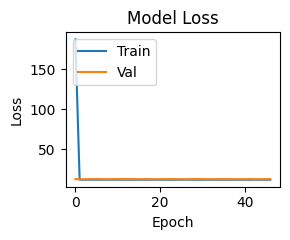

decoder_depth  decoder_width  encoder_depth  encoder_width       loss  \
0              2            512              1            512   1.177767   
1              2           1028              1            512   1.463548   
2              2           2048              1            512   2.015771   
3              3            512              1            512   1.992894   
4              3           1028              1            512   3.224061   
5              3           2048              1            512   7.567015   
6              4            512              1            512   2.338403   
7              4           1028              1            512   4.561814   
8              4           2048              1            512  12.782426   

       corr  epochs     time/s  best_hyperparameter  
0  0.444053      70  13.396874                False  
1  0.445595      61  12.438517                False  
2  0.442319      68  13.450939                False  
3  0.454285      80  15.777705                False  
4  0.454295      56  13.262569                False  
5  0.454345      26  10.152479                 True  
6  0.454290      40  10.840657                False  
7  0.454319      32  10.814093                False  
8  0.454342      26  11.852895                False

['../checkpoints/snp500/tuning/2023/all_rue_decoder_best_hp.joblib']

In [26]:
all_rue_decoder_best_hp = {}
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    best_predictor_hp = all_rue_predictor_best_hp[time_label]
    prev_model = load_model(name=f"rue_predictor_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    rue_tuning_df, rue_best_hp = model_tuning_decoder(
        param_grid=dict(
            encoder_width = [best_predictor_hp["encoder_width"]], # , 256, 512
            encoder_depth = [best_predictor_hp["encoder_depth"]], #  3, 4
            decoder_width = [512, 1028, 2048], 
            decoder_depth = [2, 3, 4]
        ), predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], seed=seed,
        max_epochs=10000, verbose=1, patience=20, prev_model=prev_model
    )
    display(rue_tuning_df)
    rue_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_rue_decoder_{time_label}.csv"))
    all_rue_decoder_best_hp[time_label] = rue_best_hp
joblib.dump(all_rue_decoder_best_hp, os.path.join(fp_tuning, str(seed), "all_rue_decoder_best_hp.joblib"))

In [ ]:
# [256, 512, 1028], [1, 2, 3]
# With Regularisation (L2=0.01) and MSE: 0.41799
# With Regularisation and MAE: 0.43868
# Without Regularisation and MAE: 0.42652
# With Regularisation (L2=0.1) and MSE: 0.45543
# With Regularisation (L1) and MAE: 0.46435

In [27]:
all_rue_decoder_best_hp = joblib.load(os.path.join(fp_tuning, str(seed), "all_rue_decoder_best_hp.joblib"))
all_rue_decoder_best_hp

{'t+1': {'decoder_depth': 4,
  'decoder_width': 512,
  'encoder_depth': 1,
  'encoder_width': 512},
 't+2': {'decoder_depth': 3,
  'decoder_width': 512,
  'encoder_depth': 1,
  'encoder_width': 256},
 't+3': {'decoder_depth': 3,
  'decoder_width': 2048,
  'encoder_depth': 1,
  'encoder_width': 512}}

#### Train Decoder

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 126.8185 - val_loss: 2.3425
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 1.6559 - val_loss: 2.3377
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 1.6531 - val_loss: 2.3404
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 1.6522 - val_loss: 2.3425
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 1.6522 - val_loss: 2.3360
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.6508 - val_loss: 2.3410
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 1.6506 - val_loss: 2.3418
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 1.6504 - val_loss: 2.3391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 1.6501 - val_loss: 2.3311
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 1.6491 - val_loss: 2.3376
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 1.6490 - val_loss: 2.33

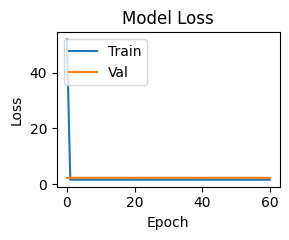

Training took 10.589262008666992s.
Model saved!


Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 68.9949 - val_loss: 1.8545
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 1.1730 - val_loss: 1.8476
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 1.1676 - val_loss: 1.8445
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 1.1648 - val_loss: 1.8435
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.1629 - val_loss: 1.8406
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1.1612 - val_loss: 1.8411
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.1600 - val_loss: 1.8409
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.1594 - val_loss: 1.8391
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.1587 - val_loss: 1.8373
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1.1581 - val_loss: 1.8382
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 1.1577 - val_loss: 1.838

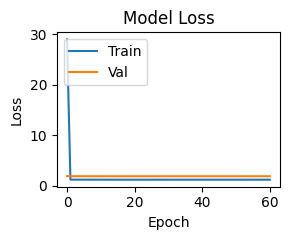

Training took 10.438689231872559s.
Model saved!


Epoch 1/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 310.4198 - val_loss: 7.8210
Epoch 2/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1465 - val_loss: 7.7130
Epoch 3/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 7.1019 - val_loss: 7.7108
Epoch 4/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 7.0808 - val_loss: 7.7514
Epoch 5/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 7.0665 - val_loss: 7.7498
Epoch 6/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 7.0537 - val_loss: 7.8051
Epoch 7/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0519 - val_loss: 7.7043
Epoch 8/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 7.0368 - val_loss: 7.6795
Epoch 9/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 7.0289 - val_loss: 7.6771
Epoch 10/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 7.0220 - val_loss: 7.6804
Epoch 11/10000
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 7.0128 - val_loss: 7.6845
E

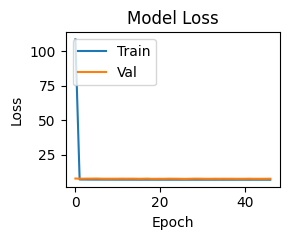

Training took 9.96420931816101s.
Model saved!


In [28]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    prev_model = load_model(name=f"rue_predictor_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    hp_dict = all_rue_decoder_best_hp[time_label]
    ae_regressor = model_training_decoder(
        hp_dict, predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed, prev_model=prev_model,
        batch_size=batch_size, max_epochs=10000, verbose=1, patience=20
    ) 
    save_model(model=ae_regressor, name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)), override=True)

### Prediction

In [32]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    rue_valid_df = model_test_predictions(
        ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["valid_df"], 
        pred_cols=time_info_dict["outputs"], predictors=feat_cols, regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10, seed=seed)
    rue_test_df = model_test_predictions(
        ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["test_df"], 
        pred_cols=time_info_dict["outputs"], predictors=feat_cols, regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10, seed=seed)
    display(rue_test_df)
    rue_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"rue_valid_{time_label[-1]}.csv"))
    rue_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"rue_test_{time_label[-1]}.csv"))

  0%|          | 0/3 [00:00<?, ?it/s]

Predicting with Decoder + Predictor took 0.007172107696533203s. 
Predicting with MC Dropout took 0.033339738845825195s. 
Predicting with Decoder + Predictor took 0.007191896438598633s. 
Predicting with MC Dropout took 0.03348374366760254s. 


input_start date input end date target_date_t+1  input start index  \
11742       2010-08-24     2010-08-30      2010-08-31              11742   
11743       2010-08-25     2010-08-31      2010-09-01              11743   
11744       2010-08-26     2010-09-01      2010-09-02              11744   
11745       2010-08-27     2010-09-02      2010-09-03              11745   
11746       2010-08-30     2010-09-03      2010-09-07              11746   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-21              14672   
14673       2022-04-14     2022-04-21      2022-04-22              14673   
14674       2022-04-18     2022-04-22      2022-04-25              14674   
14675       2022-04-19     2022-04-25      2022-04-26              14675   
14676       2022-04-20     2022-04-26      2022-04-27              14676   

       input end index  target_index_t+1    U$_day0  Mkt-RF_day0  SMB_day0  \
11742            11746             11747   1.691458    -1.649939  0.259675   
11743            11747             11748   1.700180     0.471671  2.068479   
11744            11748             11749   1.679736    -0.858457 -0.153204   
11745            11749             11750   1.723524     1.977684  1.832548   
11746            11750             11751   1.684021    -1.715895 -1.667093   
...                ...               ...        ...          ...       ...   
14672            14676             14677  10.249206     1.515987  1.753904   
14673            14677             14678  10.113077    -1.430083  0.023745   
14674            14678             14679  10.110808    -0.253853 -1.608111   
14675            14679             14680  10.288582     1.922720  1.144416   
14676            14680             14681  10.281624    -0.330803  0.377641   

       HML_day0  ...  Mom_day3_reconstruction_t+1  U$_day4_reconstruction_t+1  \
11742  0.286564  ...                      0.04329                   -0.499423   
11743 -0.049466  ...                      0.04329                   -0.499423   
11744 -0.587113  ...                      0.04329                   -0.499423   
11745  0.779407  ...                      0.04329                   -0.499423   
11746 -0.990348  ...                      0.04329                   -0.499423   
...         ...  ...                          ...                         ...   
14672 -1.640005  ...                      0.04329                   -0.499423   
14673  3.109210  ...                      0.04329                   -0.499423   
14674  3.982887  ...                      0.04329                   -0.499423   
14675 -2.177652  ...                      0.04329                   -0.499423   
14676  2.750779  ...                      0.04329                   -0.499423   

       Mkt-RF_day4_reconstruction_t+1  SMB_day4_reconstruction_t+1  \
11742                        0.002543                     0.039456   
11743                        0.002543                     0.039456   
11744                        0.002543                     0.039456   
11745                        0.002543                     0.039456   
11746                        0.002543                     0.039456   
...                               ...                          ...   
14672                        0.002543                     0.039456   
14673                        0.002543                     0.039456   
14674                        0.002543                     0.039456   
14675                        0.002543                     0.039456   
14676                        0.002543                     0.039456   

       HML_day4_reconstruction_t+1  Mom_day4_reconstruction_t+1       rue  \
11742                    -0.004415                     0.029934  1.136725   
11743                    -0.004415                     0.029934  1.144425   
11744                    -0.004415                     0.029934  1.296649   
11745                    -0.004415

Predicting with Decoder + Predictor took 0.0074748992919921875s. 
Predicting with MC Dropout took 0.033986568450927734s. 
Predicting with Decoder + Predictor took 0.007645845413208008s. 
Predicting with MC Dropout took 0.03360176086425781s. 


input_start date input end date target_date_t+2  input start index  \
11741       2010-08-23     2010-08-27      2010-08-31              11741   
11742       2010-08-24     2010-08-30      2010-09-01              11742   
11743       2010-08-25     2010-08-31      2010-09-02              11743   
11744       2010-08-26     2010-09-01      2010-09-03              11744   
11745       2010-08-27     2010-09-02      2010-09-07              11745   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-22              14672   
14673       2022-04-14     2022-04-21      2022-04-25              14673   
14674       2022-04-18     2022-04-22      2022-04-26              14674   
14675       2022-04-19     2022-04-25      2022-04-27              14675   
14676       2022-04-20     2022-04-26      2022-04-28              14676   

       input end index  target_index_t+2    U$_day0  Mkt-RF_day0  SMB_day0  \
11741            11745             11747   1.730507    -0.572645 -1.863702   
11742            11746             11748   1.691458    -1.649939  0.259675   
11743            11747             11749   1.700180     0.471671  2.068479   
11744            11748             11750   1.679736    -0.858457 -0.153204   
11745            11749             11751   1.723524     1.977684  1.832548   
...                ...               ...        ...          ...       ...   
14672            14676             14678  10.249206     1.515987  1.753904   
14673            14677             14679  10.113077    -1.430083  0.023745   
14674            14678             14680  10.110808    -0.253853 -1.608111   
14675            14679             14681  10.288582     1.922720  1.144416   
14676            14680             14682  10.281624    -0.330803  0.377641   

       HML_day0  ...  Mom_day3_reconstruction_t+2  U$_day4_reconstruction_t+2  \
11741 -0.945544  ...                     0.047149                   -0.515177   
11742  0.286564  ...                     0.047151                   -0.515170   
11743 -0.049466  ...                     0.047149                   -0.515177   
11744 -0.587113  ...                     0.047148                   -0.515173   
11745  0.779407  ...                     0.047152                   -0.515172   
...         ...  ...                          ...                         ...   
14672 -1.640005  ...                     0.047145                   -0.515158   
14673  3.109210  ...                     0.047139                   -0.515154   
14674  3.982887  ...                     0.047138                   -0.515154   
14675 -2.177652  ...                     0.047138                   -0.515154   
14676  2.750779  ...                     0.047139                   -0.515154   

       Mkt-RF_day4_reconstruction_t+2  SMB_day4_reconstruction_t+2  \
11741                        0.042119                     0.037038   
11742                        0.042107                     0.037039   
11743                        0.042116                     0.037035   
11744                        0.042116                     0.037036   
11745                        0.042112                     0.037042   
...                               ...                          ...   
14672                        0.042115                     0.037036   
14673                        0.042116                     0.037034   
14674                        0.042112                     0.037034   
14675                        0.042114                     0.037033   
14676                        0.042112                     0.037034   

       HML_day4_reconstruction_t+2  Mom_day4_reconstruction_t+2       rue  \
11741                    -0.026268                     0.047126  1.126651   
11742                    -0.026265                     0.047131  1.142328   
11743                    -0.026268                     0.047129  1.148858   
11744                    -0.026268

Predicting with Decoder + Predictor took 0.008094072341918945s. 
Predicting with MC Dropout took 0.033986568450927734s. 
Predicting with Decoder + Predictor took 0.007777690887451172s. 
Predicting with MC Dropout took 0.03369259834289551s. 


input_start date input end date target_date_t+3  input start index  \
11740       2010-08-20     2010-08-26      2010-08-31              11740   
11741       2010-08-23     2010-08-27      2010-09-01              11741   
11742       2010-08-24     2010-08-30      2010-09-02              11742   
11743       2010-08-25     2010-08-31      2010-09-03              11743   
11744       2010-08-26     2010-09-01      2010-09-07              11744   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-25              14672   
14673       2022-04-14     2022-04-21      2022-04-26              14673   
14674       2022-04-18     2022-04-22      2022-04-27              14674   
14675       2022-04-19     2022-04-25      2022-04-28              14675   
14676       2022-04-20     2022-04-26      2022-04-29              14676   

       input end index  target_index_t+3    U$_day0  Mkt-RF_day0  SMB_day0  \
11740            11744             11747   1.741422    -0.330803  0.534928   
11741            11745             11748   1.730507    -0.572645 -1.863702   
11742            11746             11749   1.691458    -1.649939  0.259675   
11743            11747             11750   1.700180     0.471671  2.068479   
11744            11748             11751   1.679736    -0.858457 -0.153204   
...                ...               ...        ...          ...       ...   
14672            14676             14679  10.249206     1.515987  1.753904   
14673            14677             14680  10.113077    -1.430083  0.023745   
14674            14678             14681  10.110808    -0.253853 -1.608111   
14675            14679             14682  10.288582     1.922720  1.144416   
14676            14680             14683  10.281624    -0.330803  0.377641   

       HML_day0  ...  Mom_day3_reconstruction_t+3  U$_day4_reconstruction_t+3  \
11740 -0.564711  ...                     0.021831                   -0.533047   
11741 -0.945544  ...                     0.021829                   -0.533058   
11742  0.286564  ...                     0.021833                   -0.533044   
11743 -0.049466  ...                     0.021830                   -0.533047   
11744 -0.587113  ...                     0.021826                   -0.533061   
...         ...  ...                          ...                         ...   
14672 -1.640005  ...                     0.021812                   -0.533053   
14673  3.109210  ...                     0.021813                   -0.533029   
14674  3.982887  ...                     0.021817                   -0.533040   
14675 -2.177652  ...                     0.021809                   -0.533025   
14676  2.750779  ...                     0.021815                   -0.533039   

       Mkt-RF_day4_reconstruction_t+3  SMB_day4_reconstruction_t+3  \
11740                        0.008429                     0.043557   
11741                        0.008425                     0.043559   
11742                        0.008426                     0.043560   
11743                        0.008427                     0.043561   
11744                        0.008424                     0.043559   
...                               ...                          ...   
14672                        0.008417                     0.043556   
14673                        0.008422                     0.043560   
14674                        0.008418                     0.043556   
14675                        0.008421                     0.043561   
14676                        0.008419                     0.043554   

       HML_day4_reconstruction_t+3  Mom_day4_reconstruction_t+3       rue  \
11740                     0.000509                     0.032542  0.989156   
11741                     0.000507                     0.032544  1.132960   
11742                     0.000510                     0.032541  1.147572   
11743                     0.000508

## GPR Model Training

In [125]:
def model_training_gpr(
    predictors, pred_cols, train_df, valid_df, seed):

    timer = Timer(seed)
    
    # Get data
    train_X, train_y = (
        train_df[predictors].values.astype('float64'), train_df[pred_cols].values.astype('float64'))
    valid_X, valid_y = (
        valid_df[predictors].values.astype('float64'), valid_df[pred_cols].values.astype('float64'))

    rng = np.random.default_rng(seed)
    n_inducing = round(len(train_X)*0.01) # 1% of points as inducing points
    print("- Number of Inducing Points:", n_inducing)
    inducing_points = rng.choice(train_X, size=n_inducing, replace=False)

    start = time.time()
    
    def step_callback(step, variables, values):
        print(f"Step {step} {time.time()-start:.3f} s", end="\r")

    gpr = gpflow.models.SGPR(
        (train_X, train_y),
        kernel=gpflow.kernels.SquaredExponential(),
        inducing_variable=inducing_points,
    )
    opt = gpflow.optimizers.Scipy()
    print(f"Training started...")
    timer.start(description="Training GPR")
    opt.minimize(gpr.training_loss, gpr.trainable_variables, step_callback=step_callback)
    timer.end()
    # Train GPR
    # from sklearn.gaussian_process import GaussianProcessRegressor
    # from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
    # kernel = DotProduct() + WhiteKernel()
    # gpr = GaussianProcessRegressor(kernel=kernel, copy_X_train=False, random_state=seed)
    # print(f"Training started...")
    # start = time.time()
    # gpr.fit(train_X, train_y)
    
    
    return gpr

def model_test_predictions_gpr(
    gpr, df_test, pred_cols, predictors, regressor_label, pred_min, seed=seed):
    timer = Timer(seed)
    df_test = df_test.copy()
  
    test_X, test_y = (
        df_test[predictors].values.astype('float64'), df_test[pred_cols].values.astype('float64'))
    timer.start(description="Predicting with GPR")
    test_y_pred, test_std = gpr.compiled_predict_y(test_X)
    timer.end()

    # test_y_pred, test_std = gpr.predict(test_X, return_std=True)
#     print(test_std.shape)
    predicted_colnames = [col+"_gpr"+regressor_label for col in pred_cols]
    std_colnames = [col+"_gpr_std"+regressor_label for col in pred_cols]
    gpr_mean_std_colname = "gpr_std_mean"
    df_test[predicted_colnames] = test_y_pred
    df_test[std_colnames] = test_std
    df_test[gpr_mean_std_colname] = np.mean(test_std, axis=1)
    
    return df_test

def save_model_gpr(model, name, fp_checkpoints, predictors):
    model.compiled_predict_y = tf.function(
        lambda Xnew: model.predict_y(Xnew),
        input_signature=[tf.TensorSpec(shape=[None, len(predictors)], dtype=tf.float64)],
    )
    tf.saved_model.save(model, os.path.join(fp_checkpoints, name))
    print("Model saved!")

def load_model_gpr(name, fp_checkpoints): 
    import pickle
    model_folder = os.path.join(fp_checkpoints, name)
    
    if not os.path.exists(model_folder):
        print("model checkpoint does not exist!")
        return
    
    return tf.saved_model.load(model_folder)
    
def calculate_mse(df_test, pred_cols, model_label, regressor_label):
    y_true = df_test[pred_cols].values
    predicted_cols = [col+model_label+regressor_label for col in pred_cols]
    y_pred = df_test[predicted_cols].values
    return sklearn.metrics.mean_squared_error(y_true, y_pred)

### Train GPR

In [126]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    gpr = model_training_gpr( 
        predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
        train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed
    ) 
    save_model_gpr(model=gpr, name=f"gpr_{time_label[-1]}", fp_checkpoints=os.path.join(fp_project_models, str(seed)), predictors=feat_cols)

  0%|          | 0/3 [00:00<?, ?it/s]

- Number of Inducing Points: 103
Training started...
Training GPR took 81.09190535545349s. 
INFO:tensorflow:Assets written to: ../checkpoints/snp500/models/2023/gpr_1/assets


INFO:tensorflow:Assets written to: ../checkpoints/snp500/models/2023/gpr_1/assets


Model saved!
- Number of Inducing Points: 103
Training started...
Training GPR took 58.75533103942871s. 
INFO:tensorflow:Assets written to: ../checkpoints/snp500/models/2023/gpr_2/assets


INFO:tensorflow:Assets written to: ../checkpoints/snp500/models/2023/gpr_2/assets


Model saved!
- Number of Inducing Points: 103
Training started...
Training GPR took 99.82475137710571s. 
INFO:tensorflow:Assets written to: ../checkpoints/snp500/models/2023/gpr_3/assets


INFO:tensorflow:Assets written to: ../checkpoints/snp500/models/2023/gpr_3/assets


Model saved!


### Prediction

In [127]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    gpr = load_model_gpr(name=f"gpr_{time_label[-1]}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    gpr_valid_df = model_test_predictions_gpr(
        gpr=gpr, df_test=time_info_dict["valid_df"], pred_cols=time_info_dict["outputs"], 
        predictors=feat_cols, regressor_label=f"_{time_label}", pred_min=1)
    gpr_test_df = model_test_predictions_gpr(
        gpr=gpr, df_test=time_info_dict["test_df"], pred_cols=time_info_dict["outputs"], 
        predictors=feat_cols, regressor_label=f"_{time_label}", pred_min=1)
    display(gpr_test_df)
    gpr_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"gpr_valid_{time_label[-1]}.csv"))
    gpr_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"gpr_test_{time_label[-1]}.csv"))

  0%|          | 0/3 [00:00<?, ?it/s]

Predicting with GPR took 0.05343914031982422s. 
Predicting with GPR took 0.0030488967895507812s. 


input_start date input end date target_date_t+1  input start index  \
11742       2010-08-24     2010-08-30      2010-08-31              11742   
11743       2010-08-25     2010-08-31      2010-09-01              11743   
11744       2010-08-26     2010-09-01      2010-09-02              11744   
11745       2010-08-27     2010-09-02      2010-09-03              11745   
11746       2010-08-30     2010-09-03      2010-09-07              11746   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-21              14672   
14673       2022-04-14     2022-04-21      2022-04-22              14673   
14674       2022-04-18     2022-04-22      2022-04-25              14674   
14675       2022-04-19     2022-04-25      2022-04-26              14675   
14676       2022-04-20     2022-04-26      2022-04-27              14676   

       input end index  target_index_t+1    U$_day0  Mkt-RF_day0  SMB_day0  \
11742            11746             11747   1.691458    -1.649939  0.259675   
11743            11747             11748   1.700180     0.471671  2.068479   
11744            11748             11749   1.679736    -0.858457 -0.153204   
11745            11749             11750   1.723524     1.977684  1.832548   
11746            11750             11751   1.684021    -1.715895 -1.667093   
...                ...               ...        ...          ...       ...   
14672            14676             14677  10.249206     1.515987  1.753904   
14673            14677             14678  10.113077    -1.430083  0.023745   
14674            14678             14679  10.110808    -0.253853 -1.608111   
14675            14679             14680  10.288582     1.922720  1.144416   
14676            14680             14681  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
11745  0.779407  ...   1.787832     1.043296  0.495606 -0.855936  0.421585   
11746 -0.990348  ...   1.824158     1.461023  0.652894  0.443377  0.170626   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

          U$_t+1  recession_t+1  U$_t+1_gpr_t+1  U$_t+1_gpr_std_t+1  \
11742   1.685055          False        1.683974            0.000253   
11743   1.763102          False        1.682382            0.000253   
11744   1.787832          False        1.766402            0.000265   
11745   1.824158          False        1.782789            0.000263   
11746   1.792218          False        1.825659            0.000257   
...          ...            ...             ...                 ...   
14672  10.115774          False       10.150549            0.000779   
14673   9.808527          False       10.075361            0.000780   
14674   9.869886          False        9.773245            0.000799   
14675   9.565059          False        9.789815            0.000822   
14676   9.587142          False        9.501575            0.000795   

       gpr_std_mean  
11742      0.000253  
11743      0.000253  
11744      0.000265  
11745      0.000263  
11746      0.000257  
...             ...  
14672      0.000779  
14673      0.000780  
14674      0.000799  
14675      0.000822  
14676      0.000795  

[2935 rows x 36 columns]

Predicting with GPR took 0.05292797088623047s. 
Predicting with GPR took 0.002534627914428711s. 


input_start date input end date target_date_t+2  input start index  \
11741       2010-08-23     2010-08-27      2010-08-31              11741   
11742       2010-08-24     2010-08-30      2010-09-01              11742   
11743       2010-08-25     2010-08-31      2010-09-02              11743   
11744       2010-08-26     2010-09-01      2010-09-03              11744   
11745       2010-08-27     2010-09-02      2010-09-07              11745   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-22              14672   
14673       2022-04-14     2022-04-21      2022-04-25              14673   
14674       2022-04-18     2022-04-22      2022-04-26              14674   
14675       2022-04-19     2022-04-25      2022-04-27              14675   
14676       2022-04-20     2022-04-26      2022-04-28              14676   

       input end index  target_index_t+2    U$_day0  Mkt-RF_day0  SMB_day0  \
11741            11745             11747   1.730507    -0.572645 -1.863702   
11742            11746             11748   1.691458    -1.649939  0.259675   
11743            11747             11749   1.700180     0.471671  2.068479   
11744            11748             11750   1.679736    -0.858457 -0.153204   
11745            11749             11751   1.723524     1.977684  1.832548   
...                ...               ...        ...          ...       ...   
14672            14676             14678  10.249206     1.515987  1.753904   
14673            14677             14679  10.113077    -1.430083  0.023745   
14674            14678             14680  10.110808    -0.253853 -1.608111   
14675            14679             14681  10.288582     1.922720  1.144416   
14676            14680             14682  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11741 -0.945544  ...   1.723524     1.977684  1.832548  0.779407  0.739466   
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
11745  0.779407  ...   1.787832     1.043296  0.495606 -0.855936  0.421585   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

         U$_t+2  recession_t+2  U$_t+2_gpr_t+2  U$_t+2_gpr_std_t+2  \
11741  1.685055          False        1.725194            0.000500   
11742  1.763102          False        1.690816            0.000501   
11743  1.787832          False        1.685726            0.000504   
11744  1.824158          False        1.763796            0.000520   
11745  1.792218          False        1.780774            0.000522   
...         ...            ...             ...                 ...   
14672  9.808527          False       10.094086            0.001455   
14673  9.869886          False       10.000693            0.001567   
14674  9.565059          False        9.649717            0.001626   
14675  9.587142          False        9.719778            0.001634   
14676  9.848156          False        9.422282            0.001495   

       gpr_std_mean  
11741      0.000500  
11742      0.000501  
11743      0.000504  
11744      0.000520  
11745      0.000522  
...             ...  
14672      0.001455  
14673      0.001567  
14674      0.001626  
14675      0.001634  
14676      0.001495  

[2936 rows x 36 columns]

Predicting with GPR took 0.052896738052368164s. 
Predicting with GPR took 0.002936124801635742s. 


input_start date input end date target_date_t+3  input start index  \
11740       2010-08-20     2010-08-26      2010-08-31              11740   
11741       2010-08-23     2010-08-27      2010-09-01              11741   
11742       2010-08-24     2010-08-30      2010-09-02              11742   
11743       2010-08-25     2010-08-31      2010-09-03              11743   
11744       2010-08-26     2010-09-01      2010-09-07              11744   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-25              14672   
14673       2022-04-14     2022-04-21      2022-04-26              14673   
14674       2022-04-18     2022-04-22      2022-04-27              14674   
14675       2022-04-19     2022-04-25      2022-04-28              14675   
14676       2022-04-20     2022-04-26      2022-04-29              14676   

       input end index  target_index_t+3    U$_day0  Mkt-RF_day0  SMB_day0  \
11740            11744             11747   1.741422    -0.330803  0.534928   
11741            11745             11748   1.730507    -0.572645 -1.863702   
11742            11746             11749   1.691458    -1.649939  0.259675   
11743            11747             11750   1.700180     0.471671  2.068479   
11744            11748             11751   1.679736    -0.858457 -0.153204   
...                ...               ...        ...          ...       ...   
14672            14676             14679  10.249206     1.515987  1.753904   
14673            14677             14680  10.113077    -1.430083  0.023745   
14674            14678             14681  10.110808    -0.253853 -1.608111   
14675            14679             14682  10.288582     1.922720  1.144416   
14676            14680             14683  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11740 -0.564711  ...   1.679736    -0.858457 -0.153204 -0.587113  0.555430   
11741 -0.945544  ...   1.723524     1.977684  1.832548  0.779407  0.739466   
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

         U$_t+3  recession_t+3  U$_t+3_gpr_t+3  U$_t+3_gpr_std_t+3  \
11740  1.685055          False        1.688980            0.000708   
11741  1.763102          False        1.730816            0.000723   
11742  1.787832          False        1.692098            0.000728   
11743  1.824158          False        1.679547            0.000732   
11744  1.792218          False        1.769146            0.000772   
...         ...            ...             ...                 ...   
14672  9.869886          False       10.016115            0.002143   
14673  9.565059          False        9.857023            0.002236   
14674  9.587142          False        9.560755            0.002430   
14675  9.848156          False        9.613077            0.002257   
14676  9.455979          False        9.342732            0.002244   

       gpr_std_mean  
11740      0.000708  
11741      0.000723  
11742      0.000728  
11743      0.000732  
11744      0.000772  
...             ...  
14672      0.002143  
14673      0.002236  
14674      0.002430  
14675      0.002257  
14676      0.002244  

[2937 rows x 36 columns]

## InferNoise

In [160]:
def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred), axis=-1)

def tune_infernoise(ae_predictor, stddev_list, valid_df, inputs, outputs, seed, T, regressor_label):
    corr_list = []
    loss_list = []
    for stddev in tqdm(stddev_list):
        valid_pred_df = infernoise_test_predictions(ae_predictor, valid_df, inputs, outputs, seed, T, stddev, regressor_label, False)
        loss = valid_pred_df["infernoise_mae"]
        ue = valid_pred_df["infernoise_uncertainty"]
        corr, _ = pearsonr(ue, loss)
        loss_list.append(valid_pred_df["infernoise_mae"].mean())
        corr_list.append(corr)
    tuning_df = pd.DataFrame({"std": stddev_list, "correlation": corr_list, "loss":loss_list})
    tuning_df["best_hyperparameter"] = False
    best_index = tuning_df["loss"].idxmin()
    tuning_df.iloc[best_index, -1] = True
    return tuning_df

def infernoise_test_predictions(ae_predictor, test_df, inputs, outputs, seed, T, stddev, regressor_label, time_run=True):
    timer = Timer(seed=seed)
    test_df = test_df.copy()
    # Process data
    test_X, test_y = (test_df[inputs].values.astype('float32'), test_df[outputs].values.astype('float32'))
    
    set_seed(seed)

    # Define model
    input_layer = tf.keras.Input(shape=(len(inputs),))
    gaussian_noise_layer = tf.keras.layers.GaussianNoise(stddev, seed=seed)
    x = ae_predictor.encoder(input_layer)
    x = gaussian_noise_layer(x)
    x = ae_predictor.regressor.layers[-1](x) # To ignore dropout layer
    infernoise_model = tf.keras.Model(inputs=input_layer, outputs=x, name="infernoise_model")
    
    # For Infer Noise
    # - Sample with infer noise
    test_y_sample_preds = [] # T, num samples, output classes
    if time_run:
        timer.start(description="Predicting with Infer-Noise")
    for i in range(T):
        test_y_pred = infernoise_model(test_X, training=True)
        # print(test_y_pred[:5])
        test_y_sample_preds.append(test_y_pred)
    if time_run:
        timer.end()
    
    test_y_sample_preds = np.array(test_y_sample_preds)
    test_y_sample_preds =  test_y_sample_preds.transpose((1, 2, 0)) # num samples, predicted features, T
    
    # - Get mean prediction 
    # num samples, predicted features
    test_y_mean_pred = np.mean(test_y_sample_preds, axis=-1)
    predicted_infernoise_colnames = [col + "_infernoise"+regressor_label for col in outputs]
    test_df[predicted_infernoise_colnames] = test_y_mean_pred
    
    # - Get loss for each output
    test_y_mc_loss = mae_fn(y_true=test_y, y_pred=test_y_mean_pred)
    test_df["infernoise_mae"] = test_y_mc_loss
    
    # - Uncertainty score (for regression)
    #   - Calculate std of predictions
    test_y_sd_pred = np.mean(np.std(test_y_sample_preds, axis=-1, ddof=1), axis=-1)
    test_df["infernoise_uncertainty"] = test_y_sd_pred

    return test_df

def display_tuning_df(tuning_df):
    def highlight_sentiment(row):
        if row["best_hyperparameter"]:
            return ['background-color: #cafae6'] * len(row)
        else:
            return [''] * len(row)
    return tuning_df.style.apply(highlight_sentiment, axis=1)


### Tuning

In [164]:
infernoise_hp_dict = {}
for time_label, info_dict in data_dict.items():
    print(f"{time_label}:")
    ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    infernoise_tuning_df = tune_infernoise(
        ae_regressor, stddev_list=[0.00001, 0.00005, 0.0001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5], 
        valid_df=info_dict["valid_df"], inputs=feat_cols, outputs=info_dict["outputs"], seed=seed, T=10, regressor_label="_"+time_label
    )
    infernoise_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_infernoise_{time_label}.csv"))
    display(display_tuning_df(infernoise_tuning_df))
    infernoise_hp_dict[time_label] = infernoise_tuning_df.iloc[infernoise_tuning_df["loss"].argmin(), 0]

t+1:


  0%|          | 0/10 [00:00<?, ?it/s]

t+2:


  0%|          | 0/10 [00:00<?, ?it/s]

t+3:


  0%|          | 0/10 [00:00<?, ?it/s]

In [165]:
joblib.dump(infernoise_hp_dict, os.path.join(fp_tuning, str(seed),"all_infernoise_best_hp.joblib"))

['../checkpoints/snp500/tuning/all_infernoise_best_hp.joblib']

In [166]:
infernoise_hp_dict = joblib.load(os.path.join(fp_tuning, str(seed), "all_infernoise_best_hp.joblib"))
infernoise_hp_dict

{'t+1': 0.01, 't+2': 1e-05, 't+3': 0.01}

### Prediction

In [168]:
for time_label, info_dict in data_dict.items():
    print(f"{time_label}:")
    ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
    infernoise_valid_df = infernoise_test_predictions(
         ae_regressor, test_df=info_dict["valid_df"], inputs=feat_cols, outputs=info_dict["outputs"], regressor_label="_"+time_label, 
        seed=seed, T=10, stddev=infernoise_hp_dict[time_label])
    infernoise_test_df = infernoise_test_predictions(
         ae_regressor, test_df=info_dict["test_df"], inputs=feat_cols, outputs=info_dict["outputs"], regressor_label="_"+time_label, 
        seed=seed, T=10, stddev=infernoise_hp_dict[time_label])
    display(infernoise_test_df)
    infernoise_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"infernoise_valid_{time_label[-1]}.csv"))
    infernoise_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"infernoise_test_{time_label[-1]}.csv"))

t+1:
Predicting with Infer-Noise took 0.03171992301940918s. 
Predicting with Infer-Noise took 0.032387495040893555s. 


input_start date input end date target_date_t+1  input start index  \
11742       2010-08-24     2010-08-30      2010-08-31              11742   
11743       2010-08-25     2010-08-31      2010-09-01              11743   
11744       2010-08-26     2010-09-01      2010-09-02              11744   
11745       2010-08-27     2010-09-02      2010-09-03              11745   
11746       2010-08-30     2010-09-03      2010-09-07              11746   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-21              14672   
14673       2022-04-14     2022-04-21      2022-04-22              14673   
14674       2022-04-18     2022-04-22      2022-04-25              14674   
14675       2022-04-19     2022-04-25      2022-04-26              14675   
14676       2022-04-20     2022-04-26      2022-04-27              14676   

       input end index  target_index_t+1    U$_day0  Mkt-RF_day0  SMB_day0  \
11742            11746             11747   1.691458    -1.649939  0.259675   
11743            11747             11748   1.700180     0.471671  2.068479   
11744            11748             11749   1.679736    -0.858457 -0.153204   
11745            11749             11750   1.723524     1.977684  1.832548   
11746            11750             11751   1.684021    -1.715895 -1.667093   
...                ...               ...        ...          ...       ...   
14672            14676             14677  10.249206     1.515987  1.753904   
14673            14677             14678  10.113077    -1.430083  0.023745   
14674            14678             14679  10.110808    -0.253853 -1.608111   
14675            14679             14680  10.288582     1.922720  1.144416   
14676            14680             14681  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
11745  0.779407  ...   1.787832     1.043296  0.495606 -0.855936  0.421585   
11746 -0.990348  ...   1.824158     1.461023  0.652894  0.443377  0.170626   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

          U$_t+1  recession_t+1  U$_t+1_infernoise_t+1  infernoise_mae  \
11742   1.685055          False               1.682279        0.002776   
11743   1.763102          False               1.671863        0.091239   
11744   1.787832          False               1.764763        0.023069   
11745   1.824158          False               1.773460        0.050698   
11746   1.792218          False               1.833497        0.041279   
...          ...            ...                    ...             ...   
14672  10.115774          False              10.166805        0.051031   
14673   9.808527          False              10.137723        0.329196   
14674   9.869886          False              10.044854        0.174969   
14675   9.565059          False              10.005418        0.440359   
14676   9.587142          False               9.791333        0.204191   

       infernoise_uncertainty  
11742                0.003078  
11743                0.002726  
11744                0.002532  
11745                0.001654  
11746                0.003522  
...                       ...  
14672                0.004063  
14673                0.002844  
14674                0.001969  
14675     

t+2:
Predicting with Infer-Noise took 0.031836509704589844s. 
Predicting with Infer-Noise took 0.038680315017700195s. 


input_start date input end date target_date_t+2  input start index  \
11741       2010-08-23     2010-08-27      2010-08-31              11741   
11742       2010-08-24     2010-08-30      2010-09-01              11742   
11743       2010-08-25     2010-08-31      2010-09-02              11743   
11744       2010-08-26     2010-09-01      2010-09-03              11744   
11745       2010-08-27     2010-09-02      2010-09-07              11745   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-22              14672   
14673       2022-04-14     2022-04-21      2022-04-25              14673   
14674       2022-04-18     2022-04-22      2022-04-26              14674   
14675       2022-04-19     2022-04-25      2022-04-27              14675   
14676       2022-04-20     2022-04-26      2022-04-28              14676   

       input end index  target_index_t+2    U$_day0  Mkt-RF_day0  SMB_day0  \
11741            11745             11747   1.730507    -0.572645 -1.863702   
11742            11746             11748   1.691458    -1.649939  0.259675   
11743            11747             11749   1.700180     0.471671  2.068479   
11744            11748             11750   1.679736    -0.858457 -0.153204   
11745            11749             11751   1.723524     1.977684  1.832548   
...                ...               ...        ...          ...       ...   
14672            14676             14678  10.249206     1.515987  1.753904   
14673            14677             14679  10.113077    -1.430083  0.023745   
14674            14678             14680  10.110808    -0.253853 -1.608111   
14675            14679             14681  10.288582     1.922720  1.144416   
14676            14680             14682  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11741 -0.945544  ...   1.723524     1.977684  1.832548  0.779407  0.739466   
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
11745  0.779407  ...   1.787832     1.043296  0.495606 -0.855936  0.421585   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

         U$_t+2  recession_t+2  U$_t+2_infernoise_t+2  infernoise_mae  \
11741  1.685055          False               1.736219        0.051164   
11742  1.763102          False               1.690092        0.073010   
11743  1.787832          False               1.690183        0.097649   
11744  1.824158          False               1.780924        0.043234   
11745  1.792218          False               1.746522        0.045696   
...         ...            ...                    ...             ...   
14672  9.808527          False              10.228658        0.420131   
14673  9.869886          False              10.116341        0.246455   
14674  9.565059          False               9.994459        0.429400   
14675  9.587142          False               9.983548        0.396406   
14676  9.848156          False               9.796210        0.051946   

       infernoise_uncertainty  
11741                0.000003  
11742                0.000003  
11743                0.000004  
11744                0.000003  
11745                0.000002  
...                       ...  
14672                0.000003  
14673                0.000003  
14674                0.000003  
14675                0

t+3:
Predicting with Infer-Noise took 0.03214693069458008s. 
Predicting with Infer-Noise took 0.03205609321594238s. 


input_start date input end date target_date_t+3  input start index  \
11740       2010-08-20     2010-08-26      2010-08-31              11740   
11741       2010-08-23     2010-08-27      2010-09-01              11741   
11742       2010-08-24     2010-08-30      2010-09-02              11742   
11743       2010-08-25     2010-08-31      2010-09-03              11743   
11744       2010-08-26     2010-09-01      2010-09-07              11744   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-25              14672   
14673       2022-04-14     2022-04-21      2022-04-26              14673   
14674       2022-04-18     2022-04-22      2022-04-27              14674   
14675       2022-04-19     2022-04-25      2022-04-28              14675   
14676       2022-04-20     2022-04-26      2022-04-29              14676   

       input end index  target_index_t+3    U$_day0  Mkt-RF_day0  SMB_day0  \
11740            11744             11747   1.741422    -0.330803  0.534928   
11741            11745             11748   1.730507    -0.572645 -1.863702   
11742            11746             11749   1.691458    -1.649939  0.259675   
11743            11747             11750   1.700180     0.471671  2.068479   
11744            11748             11751   1.679736    -0.858457 -0.153204   
...                ...               ...        ...          ...       ...   
14672            14676             14679  10.249206     1.515987  1.753904   
14673            14677             14680  10.113077    -1.430083  0.023745   
14674            14678             14681  10.110808    -0.253853 -1.608111   
14675            14679             14682  10.288582     1.922720  1.144416   
14676            14680             14683  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11740 -0.564711  ...   1.679736    -0.858457 -0.153204 -0.587113  0.555430   
11741 -0.945544  ...   1.723524     1.977684  1.832548  0.779407  0.739466   
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

         U$_t+3  recession_t+3  U$_t+3_infernoise_t+3  infernoise_mae  \
11740  1.685055          False               1.676945        0.008110   
11741  1.763102          False               1.735252        0.027850   
11742  1.787832          False               1.693130        0.094702   
11743  1.824158          False               1.715006        0.109152   
11744  1.792218          False               1.741846        0.050372   
...         ...            ...                    ...             ...   
14672  9.869886          False              10.221929        0.352043   
14673  9.565059          False              10.109335        0.544276   
14674  9.587142          False              10.088929        0.501787   
14675  9.848156          False              10.045558        0.197402   
14676  9.455979          False               9.886276        0.430297   

       infernoise_uncertainty  
11740                0.004143  
11741                0.003260  
11742                0.003009  
11743                0.003089  
11744                0.003631  
...                       ...  
14672                0.003075  
14673                0.003821  
14674                0.003625  
14675                0

## BNN

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred), axis=-1)

def set_seed_pytorch(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

class TabularDataset(Dataset):
    def __init__(self, df, feat_cols, target_cols):
        self.data_df = df
        self.feat_cols = feat_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        features = torch.from_numpy(row[self.feat_cols].values.astype(float)).float()
        label = torch.from_numpy(row[self.target_cols].values.astype(float)).float()
        return features, label

def instantiate_bnn_model(num_layers, width, num_inputs, num_outputs, seed):
    set_seed_pytorch(seed)
    layers = []
    in_features, out_features = num_inputs, width
    for i in range(num_layers):
        if (i == (num_layers-1)):
            out_features = num_outputs
        layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=in_features, out_features=out_features))
        if (i != num_layers-1):
            layers.append(nn.ReLU())
        in_features = width
    return nn.Sequential(*layers)

def train_bnn_model(bnn_model, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model):
    set_seed_pytorch(seed)
    # Prepare dataset
    train_ds = TabularDataset(df=train_df, feat_cols=feat_cols, target_cols=target_cols)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Prepare dataset
    set_seed_pytorch(seed)
    valid_ds = TabularDataset(df=valid_df, feat_cols=feat_cols, target_cols=target_cols)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.1
    optimizer = optim.Adam(bnn_model.parameters(), lr=0.001)

    best_epoch, best_val_loss, patience_count = -1, np.inf, 0

    bnn_model.to(device)

    with tqdm(range(epochs), total=epochs) as pbar:
        for epoch in pbar:
            for x_batch, y_batch in train_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = bnn_model(x_batch)
                print(pred.shape, y_batch.shape)
                mse = mse_loss(pred, y_batch)
                kl = kl_loss(bnn_model)
                cost = mse + kl_weight*kl
                
                optimizer.zero_grad()
                cost.backward()
                optimizer.step()
                
                x_batch = x_batch.detach().cpu()
                y_batch = y_batch.detach().cpu()
                mse = mse.detach().cpu()
                kl = kl.detach().cpu()
                cost = cost.detach().cpu()
                
            # Evaluate performance on validation set
            valid_pred = predict_bnn_model(bnn_model, valid_dl, feat_cols, target_cols, seed=seed, silent=True)
            valid_loss = evaluate_bnn_perf(valid_df, feat_cols, target_cols, valid_pred)
            pbar.set_description(f"valid_loss: {valid_loss:.5f}")

            # Early stopping
            if valid_loss < best_val_loss:
                best_epoch, best_val_loss = epoch, valid_loss
                patience_count = 0
                torch.save(bnn_model, fp_model)
            else:
                patience_count += 1
                if patience_count > patience:
                    print(f"Early stopping! Model achieved best performance at Epoch {best_epoch} with loss = {best_val_loss}.")
                    break
    
    return best_val_loss, best_epoch
        
def predict_bnn_model(bnn_model, dl, feat_cols, target_cols, seed, silent):
    set_seed_pytorch(seed)
    # Send model to gpu
    bnn_model.to(device)
    # Predictions
    all_pred = []
    # Predict with model
    with tqdm(dl, total=len(dl), disable=silent) as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = bnn_model(x_batch)
            all_pred.append(pred.detach().cpu())
    return torch.cat(all_pred)

def evaluate_bnn_perf(df, feat_cols, target_cols, pred):
    y = df[target_cols].values
    mse = torch.mean(torch.square(pred-y)).item()
    return mse

def evaluate_bnn(bnn_model, df, feat_cols, target_cols, seed):
    ds = TabularDataset(df=df, feat_cols=feat_cols, target_cols=target_cols)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    pred = predict_bnn_model(bnn_model, dl, feat_cols, target_cols, seed=seed, silent=True)
    return evaluate_bnn_perf(df, feat_cols, target_cols, pred)

def tune_bnn_model(param_grid, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model):
    parameter_list = list(ParameterGrid(param_grid))
    loss_list, time_list, epoch_list = [], [], []
    with tqdm(parameter_list) as pbar:
        for param_dict in pbar:
            pbar.set_description(str(param_dict))
            bnn_model = instantiate_bnn_model(seed=seed, num_inputs=len(feat_cols), num_outputs=len(target_cols), **param_dict)
            start = time.time()
            loss, best_epoch = train_bnn_model(bnn_model, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model)
            time_list.append(time.time()-start)
            epoch_list.append(best_epoch)
            loss_list.append(loss)
    tuning_df = pd.DataFrame(parameter_list)
    tuning_df["loss"] = loss_list
    tuning_df["epoch"] = epoch_list
    tuning_df["time/s"] = time_list
    best_index = np.argmin(tuning_df["loss"])
    tuning_df["best_hyperparameter"] = False
    tuning_df.iloc[best_index, -1] = True
    return tuning_df, parameter_list[best_index]

def train_model_w_best_param(best_param, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model):
    bnn_model =  instantiate_bnn_model(seed=seed, num_inputs=len(feat_cols), num_outputs=len(target_cols), **best_param)
    timer = Timer(seed=seed)
    timer.start(description="Training BNN")
    train_bnn_model(bnn_model, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed, fp_model)
    timer.end()
    return torch.load(fp_model)

def bnn_model_prediction(bnn_model, test_df, feat_cols, target_cols, T, seed,  regressor_label):
    test_df = test_df.copy()
    set_seed_pytorch(seed)
    # Prepare dataset
    test_ds = TabularDataset(df=test_df, feat_cols=feat_cols, target_cols=target_cols)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    seed_list = list(range(seed, seed+T))
    all_logits = []
    timer = Timer(seed=seed)
    timer.start(description="Predicting with BNN")
    for cur_seed in tqdm(seed_list):
        logits = predict_bnn_model(bnn_model, test_dl, feat_cols, target_cols, seed=cur_seed, silent=True)
        all_logits.append(logits)
    timer.end()
    
    all_logits = torch.stack(all_logits) # T, N, O
    test_y_pred = all_logits.mean(axis=0) # N, O
    test_y_std = all_logits.std(axis=0) # N, O
    test_y = torch.from_numpy(test_df[target_cols].values).float()
    
    test_df["bnn_uncertainty"] = test_y_std.mean(axis=-1) # N
    test_df["bnn_mae"] = mae_fn(y_true=test_y.numpy(), y_pred=test_y_pred.numpy())
    predicted_colnames = [col + "_bnn_"+ regressor_label for col in target_cols]
    test_df[predicted_colnames] = test_y_pred
    return test_df

### Tuning

In [ ]:
all_bnn_best_hp = {}
for time_label, time_info_dict in data_dict.items():
    fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
    bnn_tuning_df, bnn_best_hp = tune_bnn_model(
        param_grid={"num_layers":[2], "width":[128]}, 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        feat_cols=feat_cols, target_cols=time_info_dict["outputs"], epochs=500, patience=5, seed=seed, fp_model=fp_model)
    display(bnn_tuning_df)
    bnn_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_bnn_{time_label}.csv"))
    all_bnn_best_hp[time_label] = bnn_best_hp
# joblib.dump(all_bnn_best_hp, os.path.join(fp_tuning, "all_bnn_best_hp.joblib"))

In [32]:
all_bnn_best_hp = joblib.load(os.path.join(fp_tuning, str(seed), "all_bnn_best_hp.joblib"))
print(all_bnn_best_hp)

{'t+1': {'num_layers': 2, 'width': 128}, 't+2': {'num_layers': 2, 'width': 128}, 't+3': {'num_layers': 2, 'width': 128}}


### Training

In [ ]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
    bnn_best_hp = {"num_layers":1, "width":128}# all_bnn_best_hp[time_label]
    bnn_model = train_model_w_best_param(
        best_param=bnn_best_hp, train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        feat_cols=feat_cols, target_cols=time_info_dict["outputs"],
        epochs=500, patience=5, seed=seed, fp_model=fp_model
    )

### Prediction

In [ ]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
    bnn_model = torch.load(fp_model)
    bnn_valid_df = bnn_model_prediction(bnn_model, time_info_dict["valid_df"], feat_cols=feat_cols, target_cols=time_info_dict["outputs"], T=10, seed=seed, regressor_label=time_label)
    bnn_test_df = bnn_model_prediction(bnn_model, time_info_dict["test_df"], feat_cols=feat_cols, target_cols=time_info_dict["outputs"], T=10, seed=seed, regressor_label=time_label)
    display(bnn_test_df)
    bnn_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"bnn_valid_{time_label[-1]}.csv"))
    bnn_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"bnn_test_{time_label[-1]}.csv"))

## DER

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

enable_print  = print
disable_print = lambda *x, **y: None

def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred), axis=-1)

class DERTabularDataset(Dataset):
    def __init__(self, df, feat_cols, target_cols):
        self.data_df = df
        self.feat_cols = feat_cols
        self.target_cols = target_cols

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        features = torch.from_numpy(row[self.feat_cols].values.astype(float)).float()
        label = torch.from_numpy(row[self.target_cols].values.astype(float)).float()[0]
        return features, label

def optim_regression(
    model: nn.Module, learning_rate: float = 0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0,)
    return optimizer

def train_der_w_param(n_hidden_layers, hidden_width, train_df, valid_df, inputs, outputs, seed, max_epochs=500, patience=5, time_training=True):
    seed_everything(seed, workers=True)
    timer = Timer(seed=seed)
    # Data
    train_ds = DERTabularDataset(df=train_df, feat_cols=inputs, target_cols=outputs)
    valid_ds = DERTabularDataset(df=valid_df, feat_cols=inputs, target_cols=outputs)
    datamodule = LightningDataModule.from_datasets(train_ds, val_dataset=valid_ds, test_dataset=valid_ds, batch_size=batch_size, num_workers=63)
    datamodule.training_task = "regression"
    # print("hidden_dims:", [hidden_width for _ in range(n_hidden_layers)])
    # Model
    model = mlp(
        in_features=len(inputs),
        num_outputs=4*len(outputs),
        hidden_dims=[hidden_width for _ in range(n_hidden_layers)],
        final_layer=NormalInverseGammaLayer,
        final_layer_args={"dim": len(outputs)},
    )
    
    # Training
    loss = DERLoss(reg_weight=1e-2)
    routine = RegressionRoutine(
        probabilistic=True,
        output_dim=len(outputs),
        model=model,
        loss=loss,
        optim_recipe=optim_regression(model),
    )
    early_stopping = EarlyStopping('val/MSE', patience=patience, verbose=True, mode='min')

    trainer = Trainer(accelerator="gpu", devices=1, max_epochs=max_epochs, enable_progress_bar=True, callbacks=[early_stopping])
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        if time_training:
            timer.start(description="Training DER")
        trainer.fit(model=routine, datamodule=datamodule)
        if time_training:
            timer.end()
        result = trainer.test(model=routine, datamodule=datamodule)

    return model, result[0]

def der_model_prediction(der_model, test_df, feat_cols, target_cols, seed, silent, regressor_label):
    seed_everything(seed, workers=True)
    test_df = test_df.copy()

    timer = Timer(seed=seed)
    timer.start(description="Predicting with DER")
    with torch.no_grad():
        x = torch.from_numpy(test_df[feat_cols].values).float()
        dists = der_model(x)
        means = dists.loc
        std = torch.sqrt(dists.variance_loc)
    timer.end()
    
    test_y = torch.from_numpy(test_df[target_cols].values).float()
    
    test_df["der_uncertainty"] = std.mean(axis=-1) # N
    test_df["der_mae"] = mae_fn(y_true=test_y.numpy(), y_pred=means.numpy())
    predicted_colnames = [col + "_der_"+regressor_label for col in target_cols]
    test_df[predicted_colnames] = means
    return test_df

def tune_der_model(param_grid, train_df, valid_df, feat_cols, target_cols, epochs, patience, seed,):
    parameter_list = list(ParameterGrid(param_grid))
    loss_list, time_list = [], []
    with tqdm(parameter_list) as pbar:
        for param_dict in pbar:
            start = time.time()
            der_model, result = train_der_w_param(
                train_df=train_df, valid_df=valid_df, 
                inputs=feat_cols, outputs=target_cols,
                seed=seed, max_epochs=epochs, patience=patience, **param_dict
            )
            # print(result)
            time_list.append(time.time()-start)
            loss_list.append(result['test/MSE'])
    tuning_df = pd.DataFrame(parameter_list)
    tuning_df["loss"] = loss_list
    tuning_df["time/s"] = time_list
    best_index = np.argmin(tuning_df["loss"])
    tuning_df["best_hyperparameter"] = False
    tuning_df.iloc[best_index, -1] = True
    return tuning_df, parameter_list[best_index]

### Tuning

In [7]:
all_der_best_hp = {}
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    der_tuning_df, der_best_hp = tune_der_model(
        param_grid={
            "n_hidden_layers":[2, 3, 4],
            "hidden_width": [128, 256, 512]}, 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        feat_cols=feat_cols, target_cols=time_info_dict["outputs"], epochs=500, patience=5, seed=seed
    )
    der_tuning_df.to_csv(os.path.join(fp_tuning, str(seed), f"tuning_der_{time_label}.csv"))
    all_der_best_hp[time_label] = der_best_hp
    display(der_tuning_df)
joblib.dump(all_der_best_hp, os.path.join(fp_tuning, str(seed), "all_der_best_hp.joblib"))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 20.4 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.035849686712026596    │
│         test/MSE          │   0.003040091134607792    │
│         test/NLL          │    -1.7129405736923218    │
│         test/RMSE         │   0.055137019604444504    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 36.9 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
36.9 K    Trainable params
0         Non-trainable params
36.9 K    Total params
0.147     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.049


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.024 >= min_delta = 0.0. New best score: 0.024


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.011 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.034902144223451614    │
│         test/MSE          │   0.0032032085582613945   │
│         test/NLL          │    -1.7183735370635986    │
│         test/RMSE         │   0.056596893817186356    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 53.4 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
53.4 K    Trainable params
0         Non-trainable params
53.4 K    Total params
0.214     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.006 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.049041640013456345    │
│         test/MSE          │   0.0037019350565969944   │
│         test/NLL          │    -1.3358302116394043    │
│         test/RMSE         │    0.06084353104233742    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 73.5 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
73.5 K    Trainable params
0         Non-trainable params
73.5 K    Total params
0.294     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.014 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.046979255974292755    │
│         test/MSE          │   0.003971550613641739    │
│         test/NLL          │    -1.4713114500045776    │
│         test/RMSE         │    0.0630202367901802     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 139 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.557     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.007 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.002. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.03083525225520134    │
│         test/MSE          │   0.002266534138470888    │
│         test/NLL          │    -1.7315863370895386    │
│         test/RMSE         │    0.04760812968015671    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 205 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.820     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.043


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.012 >= min_delta = 0.0. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.016 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.07540241628885269    │
│         test/MSE          │   0.007863611914217472    │
│         test/NLL          │    -0.7042827606201172    │
│         test/RMSE         │    0.08867701143026352    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 278 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.112     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.006 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.002. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.03378845378756523    │
│         test/MSE          │   0.002706987550482154    │
│         test/NLL          │    -1.7251415252685547    │
│         test/RMSE         │    0.05202871933579445    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 540 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.163     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.03838200867176056    │
│         test/MSE          │    0.00291269994340837    │
│         test/NLL          │    -1.6260426044464111    │
│         test/RMSE         │    0.05396943539381027    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 803 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.213     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.026


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.009 >= min_delta = 0.0. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.009 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.003. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.041904374957084656    │
│         test/MSE          │   0.003404285293072462    │
│         test/NLL          │    -1.4846291542053223    │
│         test/RMSE         │   0.058346252888441086    │
└───────────────────────────┴───────────────────────────┘

hidden_width  n_hidden_layers      loss     time/s  best_hyperparameter
0           128                2  0.003040  65.214511                False
1           128                3  0.003203  65.438213                False
2           128                4  0.003702  96.889748                False
3           256                2  0.003972  86.637641                False
4           256                3  0.002267  93.643338                 True
5           256                4  0.007864  59.167291                False
6           512                2  0.002707  84.215774                False
7           512                3  0.002913  77.048862                False
8           512                4  0.003404  98.528836                False

  0%|          | 0/9 [00:00<?, ?it/s]

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 20.4 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.081     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.013 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.005 >= min_delta = 0.0. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.04440388083457947    │
│         test/MSE          │   0.004420038312673569    │
│         test/NLL          │    -1.4934377670288086    │
│         test/RMSE         │    0.06648337095975876    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 36.9 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
36.9 K    Trainable params
0         Non-trainable params
36.9 K    Total params
0.147     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.013 >= min_delta = 0.0. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.007 >= min_delta = 0.0. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.04381273314356804    │
│         test/MSE          │   0.004218793474137783    │
│         test/NLL          │    -1.514967918395996     │
│         test/RMSE         │    0.06495223939418793    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 53.4 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
53.4 K    Trainable params
0         Non-trainable params
53.4 K    Total params
0.214     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.006 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.04889322817325592    │
│         test/MSE          │   0.005079335067421198    │
│         test/NLL          │    -1.3650627136230469    │
│         test/RMSE         │    0.0712694525718689     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 73.5 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
73.5 K    Trainable params
0         Non-trainable params
73.5 K    Total params
0.294     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.04574967920780182    │
│         test/MSE          │   0.004146514926105738    │
│         test/NLL          │    -1.4360840320587158    │
│         test/RMSE         │    0.06439343839883804    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 139 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.557     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.009 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.005 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.048789530992507935    │
│         test/MSE          │   0.0042357416823506355   │
│         test/NLL          │    -1.3493589162826538    │
│         test/RMSE         │    0.06508257240056992    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 205 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.820     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.053


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.036 >= min_delta = 0.0. New best score: 0.017


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.010 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.06063968688249588    │
│         test/MSE          │   0.006319457199424505    │
│         test/NLL          │    -1.1083804368972778    │
│         test/RMSE         │    0.07949501276016235    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 278 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.112     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.009 >= min_delta = 0.0. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.013 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.049487609416246414    │
│         test/MSE          │   0.005469515919685364    │
│         test/NLL          │    -1.143630027770996     │
│         test/RMSE         │    0.07395617663860321    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 540 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.163     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.010 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.04868020862340927    │
│         test/MSE          │   0.005085081327706575    │
│         test/NLL          │    -1.1927021741867065    │
│         test/RMSE         │    0.07130975276231766    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 803 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.213     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.047


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.038 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.05470861494541168    │
│         test/MSE          │   0.005328150000423193    │
│         test/NLL          │    -1.1479694843292236    │
│         test/RMSE         │    0.0729941800236702     │
└───────────────────────────┴───────────────────────────┘

hidden_width  n_hidden_layers      loss     time/s  best_hyperparameter
0           128                2  0.004420  63.033452                False
1           128                3  0.004219  94.888304                False
2           128                4  0.005079  91.934496                False
3           256                2  0.004147  76.191607                 True
4           256                3  0.004236  95.411684                False
5           256                4  0.006319  68.755836                False
6           512                2  0.005470  54.607334                False
7           512                3  0.005085  67.732223                False
8           512                4  0.005328  74.063436                False

  0%|          | 0/9 [00:00<?, ?it/s]

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 20.4 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.081     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.047


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.035 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.06048938259482384    │
│         test/MSE          │   0.0067029474303126335   │
│         test/NLL          │    -1.1350771188735962    │
│         test/RMSE         │    0.08187153190374374    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 36.9 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
36.9 K    Trainable params
0         Non-trainable params
36.9 K    Total params
0.147     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.044


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.030 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.007 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.007. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.07241984456777573    │
│         test/MSE          │   0.009890884160995483    │
│         test/NLL          │    -0.9534400105476379    │
│         test/RMSE         │    0.0994529277086258     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 53.4 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
53.4 K    Trainable params
0         Non-trainable params
53.4 K    Total params
0.214     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.065


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.044 >= min_delta = 0.0. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.009 >= min_delta = 0.0. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.055206310003995895    │
│         test/MSE          │   0.005712801590561867    │
│         test/NLL          │    -1.1941431760787964    │
│         test/RMSE         │    0.0755830779671669     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 73.5 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
73.5 K    Trainable params
0         Non-trainable params
73.5 K    Total params
0.294     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.027


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.010 >= min_delta = 0.0. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.005 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.057655416429042816    │
│         test/MSE          │    0.00662571657449007    │
│         test/NLL          │    -1.1332192420959473    │
│         test/RMSE         │    0.08139850199222565    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 139 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.557     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.010 >= min_delta = 0.0. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.049649011343717575    │
│         test/MSE          │   0.005145660135895014    │
│         test/NLL          │    -1.2941533327102661    │
│         test/RMSE         │     0.071733258664608     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 205 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.820     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.029


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.009 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.005 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.007 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.006. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.05187003314495087    │
│         test/MSE          │   0.006073096301406622    │
│         test/NLL          │    -1.3295392990112305    │
│         test/RMSE         │    0.07793007045984268    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 278 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.112     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.05236959829926491    │
│         test/MSE          │   0.005830920767039061    │
│         test/NLL          │    -1.113521933555603     │
│         test/RMSE         │    0.07636046409606934    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 540 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
540 K     Trainable params
0         Non-trainable params
540 K     Total params
2.163     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.031


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.019 >= min_delta = 0.0. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.07126639038324356    │
│         test/MSE          │    0.00771833723410964    │
│         test/NLL          │    -1.0171904563903809    │
│         test/RMSE         │    0.0878540650010109     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 803 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.213     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.010 >= min_delta = 0.0. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.005 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.0634135976433754     │
│         test/MSE          │   0.007733870763331652    │
│         test/NLL          │    -1.0978190898895264    │
│         test/RMSE         │    0.08794242888689041    │
└───────────────────────────┴───────────────────────────┘

hidden_width  n_hidden_layers      loss      time/s  best_hyperparameter
0           128                2  0.006703   98.113819                False
1           128                3  0.009891   41.881073                False
2           128                4  0.005713   90.584551                False
3           256                2  0.006626   94.076762                False
4           256                3  0.005146   80.058923                 True
5           256                4  0.006073   68.141156                False
6           512                2  0.005831   50.705060                False
7           512                3  0.007718  113.806836                False
8           512                4  0.007734  109.915535                False

['../checkpoints/snp500/tuning/2023/all_der_best_hp.joblib']

In [9]:
all_der_best_hp = joblib.load(os.path.join(fp_tuning, str(seed), "all_der_best_hp.joblib"))
all_der_best_hp

{'t+1': {'hidden_width': 256, 'n_hidden_layers': 3},
 't+2': {'hidden_width': 256, 'n_hidden_layers': 2},
 't+3': {'hidden_width': 256, 'n_hidden_layers': 3}}

### Training

In [11]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
    der_model, _ = train_der_w_param(
        **all_der_best_hp[time_label], 
        train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
        inputs=feat_cols, outputs=time_info_dict["outputs"],
        seed=seed, max_epochs=500, patience=5
    )
    torch.save(der_model, fp_model)

  0%|          | 0/3 [00:00<?, ?it/s]

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 139 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.557     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.008 >= min_delta = 0.0. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.007 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.002. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.03083525225520134    │
│         test/MSE          │   0.002266534138470888    │
│         test/NLL          │    -1.7315863370895386    │
│         test/RMSE         │    0.04760812968015671    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 73.5 K | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
73.5 K    Trainable params
0         Non-trainable params
73.5 K    Total params
0.294     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.003 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.004 >= min_delta = 0.0. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.004. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │    0.04574967920780182    │
│         test/MSE          │   0.004146514926105738    │
│         test/NLL          │    -1.4360840320587158    │
│         test/RMSE         │    0.06439343839883804    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | model             | _MLP             | 139 K  | train
1 | loss              | DERLoss          | 0      | train
2 | format_batch_fn   | Identity         | 0      | train
3 | val_metrics       | MetricCollection | 0      | train
4 | test_metrics      | MetricCollection | 0      | train
5 | val_prob_metrics  | MetricCollection | 0      | train
6 | test_prob_metrics | MetricCollection | 0      | train
---------------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.557     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved. New best score: 0.021


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.020


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.010 >= min_delta = 0.0. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/MSE improved by 0.001 >= min_delta = 0.0. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/MSE did not improve in the last 5 records. Best score: 0.005. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/MAE          │   0.049649011343717575    │
│         test/MSE          │   0.005145660135895014    │
│         test/NLL          │    -1.2941533327102661    │
│         test/RMSE         │     0.071733258664608     │
└───────────────────────────┴───────────────────────────┘

### Prediction

In [12]:
for time_label, time_info_dict in tqdm(data_dict.items(), total=len(data_dict)):
    fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
    der_model = torch.load(fp_model)
    der_valid_df = der_model_prediction(
        der_model, test_df=time_info_dict["valid_df"], feat_cols=feat_cols, target_cols=time_info_dict["outputs"], seed=seed, silent=False, regressor_label=time_label)
    der_test_df = der_model_prediction(
        der_model, test_df=time_info_dict["test_df"], feat_cols=feat_cols, target_cols=time_info_dict["outputs"], seed=seed, silent=False, regressor_label=time_label)
    display(der_test_df)
    der_valid_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"der_valid_{time_label[-1]}.csv"))
    der_test_df.to_csv(os.path.join(fp_project_predictions, str(seed), f"der_test_{time_label[-1]}.csv"))

  0%|          | 0/3 [00:00<?, ?it/s]

Seed set to 2023
Seed set to 2023


Predicting with DER took 0.013784408569335938s. 
Predicting with DER took 0.02209186553955078s. 


input_start date input end date target_date_t+1  input start index  \
11742       2010-08-24     2010-08-30      2010-08-31              11742   
11743       2010-08-25     2010-08-31      2010-09-01              11743   
11744       2010-08-26     2010-09-01      2010-09-02              11744   
11745       2010-08-27     2010-09-02      2010-09-03              11745   
11746       2010-08-30     2010-09-03      2010-09-07              11746   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-21              14672   
14673       2022-04-14     2022-04-21      2022-04-22              14673   
14674       2022-04-18     2022-04-22      2022-04-25              14674   
14675       2022-04-19     2022-04-25      2022-04-26              14675   
14676       2022-04-20     2022-04-26      2022-04-27              14676   

       input end index  target_index_t+1    U$_day0  Mkt-RF_day0  SMB_day0  \
11742            11746             11747   1.691458    -1.649939  0.259675   
11743            11747             11748   1.700180     0.471671  2.068479   
11744            11748             11749   1.679736    -0.858457 -0.153204   
11745            11749             11750   1.723524     1.977684  1.832548   
11746            11750             11751   1.684021    -1.715895 -1.667093   
...                ...               ...        ...          ...       ...   
14672            14676             14677  10.249206     1.515987  1.753904   
14673            14677             14678  10.113077    -1.430083  0.023745   
14674            14678             14679  10.110808    -0.253853 -1.608111   
14675            14679             14680  10.288582     1.922720  1.144416   
14676            14680             14681  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
11745  0.779407  ...   1.787832     1.043296  0.495606 -0.855936  0.421585   
11746 -0.990348  ...   1.824158     1.461023  0.652894  0.443377  0.170626   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

          U$_t+1  recession_t+1  der_uncertainty   der_mae  U$_t+1_der_t+1  
11742   1.685055          False         0.017662  0.011074        1.696129  
11743   1.763102          False         0.013137  0.077196        1.685906  
11744   1.787832          False         0.015867  0.037870        1.749962  
11745   1.824158          False         0.012872  0.056289        1.767869  
11746   1.792218          False         0.014483  0.041080        1.833298  
...          ...            ...              ...       ...             ...  
14672  10.115774          False         0.000097  0.073439       10.189213  
14673   9.808527          False         0.000108  0.306791       10.115318  
14674   9.869886          False         0.000109  0.180378       10.050263  
14675   9.565059          False         0.000107  0.464204       10.029263  
14676   9.587142          False         0.000117  0.204652        9.791794  

[2935 rows x 36 columns]

Seed set to 2023
Seed set to 2023


Predicting with DER took 0.0027091503143310547s. 
Predicting with DER took 0.004149198532104492s. 


input_start date input end date target_date_t+2  input start index  \
11741       2010-08-23     2010-08-27      2010-08-31              11741   
11742       2010-08-24     2010-08-30      2010-09-01              11742   
11743       2010-08-25     2010-08-31      2010-09-02              11743   
11744       2010-08-26     2010-09-01      2010-09-03              11744   
11745       2010-08-27     2010-09-02      2010-09-07              11745   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-22              14672   
14673       2022-04-14     2022-04-21      2022-04-25              14673   
14674       2022-04-18     2022-04-22      2022-04-26              14674   
14675       2022-04-19     2022-04-25      2022-04-27              14675   
14676       2022-04-20     2022-04-26      2022-04-28              14676   

       input end index  target_index_t+2    U$_day0  Mkt-RF_day0  SMB_day0  \
11741            11745             11747   1.730507    -0.572645 -1.863702   
11742            11746             11748   1.691458    -1.649939  0.259675   
11743            11747             11749   1.700180     0.471671  2.068479   
11744            11748             11750   1.679736    -0.858457 -0.153204   
11745            11749             11751   1.723524     1.977684  1.832548   
...                ...               ...        ...          ...       ...   
14672            14676             14678  10.249206     1.515987  1.753904   
14673            14677             14679  10.113077    -1.430083  0.023745   
14674            14678             14680  10.110808    -0.253853 -1.608111   
14675            14679             14681  10.288582     1.922720  1.144416   
14676            14680             14682  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11741 -0.945544  ...   1.723524     1.977684  1.832548  0.779407  0.739466   
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
11745  0.779407  ...   1.787832     1.043296  0.495606 -0.855936  0.421585   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

         U$_t+2  recession_t+2  der_uncertainty   der_mae  U$_t+2_der_t+2  
11741  1.685055          False         0.021049  0.059441        1.744496  
11742  1.763102          False         0.015750  0.017120        1.745982  
11743  1.787832          False         0.010652  0.109982        1.677850  
11744  1.824158          False         0.030570  0.072756        1.751402  
11745  1.792218          False         0.023298  0.006367        1.785851  
...         ...            ...              ...       ...             ...  
14672  9.808527          False         0.000486  0.543552       10.352079  
14673  9.869886          False         0.000564  0.442462       10.312347  
14674  9.565059          False         0.000527  0.569522       10.134581  
14675  9.587142          False         0.000613  0.574248       10.161390  
14676  9.848156          False         0.000711  0.114319        9.962475  

[2936 rows x 36 columns]

Seed set to 2023
Seed set to 2023


Predicting with DER took 0.0040798187255859375s. 
Predicting with DER took 0.007117748260498047s. 


input_start date input end date target_date_t+3  input start index  \
11740       2010-08-20     2010-08-26      2010-08-31              11740   
11741       2010-08-23     2010-08-27      2010-09-01              11741   
11742       2010-08-24     2010-08-30      2010-09-02              11742   
11743       2010-08-25     2010-08-31      2010-09-03              11743   
11744       2010-08-26     2010-09-01      2010-09-07              11744   
...                ...            ...             ...                ...   
14672       2022-04-13     2022-04-20      2022-04-25              14672   
14673       2022-04-14     2022-04-21      2022-04-26              14673   
14674       2022-04-18     2022-04-22      2022-04-27              14674   
14675       2022-04-19     2022-04-25      2022-04-28              14675   
14676       2022-04-20     2022-04-26      2022-04-29              14676   

       input end index  target_index_t+3    U$_day0  Mkt-RF_day0  SMB_day0  \
11740            11744             11747   1.741422    -0.330803  0.534928   
11741            11745             11748   1.730507    -0.572645 -1.863702   
11742            11746             11749   1.691458    -1.649939  0.259675   
11743            11747             11750   1.700180     0.471671  2.068479   
11744            11748             11751   1.679736    -0.858457 -0.153204   
...                ...               ...        ...          ...       ...   
14672            14676             14679  10.249206     1.515987  1.753904   
14673            14677             14680  10.113077    -1.430083  0.023745   
14674            14678             14681  10.110808    -0.253853 -1.608111   
14675            14679             14682  10.288582     1.922720  1.144416   
14676            14680             14683  10.281624    -0.330803  0.377641   

       HML_day0  ...    U$_day4  Mkt-RF_day4  SMB_day4  HML_day4  Mom_day4  \
11740 -0.564711  ...   1.679736    -0.858457 -0.153204 -0.587113  0.555430   
11741 -0.945544  ...   1.723524     1.977684  1.832548  0.779407  0.739466   
11742  0.286564  ...   1.684021    -1.715895 -1.667093 -0.990348 -0.180716   
11743 -0.049466  ...   1.685055    -0.012012 -0.546422  1.765093  0.706005   
11744 -0.587113  ...   1.763102     3.329798  1.203399  1.003426  0.856580   
...         ...  ...        ...          ...       ...       ...       ...   
14672 -1.640005  ...  10.281624    -0.330803  0.377641  2.750779  3.583666   
14673  3.109210  ...  10.115774    -1.946744 -1.411502  0.869015  0.572160   
14674  3.982887  ...   9.808527    -3.035031  0.554589 -0.407897 -0.548789   
14675 -2.177652  ...   9.869886     0.757484  0.869164 -4.171426 -2.171656   
14676  2.750779  ...   9.565059    -3.320844 -1.313197  3.960485  2.077913   

         U$_t+3  recession_t+3  der_uncertainty   der_mae  U$_t+3_der_t+3  
11740  1.685055          False         0.025904  0.035877        1.720932  
11741  1.763102          False         0.029172  0.007785        1.755317  
11742  1.787832          False         0.029177  0.108496        1.679336  
11743  1.824158          False         0.028020  0.125343        1.698815  
11744  1.792218          False         0.039591  0.058597        1.733622  
...         ...            ...              ...       ...             ...  
14672  9.869886          False         0.000315  0.350336       10.220222  
14673  9.565059          False         0.000370  0.538898       10.103957  
14674  9.587142          False         0.000353  0.417397       10.004539  
14675  9.848156          False         0.000369  0.080838        9.928994  
14676  9.455979          False         0.000429  0.333010        9.788989  

[2937 rows x 36 columns]

## Generate Prediction Interval

#### Load Predictions

In [39]:
def load_scaler(fp_scaler_file):
    import pickle 
    with open(fp_scaler_file, 'rb') as handle:
        scaler = pickle.load(handle)
    return scaler

def load_all_predictions(time_label, seed, split="test"):
    columns = []
    df_list = [] 
    for model in ["rue", "gpr", "infernoise", "bnn", "der"]: # Update this when you have a new ue #  
        fp = os.path.join(fp_project_predictions, str(seed), f"{model}_{split}_{time_label}.csv")
        df = pd.read_csv(fp, index_col=0)
        # find new columns not in current column list
        new_cols = [col for col in df.columns if col not in columns]
        columns.extend(new_cols)
        df_list.append(df[new_cols])
    return pd.concat(df_list, axis=1)

# Save all predictions
def save_df_dict(df_dict, seed):
    for time_label, time_info in tqdm(df_dict.items()):
        fp_seed_folder = os.path.join(fp_project_pi_predictions, str(seed))
        create_folder(fp_seed_folder)
        val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
        val_df.to_csv(os.path.join(fp_seed_folder, "val_"+time_label+".csv"))
        test_df.to_csv(os.path.join(fp_seed_folder, "test_"+time_label+".csv"))
        joblib.dump(pred_cols, os.path.join(fp_seed_folder, "pred_cols_"+time_label+".joblib"))
    print("Saved df_dict!")

# Load all predictions
def load_df_dict(seed, time_labels=["t+1", "t+2", "t+3"]):
    df_dict = {}
    for time_label in tqdm(time_labels):
        fp_seed_folder = os.path.join(fp_project_pi_predictions, str(seed))
        val_df = pd.read_csv(os.path.join(fp_seed_folder, "val_"+time_label+".csv"), index_col=0)
        val_df = val_df.loc[:, ~val_df.columns.str.contains('^Unnamed')]
        test_df = pd.read_csv(os.path.join(fp_seed_folder, "test_"+time_label+".csv"), index_col=0)
        test_df = test_df.loc[:, ~test_df.columns.str.contains('^Unnamed')]
        pred_cols = joblib.load(os.path.join(fp_seed_folder, "pred_cols_"+time_label+".joblib"))
        df_dict[time_label] = {"valid_df": val_df, "test_df": test_df, "pred_cols":pred_cols}
    print("Loaded df_dict!")
    return df_dict

def add_new_ue_to_df_dict(df_dict, seed, model, time_labels=["t+1", "t+2", "t+3"]):
    for time_label in tqdm(time_labels):
        for split in ["valid_df", "test_df"]:
            fp = os.path.join(fp_project_predictions, str(seed), f"{model}_{split[:-3]}_{time_label[-1]}.csv")
            df = pd.read_csv(fp, index_col=0)
            df = df.reset_index(drop=True)
            # find new columns not in current column list
            new_cols = [col for col in df.columns if col not in df_dict[time_label][split].columns]
            if len(new_cols)==0:
                print(f"No new columns in {split}")
                continue
            df_dict[time_label][split] = pd.concat([df_dict[time_label][split].reset_index(drop=True), df[new_cols]], axis=1)
    return df_dict

In [41]:
scaler = load_scaler(fp_scaler)

In [10]:
scaler = load_scaler(fp_scaler)

val_df_1 = load_all_predictions(time_label=1, split="valid", seed=seed)
val_df_2 = load_all_predictions(time_label=2, split="valid", seed=seed)
val_df_3 = load_all_predictions(time_label=3, split="valid", seed=seed)
    
test_df_1 = load_all_predictions(time_label=1, seed=seed)
test_df_2 = load_all_predictions(time_label=2, seed=seed)
test_df_3 = load_all_predictions(time_label=3, seed=seed)

df_dict = {
    "t+1": {"valid_df": val_df_1, "test_df": test_df_1, "pred_cols": data_dict["t+1"]["outputs"]}, 
    "t+2": {"valid_df": val_df_2, "test_df": test_df_2, "pred_cols": data_dict["t+2"]["outputs"]}, 
    "t+3": {"valid_df": val_df_3, "test_df": test_df_3, "pred_cols": data_dict["t+3"]["outputs"]}, 
}

# df_dict = add_new_ue_to_df_dict(df_dict, seed=seed, model="der", time_labels=["t+1", "t+2", "t+3"])

In [11]:
df_dict["t+1"]["valid_df"]

input_start date input end date target_date_t+1  input start index  \
10274       2004-10-25     2004-10-29      2004-11-01              10274   
10275       2004-10-26     2004-11-01      2004-11-02              10275   
10276       2004-10-27     2004-11-02      2004-11-03              10276   
10277       2004-10-28     2004-11-03      2004-11-04              10277   
10278       2004-10-29     2004-11-04      2004-11-05              10278   
...                ...            ...             ...                ...   
11737       2010-08-17     2010-08-23      2010-08-24              11737   
11738       2010-08-18     2010-08-24      2010-08-25              11738   
11739       2010-08-19     2010-08-25      2010-08-26              11739   
11740       2010-08-20     2010-08-26      2010-08-27              11740   
11741       2010-08-23     2010-08-27      2010-08-30              11741   

       input end index  target_index_t+1   U$_day0  Mkt-RF_day0  SMB_day0  \
10274            10278             10279  1.799705    -0.055983  1.203399   
10275            10279             10280  1.840746     1.472015 -1.313197   
10276            10280             10281  1.876820     1.504994  0.770859   
10277            10281             10282  1.881962     0.119902 -0.644726   
10278            10282             10283  1.888920     0.174866 -1.116588   
...                ...               ...       ...          ...       ...   
11737            11741             11742  1.793983     1.417052  1.144416   
11738            11742             11743  1.798067     0.207844  0.122049   
11739            11743             11744  1.751355    -1.935751 -1.627772   
11740            11744             11745  1.741422    -0.330803  0.534928   
11741            11745             11746  1.730507    -0.572645 -1.863702   

       HML_day0  ...  gpr_std_mean  U$_t+1_infernoise_t+1  infernoise_mae  \
10274  1.115436  ...      0.000250               1.881307        0.008394   
10275  1.541073  ...      0.000248               1.898360        0.008583   
10276 -2.513681  ...      0.000244               1.872043        0.049649   
10277 -0.251083  ...      0.000242               1.908941        0.059312   
10278  0.532985  ...      0.000243               1.965325        0.014272   
...         ...  ...           ...                    ...             ...   
11737 -0.631917  ...      0.000248               1.728719        0.037261   
11738  0.129750  ...      0.000247               1.686049        0.014131   
11739 -0.967946  ...      0.000250               1.695150        0.015415   
11740 -0.564711  ...      0.000245               1.645503        0.078020   
11741 -0.945544  ...      0.000251               1.734870        0.050849   

       infernoise_uncertainty  bnn_uncertainty   bnn_mae  U$_t+1_bnn_t+1  \
10274                0.003078         0.075209  0.014665        1.875037   
10275                0.002726         0.093192  0.018763        1.908540   
10276                0.002532         0.073684  0.037860        1.883832   
10277                0.001654         0.061735  0.067760        1.900493   
10278                0.003522         0.067472  0.012915        1.966682   
...                       ...              ...       ...             ...   
11737                0.001686         0.041480  0.047525        1.738983   
11738                0.003034         0.070339  0.031586        1.731766   
11739                0.003105         0.057228  0.030412        1.710148   
11740                0.001512         0.056298  0.036560        1.686964   
11741                0.003882         0.065854  0.051814        1.735835   

       der_uncertainty   der_mae  U$_t+1_der_t+1  
10274         0.019204  0.014356        1.875346  
10275         0.019302  0.003767        1.886010  
10276         0.015116  0.032789        1.888902  
10277         0.014190  0.046128        1.922125  
10278         0.012532  0.007851        1.971746  
...                ...  

In [40]:
df_dict = load_df_dict(seed)

  0%|          | 0/3 [00:00<?, ?it/s]

Loaded df_dict!


In [8]:
df_dict = add_new_ue_to_df_dict(df_dict, seed=seed, model="bnn", time_labels=["t+1", "t+2", "t+3"])

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
df_dict["t+1"]["valid_df"]

input_start date input end date target_date_t+1  input start index  \
0          2004-10-25     2004-10-29      2004-11-01              10274   
1          2004-10-26     2004-11-01      2004-11-02              10275   
2          2004-10-27     2004-11-02      2004-11-03              10276   
3          2004-10-28     2004-11-03      2004-11-04              10277   
4          2004-10-29     2004-11-04      2004-11-05              10278   
...               ...            ...             ...                ...   
1463       2010-08-17     2010-08-23      2010-08-24              11737   
1464       2010-08-18     2010-08-24      2010-08-25              11738   
1465       2010-08-19     2010-08-25      2010-08-26              11739   
1466       2010-08-20     2010-08-26      2010-08-27              11740   
1467       2010-08-23     2010-08-27      2010-08-30              11741   

      input end index  target_index_t+1   U$_day0  Mkt-RF_day0  SMB_day0  \
0               10278             10279  1.799705    -0.055983  1.203399   
1               10279             10280  1.840746     1.472015 -1.313197   
2               10280             10281  1.876820     1.504994  0.770859   
3               10281             10282  1.881962     0.119902 -0.644726   
4               10282             10283  1.888920     0.174866 -1.116588   
...               ...               ...       ...          ...       ...   
1463            11741             11742  1.793983     1.417052  1.144416   
1464            11742             11743  1.798067     0.207844  0.122049   
1465            11743             11744  1.751355    -1.935751 -1.627772   
1466            11744             11745  1.741422    -0.330803  0.534928   
1467            11745             11746  1.730507    -0.572645 -1.863702   

      HML_day0  ...  gpr_std_mean  U$_t+1_infernoise_t+1  infernoise_mae  \
0     1.115436  ...      0.000250               1.881307        0.008394   
1     1.541073  ...      0.000248               1.898360        0.008583   
2    -2.513681  ...      0.000244               1.872043        0.049649   
3    -0.251083  ...      0.000242               1.908941        0.059312   
4     0.532985  ...      0.000243               1.965325        0.014272   
...        ...  ...           ...                    ...             ...   
1463 -0.631917  ...      0.000248               1.728719        0.037261   
1464  0.129750  ...      0.000247               1.686049        0.014131   
1465 -0.967946  ...      0.000250               1.695150        0.015415   
1466 -0.564711  ...      0.000245               1.645503        0.078020   
1467 -0.945544  ...      0.000251               1.734870        0.050849   

      infernoise_uncertainty  der_uncertainty   der_mae  U$_t+1_der_t+1  \
0                   0.003078         0.019204  0.014356        1.875346   
1                   0.002726         0.019302  0.003767        1.886010   
2                   0.002532         0.015116  0.032789        1.888902   
3                   0.001654         0.014190  0.046128        1.922125   
4                   0.003522         0.012532  0.007851        1.971746   
...                      ...              ...       ...             ...   
1463                0.001686         0.014599  0.053052        1.744510   
1464                0.003034         0.017131  0.014811        1.685370   
1465                0.003105         0.014265  0.033304        1.713040   
1466                0.001512         0.013981  0.038309        1.685215   
1467                0.003882         0.011280  0.041718        1.725740   

      bnn_uncertainty   bnn_mae  U$_t+1_bnn_t+1  
0            0.392375  0.024310        1.865392  
1            0.398390  0.084408        1.805369  
2            0.234550  0.073081        1.848610  
3            0.213636  0.040319        1.927934  
4            0.301802  0.045043        1.934553  
...               ...       ...             ...  
1463         0.362800  0.00

#### Calculate KNN Prediction Interval

In [84]:
def standard_inverse_transform_one_col(series: pd.Series, scaler: sklearn.preprocessing.StandardScaler, col: str):
    feat_index = scaler.feature_names_in_.tolist().index(col)
    mean, std = scaler.mean_[feat_index], np.sqrt(scaler.var_[feat_index])
    return series*std+mean
    
def knn_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_knn"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Set K = sqrt of size of validation set
    k = round(np.sqrt(len(df_val)))

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction_"+regressor_label for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)

    timer = Timer(seed=seed)
    timer.start(description="KNN PI")

    # Find neighbours
    n_val = len(valid_re)
    kdtree = KDTree(valid_re)
    dist, ind = kdtree.query(test_re, k=k, workers=-1)

    for col in pred_cols:
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Nearbouring prediction errors
        neighbour_pe = val_pe[ind]

        # PI = 0.95 Percentile of neigbouring errors
        df_test[col+"_"+ue_col+pi_label] = np.quantile(neighbour_pe, np.ceil((k+1)*(1-alpha))/k, method='higher')
        #np.percentile(neighbour_pe, (1-alpha/2)*100, axis=1)

    timer.end()
    
    return df_test


In [85]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply knn_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = knn_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

KNN PI took 0.010435342788696289s. 
KNN PI took 0.008947610855102539s. 
KNN PI took 0.008827447891235352s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


In [15]:
[col for col in df_dict["t+1"]["valid_df"].columns if "direct" in col]

['U$_t+1_direct_t+1']

#### Calculate Weighted Percentile Prediction Interval

In [81]:
def weighted_percentile_original(values, weights, percentile): # both are matrices
    n_test = len(values)
    pis = []
    for i in tqdm(range(n_test), total=n_test, leave=False):
        df = pd.DataFrame({'v': values[i], 'w': weights[i]})
        # display(df)
        calc = wc.Calculator('w')  # w designates weight
        pi = calc.quantile(df, 'v', percentile)
        pis.append(pi)
    return pis

def weighted_percentile_matrix(values, weights, percentile):
    ix = np.argsort(values, axis=-1) # sort within each 
    values = np.take_along_axis(values, ix, axis=-1) # sort data
    weights = np.take_along_axis(weights, ix, axis=-1) # sort weights
    cdf = (np.cumsum(weights, axis=-1) - 0.5 * weights) / np.sum(weights, axis=-1, keepdims=True) # 'like' a CDF function
    return [np.interp(percentile, cdf[i], values[i]) for i in range(values.shape[0])]

def weighted_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_weighted"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Set K = sqrt of size of validation set
    n_val = len(df_val)
    n_test = len(df_test)
    n_feat = len(prediction_cols)
    k = round(np.sqrt(n_val))

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction"+"_"+regressor_label for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)

    timer = Timer(seed=seed)
    timer.start(description="Weighted PI")

    # Mahalanobis distance = euclidan distance after pc with whitening
    # - https://stackoverflow.com/questions/69811792/mahalanobis-distance-not-equal-to-euclidean-distance-after-pca
    re_scaler = StandardScaler()
    pca = PCA(whiten=True)
    valid_re = re_scaler.fit_transform(valid_re)
    valid_re = pca.fit_transform(valid_re)
    test_re = re_scaler.transform(test_re)
    test_re = pca.transform(test_re)
    

    # Find neighbours
    sigma = 10
    kdtree = KDTree(valid_re)
    mahalanobis_dist, ind = kdtree.query(test_re, k=k, workers=-1, p=2)
    dist = mahalanobis_dist/np.sqrt(n_feat) # already sorted by distance (nearest first; ascending order of distance)
    weights = np.exp(-np.square(dist)/(2*sigma**2)) # descending order of weights
    print(np.sum(np.sum(weights, axis=1)==0))
    print(np.mean(np.var(weights, axis=1)))
    modified_alpha = np.ceil((k+1)*(1-alpha))/k

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Nearbouring prediction errors
        neighbour_pe = val_pe[ind]

        # # PI = 0.95 Weighted Percentile of neigbouring errors
        # pis = []
        # for i in tqdm(range(n_test), total=n_test, leave=False):
        #     df = pd.DataFrame({'v': neighbour_pe[i], 'w': weights[i]})
        #     # display(df)
        #     calc = wc.Calculator('w')  # w designates weight
        #     pi = calc.quantile(df, 'v', modified_alpha)
        #     pis.append(pi)
        pis = weighted_percentile_matrix(values=neighbour_pe, weights=weights, percentile=modified_alpha)
        df_test[col+"_"+ue_col+pi_label] = pis

    timer.end()
    
    return df_test

In [82]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply weighted_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = weighted_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

0
8.716759582138164e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Weighted PI took 0.10880327224731445s. 
0
8.71827870445099e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Weighted PI took 0.1005246639251709s. 
0
8.710384548606457e-05


  0%|          | 0/1 [00:00<?, ?it/s]

Weighted PI took 0.10655927658081055s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


#### Calculate Conditional Gaussian Prediction Interval

In [63]:
class ConditionalGaussianDistribution:
    def __init__(self, Y, X):
        self.Y = Y # Assume shape = (num_samples, num_output)
        self.X = X # Assume shape = (num_samples, num_inputs)
        self.YX = np.concatenate((Y, X), axis=-1) # Assume shape = (num_samples, num_output+num_inputs)
        self.num_Y = self.Y.shape[1]
        self.num_X = self.X.shape[1]

        # Fitting
        self.esti_mean_YX = np.mean(self.YX, axis = 0) # (num_output+num_inputs,)
        self.esti_covariance_matrix_YX = np.cov(self.YX.T, ddof=1) # (num_output+num_inputs, num_output+num_inputs)
        
        # Useful stats
        self.mu_Y = self.esti_mean_YX[:self.num_Y]
        self.mu_X = self.esti_mean_YX[self.num_Y:]
        self.cov_XX = self.esti_covariance_matrix_YX[self.num_Y:, self.num_Y:]
        self.cov_YY = self.esti_covariance_matrix_YX[:self.num_Y, :self.num_Y]
        self.cov_YX = self.esti_covariance_matrix_YX[:self.num_Y, self.num_Y:]
        self.cov_XY = self.esti_covariance_matrix_YX[self.num_Y:, :self.num_Y]
        
    def get_conditional_mean(self, alpha):
        # alpha = (num_samples, self.num_X)
        return (
            self.mu_Y + 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX),
                (alpha - self.mu_X).T))
        ).flatten()
        
    def get_conditional_cov(self):
        return (
            self.cov_YY - 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX), 
                self.cov_XY))
        ).flatten()[0]

def cond_gauss_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_cond_gauss"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction_"+regressor_label for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)

    n_val = len(df_val)

    timer = Timer(seed=seed)
    timer.start(description="Conditional PI")

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        # Stack both pe and reconstruction error to fit the cond gaussian model
        val_data = np.hstack((np.expand_dims(val_pe, axis=1), valid_re))
        
        # Parameter Estimation on Validation Set
        uncertainty_distribution = ConditionalGaussianDistribution(
            Y=np.expand_dims(val_pe, axis=1), 
            X= valid_re
        )
        esti_conditional_mean_Y = uncertainty_distribution.get_conditional_mean(test_re)
        esti_conditional_std_Y = np.sqrt(uncertainty_distribution.get_conditional_cov())
        
        # 1-alpha/2 -> Because Gaussian is symmetrical
        df_test[col+"_"+ue_col+pi_label] = norm.ppf(1-alpha, loc=esti_conditional_mean_Y, scale=esti_conditional_std_Y).flatten()

    timer.end()
    
    return df_test


In [64]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply cond_gauss_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = cond_gauss_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

  0%|          | 0/1 [00:00<?, ?it/s]

Conditional PI took 0.017788410186767578s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Conditional PI took 0.006970643997192383s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Conditional PI took 0.006869316101074219s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


#### Calculate Gaussian Corpula Prediction Interval

In [60]:
EPSILON = np.finfo(np.float32).eps

class ConditionalGaussianDistribution:
    def __init__(self, Y, X):
        self.Y = Y # Assume shape = (num_samples, num_output)
        self.X = X # Assume shape = (num_samples, num_inputs)
        self.YX = np.concatenate((Y, X), axis=-1) # Assume shape = (num_samples, num_output+num_inputs)
        self.num_Y = self.Y.shape[1]
        self.num_X = self.X.shape[1]

        # Fitting
        self.esti_mean_YX = np.mean(self.YX, axis = 0) # (num_output+num_inputs,)
        self.esti_covariance_matrix_YX = np.cov(self.YX.T, ddof=1) # (num_output+num_inputs, num_output+num_inputs)
        
        # Useful stats
        self.mu_Y = self.esti_mean_YX[:self.num_Y]
        self.mu_X = self.esti_mean_YX[self.num_Y:]
        self.cov_XX = self.esti_covariance_matrix_YX[self.num_Y:, self.num_Y:]
        self.cov_YY = self.esti_covariance_matrix_YX[:self.num_Y, :self.num_Y]
        self.cov_YX = self.esti_covariance_matrix_YX[:self.num_Y, self.num_Y:]
        self.cov_XY = self.esti_covariance_matrix_YX[self.num_Y:, :self.num_Y]
        
    def get_conditional_mean(self, alpha):
        # alpha = (num_samples, self.num_X)
        return (
            self.mu_Y + 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX),
                (alpha - self.mu_X).T))
        ).flatten()
        
    def get_conditional_cov(self):
        return (
            self.cov_YY - 
            np.linalg.multi_dot((
                self.cov_YX,
                np.linalg.inv(self.cov_XX), 
                self.cov_XY))
        ).flatten()[0]

class GaussianCopula:
    def __init__(self, X):
        self.X = X
        self.n_feat = X.shape[1]

        # Get all CDFs
        self.cdfs = []
        for i_feat in range(self.n_feat):
            self.cdfs.append(stats.ecdf(X[:, i_feat]))

    def add_y(self, y):
        self.y = y
        self.y_cdf = stats.ecdf(self.y)
        
    def X_to_V(self, cur_X):
        X_Vi = np.empty(cur_X.shape)
        for i_feat in range(self.n_feat):
            Fi = self.cdfs[i_feat].cdf.evaluate(cur_X[:, i_feat]).clip(EPSILON, 1 - EPSILON)
            X_Vi[:,i_feat] = norm.ppf(Fi)
        return X_Vi

    def Y_to_V(self, cur_y):
        y_Fi = self.y_cdf.cdf.evaluate(cur_y).clip(EPSILON, 1 - EPSILON)
        y_Vi = norm.ppf(y_Fi)
        return y_Vi

    def V_to_Y(self, cur_y_Vi):
        y_Fi = norm.cdf(cur_y_Vi)
        y = np.percentile(self.y, y_Fi*100, axis=0, method="higher")
        return y

def gauss_copula_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_gauss_copula"
    df_val, df_test = df_val.copy(), df_test.copy()

    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]

    # Unscale the prediction columns
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    # Get reconstruction errors
    reconstruction_cols = [col+"_reconstruction"+"_"+regressor_label for col in predictors]
    valid_re = np.abs(df_val[predictors].values - df_val[reconstruction_cols].values)
    test_re = np.abs(df_test[predictors].values - df_test[reconstruction_cols].values)

    timer = Timer(seed=seed)
    timer.start(description="Copula PI")

    # Convert reconstruction and prediction error to V
    gc = GaussianCopula(valid_re)
    valid_re = gc.X_to_V(valid_re)
    test_re = gc.X_to_V(test_re)

    n_val = len(df_val)

    for col in tqdm(pred_cols):
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_pe = np.abs(val_y-val_y_pred)

        gc.add_y(val_pe)
        val_pe = gc.Y_to_V(val_pe)

        # Parameter Estimation on Validation Set
        uncertainty_distribution = ConditionalGaussianDistribution(
            Y=np.expand_dims(val_pe, axis=1), 
            X= valid_re
        )
        esti_conditional_mean_Y = uncertainty_distribution.get_conditional_mean(test_re)
        esti_conditional_std_Y = np.sqrt(uncertainty_distribution.get_conditional_cov())

        pi_V = norm.ppf(1-alpha, loc=esti_conditional_mean_Y, scale=esti_conditional_std_Y).flatten()
        # print(pi_V)

        # Convert from V space back to Y
        df_test[col+"_"+ue_col+pi_label] = gc.V_to_Y(pi_V)

    timer.end()
    
    return df_test


In [61]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
}    

# Apply weighted_prediction_interval to all RUE
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    ue_label = "rue"
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = gauss_copula_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

  0%|          | 0/1 [00:00<?, ?it/s]

Copula PI took 0.031401634216308594s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Copula PI took 0.03601980209350586s. 


  0%|          | 0/1 [00:00<?, ?it/s]

Copula PI took 0.03608107566833496s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


In [22]:
df_dict = load_df_dict(seed)

  0%|          | 0/3 [00:00<?, ?it/s]

Loaded df_dict!


#### Calculate Conformal Prediction Intervals

In [23]:
def conformal_prediction_interval(df_val, df_test, scaler, predictors, pred_cols, pred_label, regressor_label, ue_col, alpha=0.05, seed=seed):
    pi_label = "_conformal"
    df_val, df_test = df_val.copy(), df_test.copy()
    unscaled_cols = [col+"_unscaled" for col in pred_cols]
    prediction_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
    unscaled_pred_cols = [col+"_unscaled" for col in prediction_cols]
    df_val[unscaled_cols] = standard_inverse_transform_one_col(df_val[pred_cols], scaler, col="U$")
    df_test[unscaled_cols] = standard_inverse_transform_one_col(df_test[pred_cols], scaler, col="U$")
    df_val[unscaled_pred_cols] = standard_inverse_transform_one_col(df_val[prediction_cols], scaler, col="U$")
    df_test[unscaled_pred_cols] = standard_inverse_transform_one_col(df_test[prediction_cols], scaler, col="U$")

    timer = Timer(seed=seed)
    timer.start(description="Conformal PI")

    for col in pred_cols:
        # 1. Val df
        # Get error for each variable
        val_y = df_val[col+"_unscaled"].values.astype('float32')
        val_y_pred = df_val[col+pred_label+"_"+regressor_label+"_unscaled"].values.astype('float32')
        val_error = np.abs(val_y-val_y_pred)
    
        # Get uncertainty 
        val_ue = df_val[ue_col].astype('float32')

        # Get scores
        val_scores = val_error/val_ue
        # Get the score quantile
        n = len(df_val)
        qhat = np.quantile(val_scores, np.ceil((n+1)*(1-alpha))/n, method='higher')

        # 2. Test df
        # Get uncertainty 
        test_ue = df_test[ue_col].astype('float32')

        # Caclulate PI
        df_test[col+"_"+ue_col+pi_label] = test_ue*qhat
        
    timer.end()
    
    return df_test

In [24]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
    "MC Dropout": {
        "pred_label": "_mean", "ue_col": "mcd", 
    },
    "GPR": {
        "pred_label": "_gpr", "ue_col": "gpr_std_mean", 
    },
    "Infer-Noise": {
        "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", 
    },
    "BNN": {
        "pred_label": "_bnn", "ue_col": "bnn_uncertainty", 
    },
    "DER": {
        "pred_label": "_der", "ue_col": "der_uncertainty", 
    }
}    

# Apply conformal prediction to all UEs
for time_label, time_info in df_dict.items():
    val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
    for ue_label, ue_info in ue_dict.items():
        pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
        df_dict[time_label]["test_df"] = conformal_prediction_interval(
            df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
            pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler)

save_df_dict(df_dict=df_dict, seed=seed)

Conformal PI took 0.0005865097045898438s. 
Conformal PI took 0.0004773139953613281s. 
Conformal PI took 0.00043702125549316406s. 
Conformal PI took 0.00043654441833496094s. 
Conformal PI took 0.00040435791015625s. 
Conformal PI took 0.0004379749298095703s. 
Conformal PI took 0.0004467964172363281s. 
Conformal PI took 0.00043845176696777344s. 
Conformal PI took 0.0004363059997558594s. 
Conformal PI took 0.00043582916259765625s. 
Conformal PI took 0.0004038810729980469s. 
Conformal PI took 0.0004353523254394531s. 
Conformal PI took 0.000438690185546875s. 
Conformal PI took 0.00044083595275878906s. 
Conformal PI took 0.0004367828369140625s. 
Conformal PI took 0.000438690185546875s. 
Conformal PI took 0.0004112720489501953s. 
Conformal PI took 0.0004432201385498047s. 


  0%|          | 0/3 [00:00<?, ?it/s]

Saved df_dict!


In [25]:
df_dict["t+1"]["test_df"]

input_start date input end date target_date_t+1  input start index  \
0          2010-08-24     2010-08-30      2010-08-31              11742   
1          2010-08-25     2010-08-31      2010-09-01              11743   
2          2010-08-26     2010-09-01      2010-09-02              11744   
3          2010-08-27     2010-09-02      2010-09-03              11745   
4          2010-08-30     2010-09-03      2010-09-07              11746   
...               ...            ...             ...                ...   
2930       2022-04-13     2022-04-20      2022-04-21              14672   
2931       2022-04-14     2022-04-21      2022-04-22              14673   
2932       2022-04-18     2022-04-22      2022-04-25              14674   
2933       2022-04-19     2022-04-25      2022-04-26              14675   
2934       2022-04-20     2022-04-26      2022-04-27              14676   

      input end index  target_index_t+1    U$_day0  Mkt-RF_day0  SMB_day0  \
0               11746             11747   1.691458    -1.649939  0.259675   
1               11747             11748   1.700180     0.471671  2.068479   
2               11748             11749   1.679736    -0.858457 -0.153204   
3               11749             11750   1.723524     1.977684  1.832548   
4               11750             11751   1.684021    -1.715895 -1.667093   
...               ...               ...        ...          ...       ...   
2930            14676             14677  10.249206     1.515987  1.753904   
2931            14677             14678  10.113077    -1.430083  0.023745   
2932            14678             14679  10.110808    -0.253853 -1.608111   
2933            14679             14680  10.288582     1.922720  1.144416   
2934            14680             14681  10.281624    -0.330803  0.377641   

      HML_day0  ...  der_uncertainty   der_mae  U$_t+1_der_t+1  \
0     0.286564  ...         0.017662  0.011074        1.696129   
1    -0.049466  ...         0.013137  0.077196        1.685906   
2    -0.587113  ...         0.015867  0.037870        1.749962   
3     0.779407  ...         0.012872  0.056289        1.767869   
4    -0.990348  ...         0.014483  0.041080        1.833298   
...        ...  ...              ...       ...             ...   
2930 -1.640005  ...         0.000097  0.073439       10.189213   
2931  3.109210  ...         0.000108  0.306791       10.115318   
2932  3.982887  ...         0.000109  0.180378       10.050263   
2933 -2.177652  ...         0.000107  0.464204       10.029263   
2934  2.750779  ...         0.000117  0.204652        9.791794   

      U$_t+1_der_t+1_unscaled  U$_t+1_der_uncertainty_conformal  \
0                 1053.723053                         32.936096   
1                 1049.667476                         24.498178   
2                 1075.077455                         29.589005   
3                 1082.181110                         24.004116   
4                 1108.135775                         27.008333   
...                       ...                               ...   
2930              4422.791920                          0.180605   
2931              4393.478970                          0.200481   
2932              4367.672704                          0.202539   
2933              4359.342344                          0.199221   
2934              4265.142234                          0.219029   

      bnn_uncertainty   bnn_mae  U$_t+1_bnn_t+1  U$_t+1_bnn_t+1_unscaled  \
0            0.204109  0.118816        1.803870              1096.462204   
1            0.310660  0.139369        1.623733              1025.004533   
2            0.289291  0.086323        1.874155              1124.342848   
3            0.298806  0.099605        1.724554              1064.998473   
4            0.308228  0.018754        1.810972              1099.279373   
...               ...       ...             ...                      ...   
2930         0.792165  0.392398       10.508172  

## Evaluation

### Evaluation Functions

In [22]:
def get_prediction_performance_table(test_df_dict, ue_dict):
    perf_df_dict = []
    for ue_name, ue_info in ue_dict.items():
        ue_row_dict = {"Model": ue_name}
        pred_label = ue_info["pred_label"]
        for regressor_label, test_df_info in test_df_dict.items():
            test_df = test_df_info["test_df"]
            pred_cols = test_df_info["pred_cols"]
            y_pred_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
            # ue_cols = [col+ue_label for col in predictors]
            ue_row_dict[regressor_label] = sklearn.metrics.mean_squared_error(test_df[pred_cols], test_df[y_pred_cols])
        perf_df_dict.append(ue_row_dict)
    return pd.DataFrame(perf_df_dict)

def calculate_aurc(ue, loss):
    num_samples = len(ue)
    ue_loss_df = pd.DataFrame({"ue":ue, "loss":loss})
    ue_loss_df = ue_loss_df.sort_values(by="ue", ascending=True)
    ue_loss_df["cumulative_loss"] = ue_loss_df["loss"].expanding().mean()
    ue_loss_df["coverage"] = (np.arange(num_samples)+1)/num_samples
    return auc(ue_loss_df["coverage"], ue_loss_df["cumulative_loss"].values)

def min_max_norm(vec):
    return (vec - vec.min()) / (vec.max() - vec.min())

def remove_outliers(vec):
    # vector within 3 std away from mean
    # data_mean, data_std = np.mean(vec), np.std(vec)
    # num_std = 3
    # return vec[(vec <= data_mean + num_std*data_std) & (vec >= data_mean - num_std*data_std)]

    Q1 = np.percentile(vec, 25, method= 'midpoint') 
    Q3 = np.percentile(vec, 75, method= 'midpoint') 
    IQR = Q3 - Q1 
    # low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    return vec[(vec <= up_lim )]
    
def min_max_norm_wo_outliers(vec):
    vec_wo_outliers = remove_outliers(vec)
    vec_min, vec_max = min(vec_wo_outliers), max(vec_wo_outliers)
    return (vec - vec_min) / (vec_max - vec_min)

def calculate_sigma_risk(ue, loss, thres):
    ue = min_max_norm_wo_outliers(ue)
    return loss[ue<=thres].mean()

def get_ue_performance_table(test_df_dict, ue_dict):
    from scipy.stats import pearsonr
    perf_df_dict = []
    for ue_name, ue_info in ue_dict.items():
        ue_row_dict = {"Model": ue_name}
        pred_label = ue_info["pred_label"]
        ue_col = ue_info["ue_col"]
        for regressor_label, test_df_info in test_df_dict.items():
            test_df = test_df_info["test_df"]
            pred_cols = test_df_info["pred_cols"]
            y_pred_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
            
            y_true = test_df[pred_cols].values
            y_pred = test_df[y_pred_cols].values
            ues = test_df[ue_col].values
            
            mean_abs_errors = np.mean(np.abs(y_true-y_pred), axis=1)
            
            corr, p_value = pearsonr(ues, mean_abs_errors)
            aurc = calculate_aurc(ues, mean_abs_errors)

            ue_row_dict[regressor_label+" Corr"] = corr
            ue_row_dict[regressor_label+" Pval"] = p_value
            ue_row_dict[regressor_label+" AURC"] = aurc

            for thres in [0.1, 0.2, 0.3, 0.4]:
                ue_row_dict[regressor_label+f" Sigma={thres}"] = calculate_sigma_risk(ues, mean_abs_errors, thres)
            
        perf_df_dict.append(ue_row_dict)
    return pd.DataFrame(perf_df_dict)

def calculate_picp_for_a_feature(actual, lb, ub):
    # PICP (Prediction interval coverage probability)
    # - The percentage of points within the prediction interval; The higher the better. 
    points_within_pi = ((actual >= lb) & (actual <= ub))
    num_points_within_pi = points_within_pi.sum()
    total_num_points = len(actual)
    picp = num_points_within_pi/total_num_points
    return picp

def calculate_pinaw_for_a_feature(actual, lb, ub):
    # Prediction interval normalized average width (PINAW)
    # - The average size of the prediction interval. 
    range_of_underlying_target = actual.max() - actual.min()
    total_num_points = len(actual)
    width_of_pi = ub-lb
    sum_of_widths_of_pi = width_of_pi.sum()
    pinaw = sum_of_widths_of_pi/(total_num_points*range_of_underlying_target)
    return pinaw

def calculate_pinafd_for_a_feature(actual, lb, ub):
    # Prediction interval normalized average failure distance (PINAFD)
    # - The average distance of points outside of the prediction interval to the bounds of the prediction interval. 
    range_of_underlying_target = actual.max() - actual.min()
    points_outside_pi = ((actual < lb) | (actual > ub))
    num_points_outside_pi = points_outside_pi.sum()
    if num_points_outside_pi == 0:
        return 0
    else:
        dist_lb = (lb-actual).abs()
        dist_ub = (ub-actual).abs()
        shortest_dist_to_any_b = np.minimum(dist_lb, dist_ub)
        failure_dist = shortest_dist_to_any_b[points_outside_pi]
        pinafd = failure_dist.sum()/(num_points_outside_pi*range_of_underlying_target)
        return pinafd
    
def calculate_cp_for_a_feature(actual, lb, ub):
    picp = calculate_picp_for_a_feature(actual, lb, ub)
    alpha = 0.05
    delta = alpha/50
    cp = (1-alpha+delta-picp)**2
    return cp
    
    
def calculate_cwfdc_for_a_feature(actual, lb, ub):
    pinaw = calculate_pinaw_for_a_feature(actual, lb, ub)
    pinafd = calculate_pinafd_for_a_feature(actual, lb, ub)
    cp = calculate_cp_for_a_feature(actual, lb, ub)
    rho = 1
    beta = 1000
    cwfdc = pinaw + rho*pinafd + beta * cp
    return cwfdc

def aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func):
    total_metric = 0
    pred_cols, df_test = df_info["pred_cols"], df_info["test_df"]
    pred_label, ue_col,  pi_label = pi_info["pred_label"], pi_info["ue_col"], pi_info["pi_label"]
    num_feat = len(pred_cols)
    for pred_col in pred_cols:
        pi_col = f"{pred_col}_{ue_col}{pi_label}"
        predicted_col = f"{pred_col}{pred_label}_{time_label}_unscaled"
        pi, pred = df_test[pi_col], df_test[predicted_col]
        total_metric += metric_func(
            actual=df_test[pred_col+"_unscaled"], 
            lb=pred-pi, 
            ub=pred+pi
        )
    av_metric = total_metric/num_feat
    return av_metric

def calculate_metrics(df_dict, pi_dict):
    output_df_list = []
    feature_list = ['SpO2 (%)', 'RESP (bpm)', 'ABPmean (mmHg)', 'HR (bpm)', 'ABPsys (mmHg)', 'ABPdias (mmHg)']
    for time_label, df_info in df_dict.items():
        for pi_label, pi_info in pi_dict.items():
            picp = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_picp_for_a_feature)
            pinaw = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_pinaw_for_a_feature)
            pinafd = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_pinafd_for_a_feature)
            cp = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_cp_for_a_feature)
            cwfdc = aggregate_metrics_across_feats(df_info, pi_info, time_label, metric_func=calculate_cwfdc_for_a_feature)
            output_df_list.append({
                "Time Horizon":time_label,
                "Method":pi_label,
                "PICP":picp,
                "PINAW":pinaw,
                "PINAFD":pinafd,
                "CovP":cp,
                "CWFDC":cwfdc
            })
            
    output_df = pd.DataFrame(output_df_list)
    return output_df
    

### Load Predictions

In [23]:
def load_scaler(fp_scaler_file):
    import pickle 
    with open(fp_scaler_file, 'rb') as handle:
        scaler = pickle.load(handle)
    return scaler


# Load all predictions
def load_df_dict(seed, time_labels=["t+1", "t+2", "t+3"]):
    df_dict = {}
    for time_label in tqdm(time_labels):
        fp_seed_folder = os.path.join(fp_project_pi_predictions, str(seed))
        val_df = pd.read_csv(os.path.join(fp_seed_folder, "val_"+time_label+".csv"))
        test_df = pd.read_csv(os.path.join(fp_seed_folder, "test_"+time_label+".csv"))
        pred_cols = joblib.load(os.path.join(fp_seed_folder, "pred_cols_"+time_label+".joblib"))
        df_dict[time_label] = {"valid_df": val_df, "test_df": test_df, "pred_cols":pred_cols}
    print("Loaded df_dict!")
    return df_dict

In [24]:
scaler = load_scaler(fp_scaler)

df_dict = load_df_dict(seed)

  0%|          | 0/3 [00:00<?, ?it/s]

Loaded df_dict!


### Prediction Performance Table

In [29]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
    "Infer-Noise": {
        "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", 
    },
    "MC Dropout": {
        "pred_label": "_mean", "ue_col": "mcd", 
    },
    "GPR": {
        "pred_label": "_gpr", "ue_col": "gpr_std_mean", 
    },
    "BNN": {
        "pred_label": "_bnn", "ue_col": "bnn_uncertainty", 
    },
    "DER": {
        "pred_label": "_der", "ue_col": "der_uncertainty", 
    },
}    
pred_perf_df = get_prediction_performance_table(df_dict, ue_dict)
display(pred_perf_df)
pred_perf_df.to_csv(os.path.join(fp_project_model_evaluations, str(seed), "pred_perf.csv"))

Model       t+1       t+2       t+3
0          RUE  0.007011  0.010971  0.016046
1  Infer-Noise  0.007008  0.010971  0.016036
2   MC Dropout  0.009968  0.017683  0.020381
3          GPR  0.005945  0.012904  0.023076
4          BNN  0.051623  0.050146  0.056085
5          DER  0.006723  0.013699  0.017340

### Compare UE Performance

In [23]:
ue_perf_df = get_ue_performance_table(df_dict, ue_dict)
display(ue_perf_df)
ue_perf_df.to_csv(os.path.join(fp_project_model_evaluations, str(seed), "ue_perf.csv"))

Model  t+1 Corr       t+1 Pval  t+1 AURC  t+1 Sigma=0.1  \
0          RUE  0.540663  1.676077e-222  0.031318       0.019904   
1  Infer-Noise -0.009585   6.037108e-01  0.053792       0.043244   
2   MC Dropout  0.399577  5.996084e-113  0.046611       0.033032   
3          GPR  0.412030  1.142464e-120  0.027647       0.023846   
4          BNN  0.387454  9.584146e-106  0.131009       0.113063   
5          DER -0.300182   3.524576e-62  0.075763       0.078628   

   t+1 Sigma=0.2  t+1 Sigma=0.3  t+1 Sigma=0.4  t+2 Corr       t+2 Pval  ...  \
0       0.025184       0.027380       0.031040  0.535215  2.559456e-217  ...   
1       0.052923       0.055015       0.053679  0.005286   7.746295e-01  ...   
2       0.037278       0.044286       0.048791  0.396270  5.441978e-111  ...   
3       0.027157       0.029623       0.031515  0.380791  6.017754e-102  ...   
4       0.118736       0.126422       0.125916  0.467812  1.383192e-159  ...   
5       0.065874       0.061874       0.059608 -0.313048   9.114417e-68  ...   

   t+2 Sigma=0.2  t+2 Sigma=0.3  t+2 Sigma=0.4  t+3 Corr       t+3 Pval  \
0       0.035102       0.037454       0.041722  0.498100  5.400459e-184   
1       0.073945       0.065706       0.067782 -0.012303   5.050934e-01   
2       0.052876       0.059093       0.066984  0.384445  4.503265e-104   
3       0.042301       0.046790       0.049162  0.352489   1.158421e-86   
4       0.102586       0.108915       0.111505  0.469889  3.116424e-161   
5       0.107949       0.096230       0.088624 -0.332220   1.289231e-76   

   t+3 AURC  t+3 Sigma=0.1  t+3 Sigma=0.2  t+3 Sigma=0.3  t+3 Sigma=0.4  
0  0.049941       0.034848       0.042214       0.044476       0.048565  
1  0.081508       0.094172       0.079489       0.080775       0.079765  
2  0.066290       0.053314       0.055639       0.060653       0.067126  
3  0.056247       0.046820       0.055092       0.060852       0.064170  
4  0.115827       0.085355       0.098936       0.108892       0.115846  
5  0.128203       0.141555       0.126379       0.108427       0.103823  

[6 rows x 22 columns]

In [24]:
def display_ue_perf(ue_perf_df):
    for i in range(3):
        column_indices = [0] + list(range(1+i*7, 1+(i+1)*7))
        display(ue_perf_df.iloc[:,column_indices].set_index("Model"))
display_ue_perf(ue_perf_df)

t+1 Corr       t+1 Pval  t+1 AURC  t+1 Sigma=0.1  t+1 Sigma=0.2  \
Model                                                                          
RUE          0.540663  1.676077e-222  0.031318       0.019904       0.025184   
Infer-Noise -0.009585   6.037108e-01  0.053792       0.043244       0.052923   
MC Dropout   0.399577  5.996084e-113  0.046611       0.033032       0.037278   
GPR          0.412030  1.142464e-120  0.027647       0.023846       0.027157   
BNN          0.387454  9.584146e-106  0.131009       0.113063       0.118736   
DER         -0.300182   3.524576e-62  0.075763       0.078628       0.065874   

             t+1 Sigma=0.3  t+1 Sigma=0.4  
Model                                      
RUE               0.027380       0.031040  
Infer-Noise       0.055015       0.053679  
MC Dropout        0.044286       0.048791  
GPR               0.029623       0.031515  
BNN               0.126422       0.125916  
DER               0.061874       0.059608

t+2 Corr       t+2 Pval  t+2 AURC  t+2 Sigma=0.1  t+2 Sigma=0.2  \
Model                                                                          
RUE          0.535215  2.559456e-217  0.042389       0.029418       0.035102   
Infer-Noise  0.005286   7.746295e-01  0.068990       0.079003       0.073945   
MC Dropout   0.396270  5.441978e-111  0.065444       0.050368       0.052876   
GPR          0.380791  6.017754e-102  0.042880       0.036227       0.042301   
BNN          0.467812  1.383192e-159  0.114787       0.097282       0.102586   
DER         -0.313048   9.114417e-68  0.108039       0.124338       0.107949   

             t+2 Sigma=0.3  t+2 Sigma=0.4  
Model                                      
RUE               0.037454       0.041722  
Infer-Noise       0.065706       0.067782  
MC Dropout        0.059093       0.066984  
GPR               0.046790       0.049162  
BNN               0.108915       0.111505  
DER               0.096230       0.088624

t+3 Corr       t+3 Pval  t+3 AURC  t+3 Sigma=0.1  t+3 Sigma=0.2  \
Model                                                                          
RUE          0.498100  5.400459e-184  0.049941       0.034848       0.042214   
Infer-Noise -0.012303   5.050934e-01  0.081508       0.094172       0.079489   
MC Dropout   0.384445  4.503265e-104  0.066290       0.053314       0.055639   
GPR          0.352489   1.158421e-86  0.056247       0.046820       0.055092   
BNN          0.469889  3.116424e-161  0.115827       0.085355       0.098936   
DER         -0.332220   1.289231e-76  0.128203       0.141555       0.126379   

             t+3 Sigma=0.3  t+3 Sigma=0.4  
Model                                      
RUE               0.044476       0.048565  
Infer-Noise       0.080775       0.079765  
MC Dropout        0.060653       0.067126  
GPR               0.060852       0.064170  
BNN               0.108892       0.115846  
DER               0.108427       0.103823

### Compare PI Performance

In [25]:
pi_dict = {
    "RUE Gaussian Copula": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_gauss_copula"
    },
    "RUE Conditional Gaussian": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_cond_gauss"
    },
    "RUE Weighted": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_weighted"
    },
    "RUE KNN": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_knn"
    },
    "RUE Conformal": {
        "pred_label": "_direct", "ue_col": "rue", "pi_label": "_conformal"
    },
    "Infer-Noise Conformal": {
        "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", "pi_label": "_conformal"
    },
    "MC Dropout Conformal": {
        "pred_label": "_mean", "ue_col": "mcd", "pi_label": "_conformal"
    },
    "GPR Conformal": {
        "pred_label": "_gpr", "ue_col": "gpr_std_mean", "pi_label": "_conformal"
    },
    "BNN Conformal": {
        "pred_label": "_bnn", "ue_col": "bnn_uncertainty", "pi_label": "_conformal"
    },
    "DER Conformal": {
        "pred_label": "_der", "ue_col": "der_uncertainty", "pi_label": "_conformal"
    },
}   

pi_stats = calculate_metrics(df_dict, pi_dict)
pi_stats.to_csv(os.path.join(fp_project_model_evaluations, str(seed), "pi_perf.csv"))
pi_stats


Time Horizon                    Method      PICP     PINAW    PINAFD  \
0           t+1       RUE Gaussian Copula  0.931516  0.025440  0.007444   
1           t+1  RUE Conditional Gaussian  0.868143  0.019432  0.006583   
2           t+1              RUE Weighted  0.842930  0.020417  0.006740   
3           t+1                   RUE KNN  0.985349  0.060741  0.011010   
4           t+1             RUE Conformal  0.917547  0.022792  0.006523   
5           t+1     Infer-Noise Conformal  0.847359  0.020835  0.007845   
6           t+1      MC Dropout Conformal  0.978535  0.051141  0.007432   
7           t+1             GPR Conformal  0.864395  0.021573  0.003726   
8           t+1             BNN Conformal  0.961840  0.108183  0.007913   
9           t+1             DER Conformal  0.459284  0.006882  0.007043   
10          t+2       RUE Gaussian Copula  0.926771  0.031768  0.008450   
11          t+2  RUE Conditional Gaussian  0.872956  0.025491  0.007692   
12          t+2              RUE Weighted  0.841281  0.025801  0.007926   
13          t+2                   RUE KNN  0.979905  0.065101  0.012947   
14          t+2             RUE Conformal  0.918597  0.029592  0.007402   
15          t+2     Infer-Noise Conformal  0.866144  0.029214  0.009567   
16          t+2      MC Dropout Conformal  0.965599  0.064426  0.007351   
17          t+2             GPR Conformal  0.840259  0.029272  0.005813   
18          t+2             BNN Conformal  0.961512  0.100929  0.008137   
19          t+2             DER Conformal  0.528951  0.012128  0.010131   
20          t+3       RUE Gaussian Copula  0.935989  0.039812  0.012304   
21          t+3  RUE Conditional Gaussian  0.862445  0.029047  0.010161   
22          t+3              RUE Weighted  0.871978  0.032265  0.011236   
23          t+3                   RUE KNN  0.983997  0.091040  0.015953   
24          t+3             RUE Conformal  0.915220  0.034819  0.010283   
25          t+3     Infer-Noise Conformal  0.861764  0.033051  0.012461   
26          t+3      MC Dropout Conformal  0.969697  0.070656  0.010909   
27          t+3             GPR Conformal  0.765407  0.033275  0.007371   
28          t+3             BNN Conformal  0.969697  0.107906  0.010595   
29          t+3             DER Conformal  0.412326  0.009998  0.011209   

        CovP       CWFDC  
0   0.000380    0.412504  
1   0.006865    6.891280  
2   0.011679   11.706249  
3   0.001180    1.251621  
4   0.001119    1.148428  
5   0.010741   10.770043  
6   0.000758    0.816745  
7   0.007500    7.525685  
8   0.000118    0.233599  
9   0.241784  241.798061  
10  0.000587    0.627257  
11  0.006091    6.123986  
12  0.012038   12.072062  
13  0.000835    0.913526  
14  0.001050    1.086966  
15  0.007200    7.239251  
16  0.000213    0.284921  
17  0.012264   12.298686  
18  0.000111    0.219573  
19  0.178125  178.147656  
20  0.000225    0.277443  
21  0.007842    7.881255  
22  0.006244    6.287945  
23  0.001089    1.195813  
24  0.001280    1.325339  
25  0.007963    8.008629  
26  0.000350    0.431142  
27  0.034445   34.485454  
28  0.000350    0.468078  
29  0.290170  290.191421

### Paper Graphs

#### Line Graph (Compare across T+k)

In [50]:
def plot_predictions_with_pi(df_dict, pi_dict, scaler, seed, dpi=300, save_figs=False, year_range=None):
    fp_fig_folder = os.path.join(fp_project_model_evaluations, str(seed), "pi_line_graphs")
    create_folder(fp_fig_folder)

    features = scaler.feature_names_in_

    num_cols = len(df_dict)
    num_rows = len(df_dict["t+1"]["pred_cols"])
    
    # Plots in multiples of three
    for pi_name, pi_info in pi_dict.items():
        print(pi_name, ":")
        pred_label, ue_col, pi_label = pi_info["pred_label"], pi_info["ue_col"], pi_info["pi_label"]

        # Plot for all three time intervals
        fig, axes = plt.subplots(num_rows, num_cols, dpi=dpi, figsize=(4*num_cols, 3*num_rows), sharey=True)
        
        for i, (regressor_label, test_df_info) in enumerate(df_dict.items()):
            test_df = test_df_info["test_df"]
            pred_cols = test_df_info["pred_cols"]
            
            # Only show a range of years
            if year_range is not None:
                test_df = test_df[
                    (test_df[f"target_date_{regressor_label}"] >= year_range[0]) &
                    (test_df[f"target_date_{regressor_label}"] <= year_range[1]) 
                ]

            #     # Sort columns for display
            zipped_cols = list(zip(features, pred_cols))
            zipped_cols = sorted(zipped_cols, key = lambda x: x[0])
    
            for j, (feature, pred_col) in enumerate(zipped_cols):
                y_pred_col = pred_col+pred_label+"_"+regressor_label

                index = pd.to_datetime(test_df[f"target_date_{regressor_label}"], format="%Y-%m-%d")
                y_true = test_df[pred_col+"_unscaled"].values
                y_pred = test_df[y_pred_col+"_unscaled"].values
                pi = test_df[pred_col+"_"+ue_col+pi_label].values
                print(pred_col+"_"+ue_col+pi_label)
                
                # Plot predictions and their CI
                axes[i].plot(index, y_true, color="blue")
                axes[i].plot(index, y_pred, color="red")
                print(pi.mean())
                axes[i].fill_between(
                    index, (y_pred-pi), (y_pred+pi), 
                    color='red', alpha=0.3
                )  
                if j!=0:
                    axes[i].set_ylabel(feature)
                axes[i].set_title(regressor_label)
        fig.suptitle(pi_name)
        plt.tight_layout()
        if save_figs:
            plt.savefig(os.path.join(fp_fig_folder, ue_col+pi_label+".jpg"), bbox_inches="tight")
        plt.show()

RUE Gaussian Copula :
U$_t+1_rue_gauss_copula
59.25358063888889
U$_t+2_rue_gauss_copula
74.50880134126983
U$_t+3_rue_gauss_copula
94.10076716666666


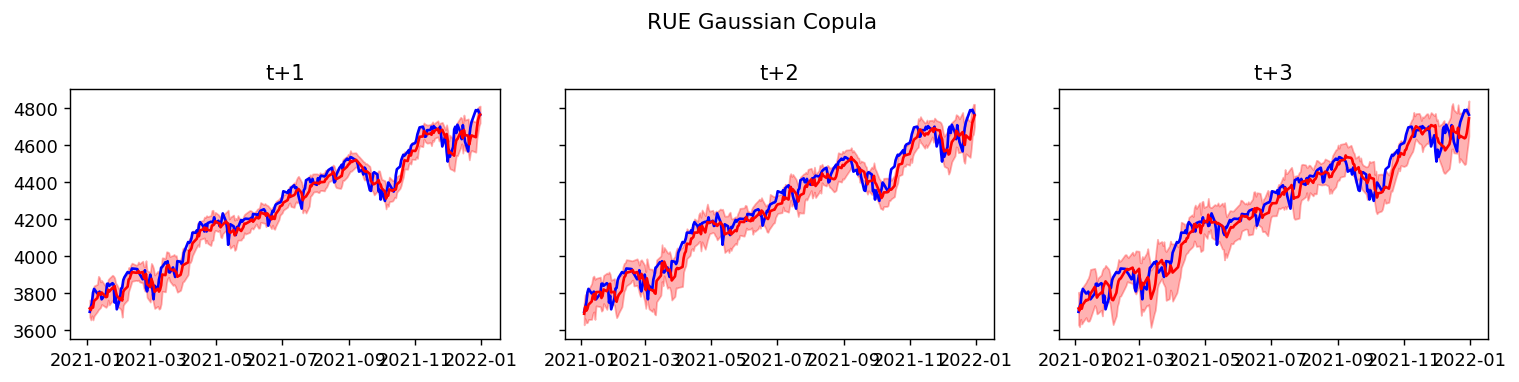

RUE Conditional Gaussian :
U$_t+1_rue_cond_gauss
51.308275902719345
U$_t+2_rue_cond_gauss
68.09458085827625
U$_t+3_rue_cond_gauss
73.40125232921538


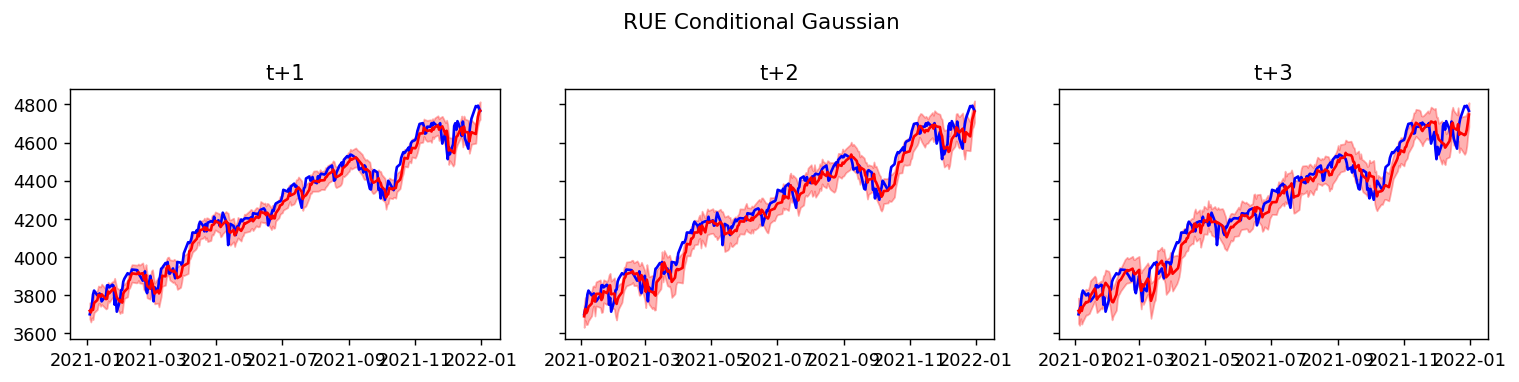

RUE Weighted :
U$_t+1_rue_weighted
39.58893064468626
U$_t+2_rue_weighted
54.43315100291419
U$_t+3_rue_weighted
68.45862155490451


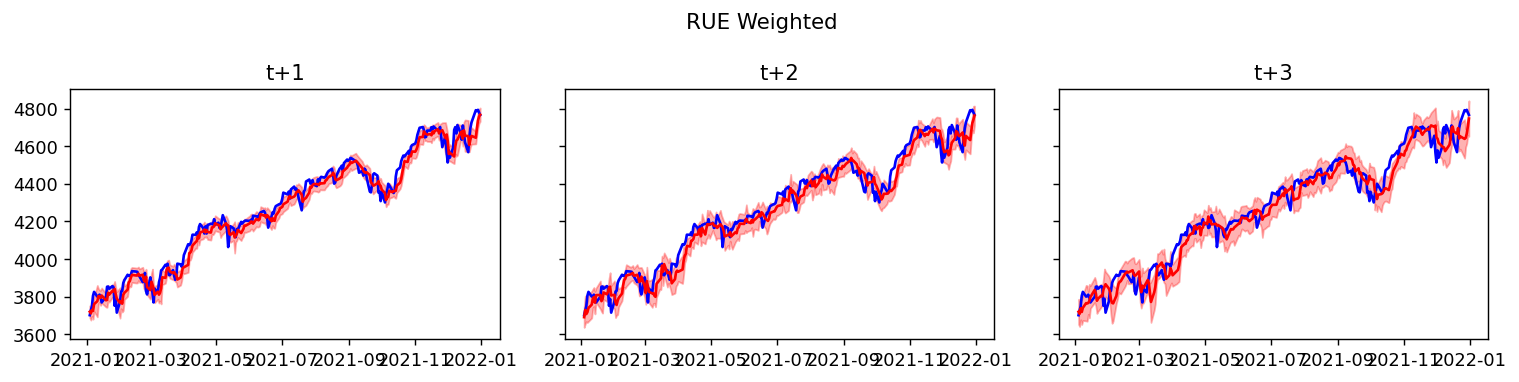

RUE KNN :
U$_t+1_rue_knn
113.805176
U$_t+2_rue_knn
121.97473
U$_t+3_rue_knn
170.57317999999998


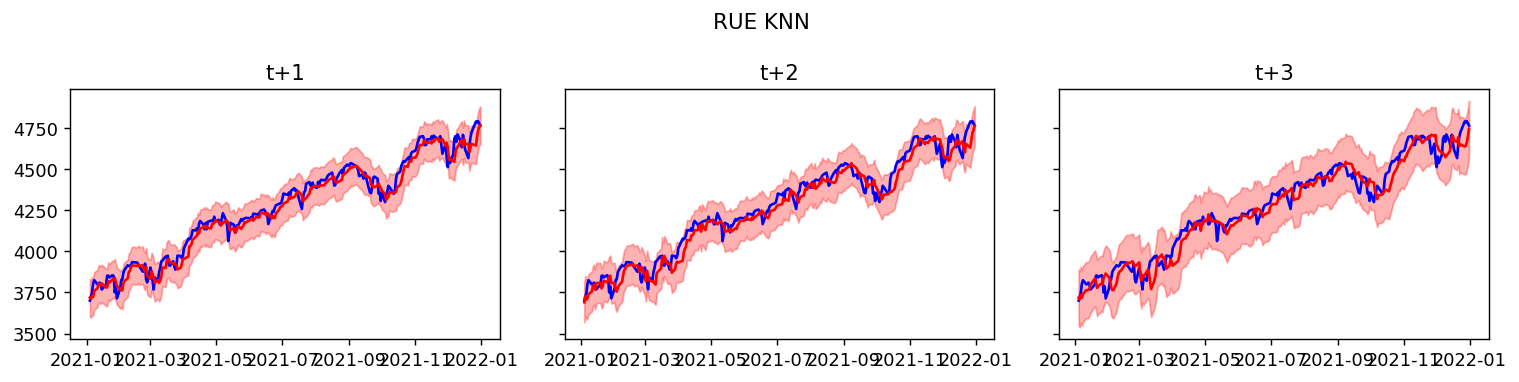

RUE Conformal :
U$_t+1_rue_conformal
71.12988664682538
U$_t+2_rue_conformal
92.2656170277778
U$_t+3_rue_conformal
108.48414747222223


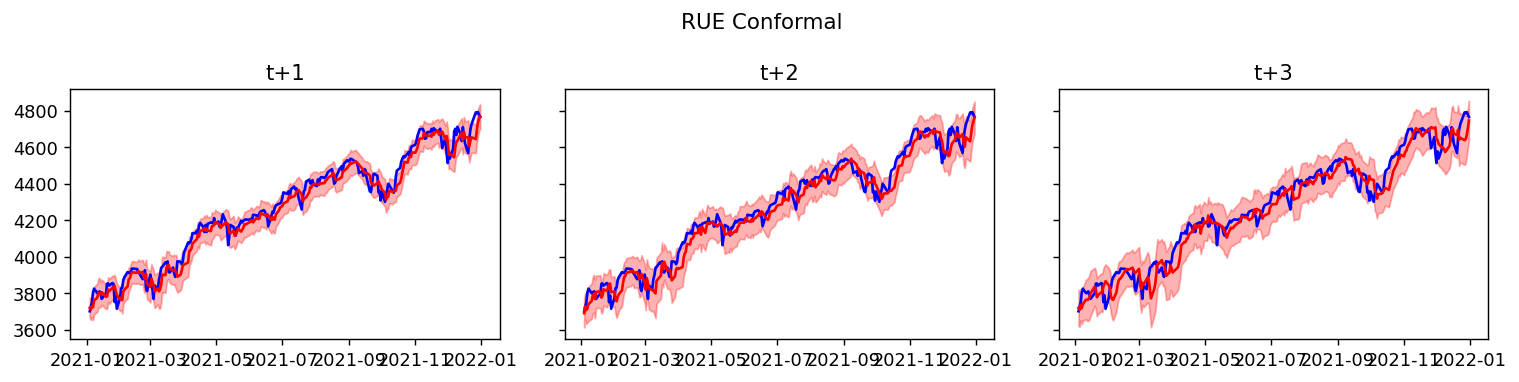

Infer-Noise Conformal :
U$_t+1_infernoise_uncertainty_conformal
39.96450026190476
U$_t+2_infernoise_uncertainty_conformal
56.46827397222222
U$_t+3_infernoise_uncertainty_conformal
63.60533568253968


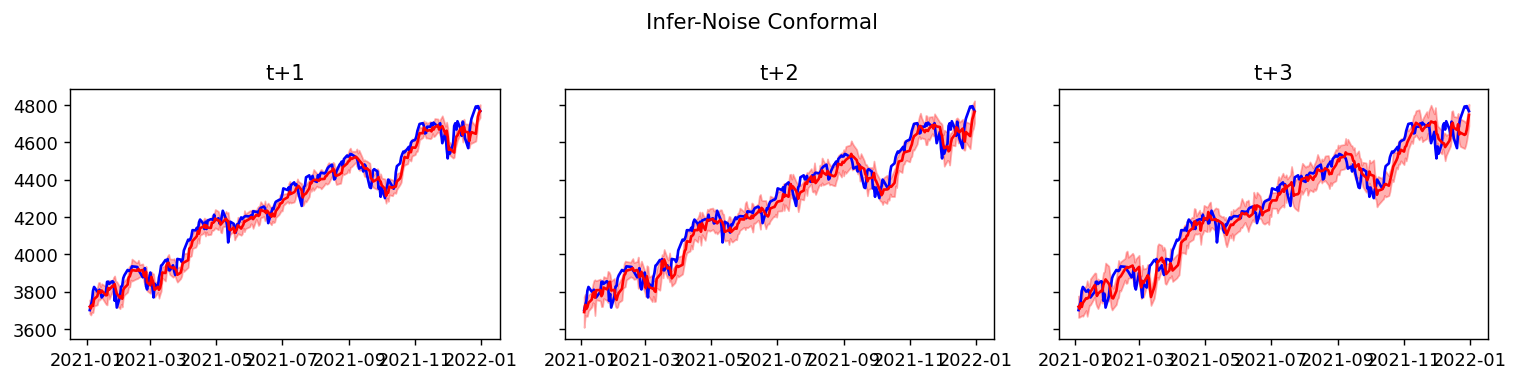

MC Dropout Conformal :
U$_t+1_mcd_conformal
185.30088542460317
U$_t+2_mcd_conformal
225.48420210714286
U$_t+3_mcd_conformal
247.7016454761905


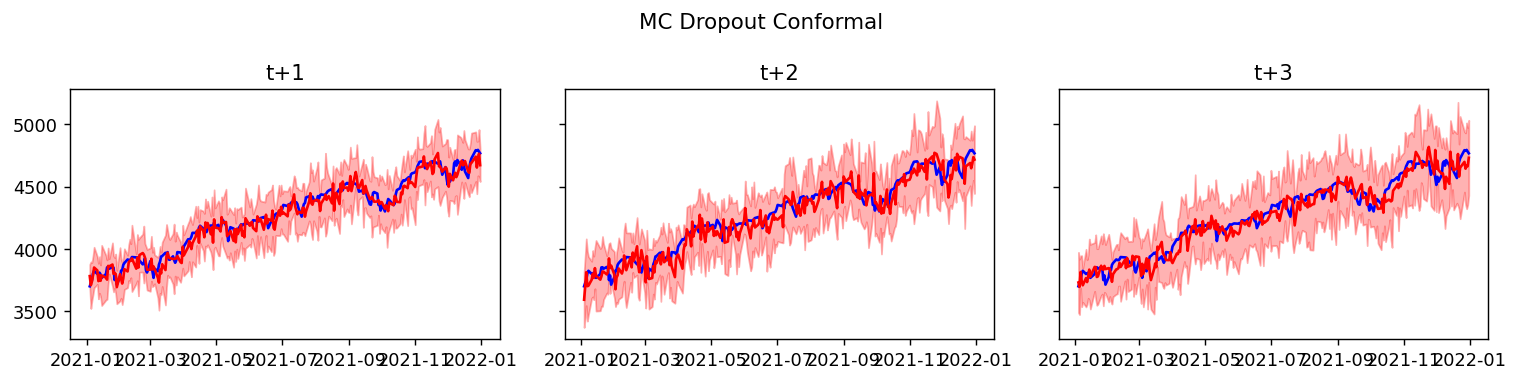

GPR Conformal :
U$_t+1_gpr_std_mean_conformal
74.38514298809524
U$_t+2_gpr_std_mean_conformal
100.65230706349206
U$_t+3_gpr_std_mean_conformal
115.75611132539682


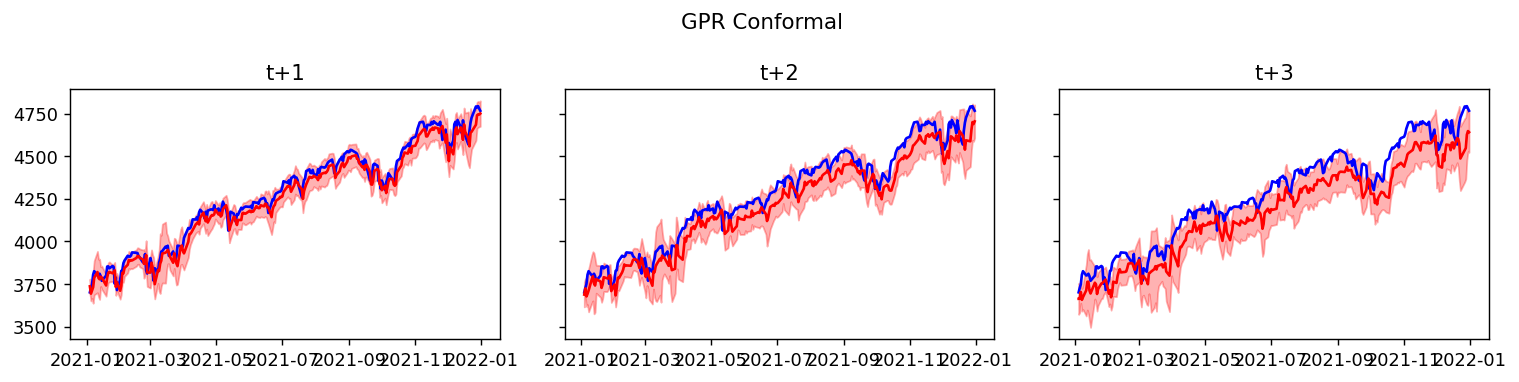

BNN Conformal :
U$_t+1_bnn_uncertainty_conformal
385.8538821825396
U$_t+2_bnn_uncertainty_conformal
356.83808750000003
U$_t+3_bnn_uncertainty_conformal
384.9547975793651


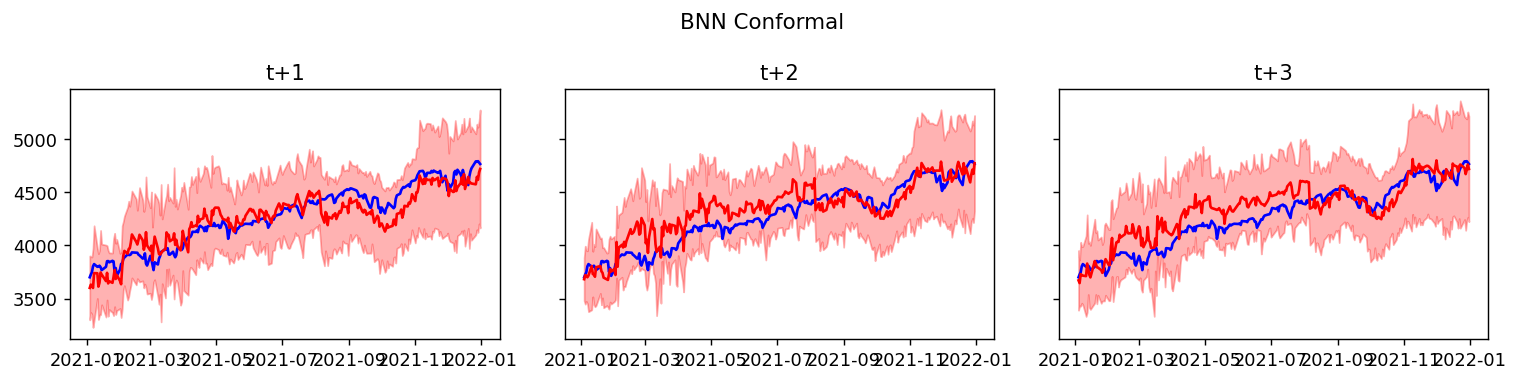

DER Conformal :
U$_t+1_der_uncertainty_conformal
0.24456482000000002
U$_t+2_der_uncertainty_conformal
1.5737057063095237
U$_t+3_der_uncertainty_conformal
0.6960833016666667


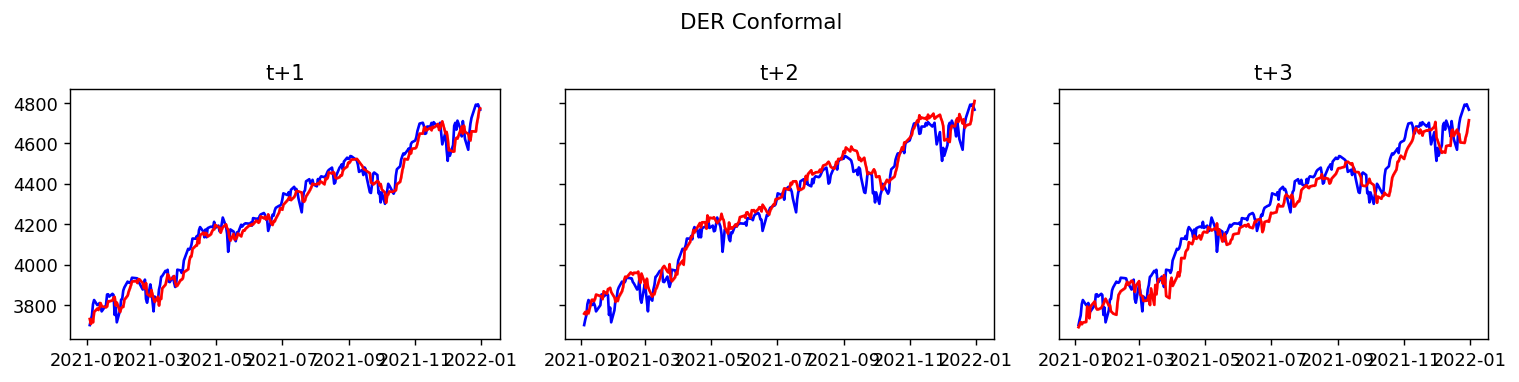

In [51]:
# function to calculate pis
plot_predictions_with_pi(
    df_dict, pi_dict, scaler, seed=seed, dpi=128, save_figs=False,
    year_range=["2021-01-01", "2022-01-01"]
)

#### Line Plot (Compare Across Methods)

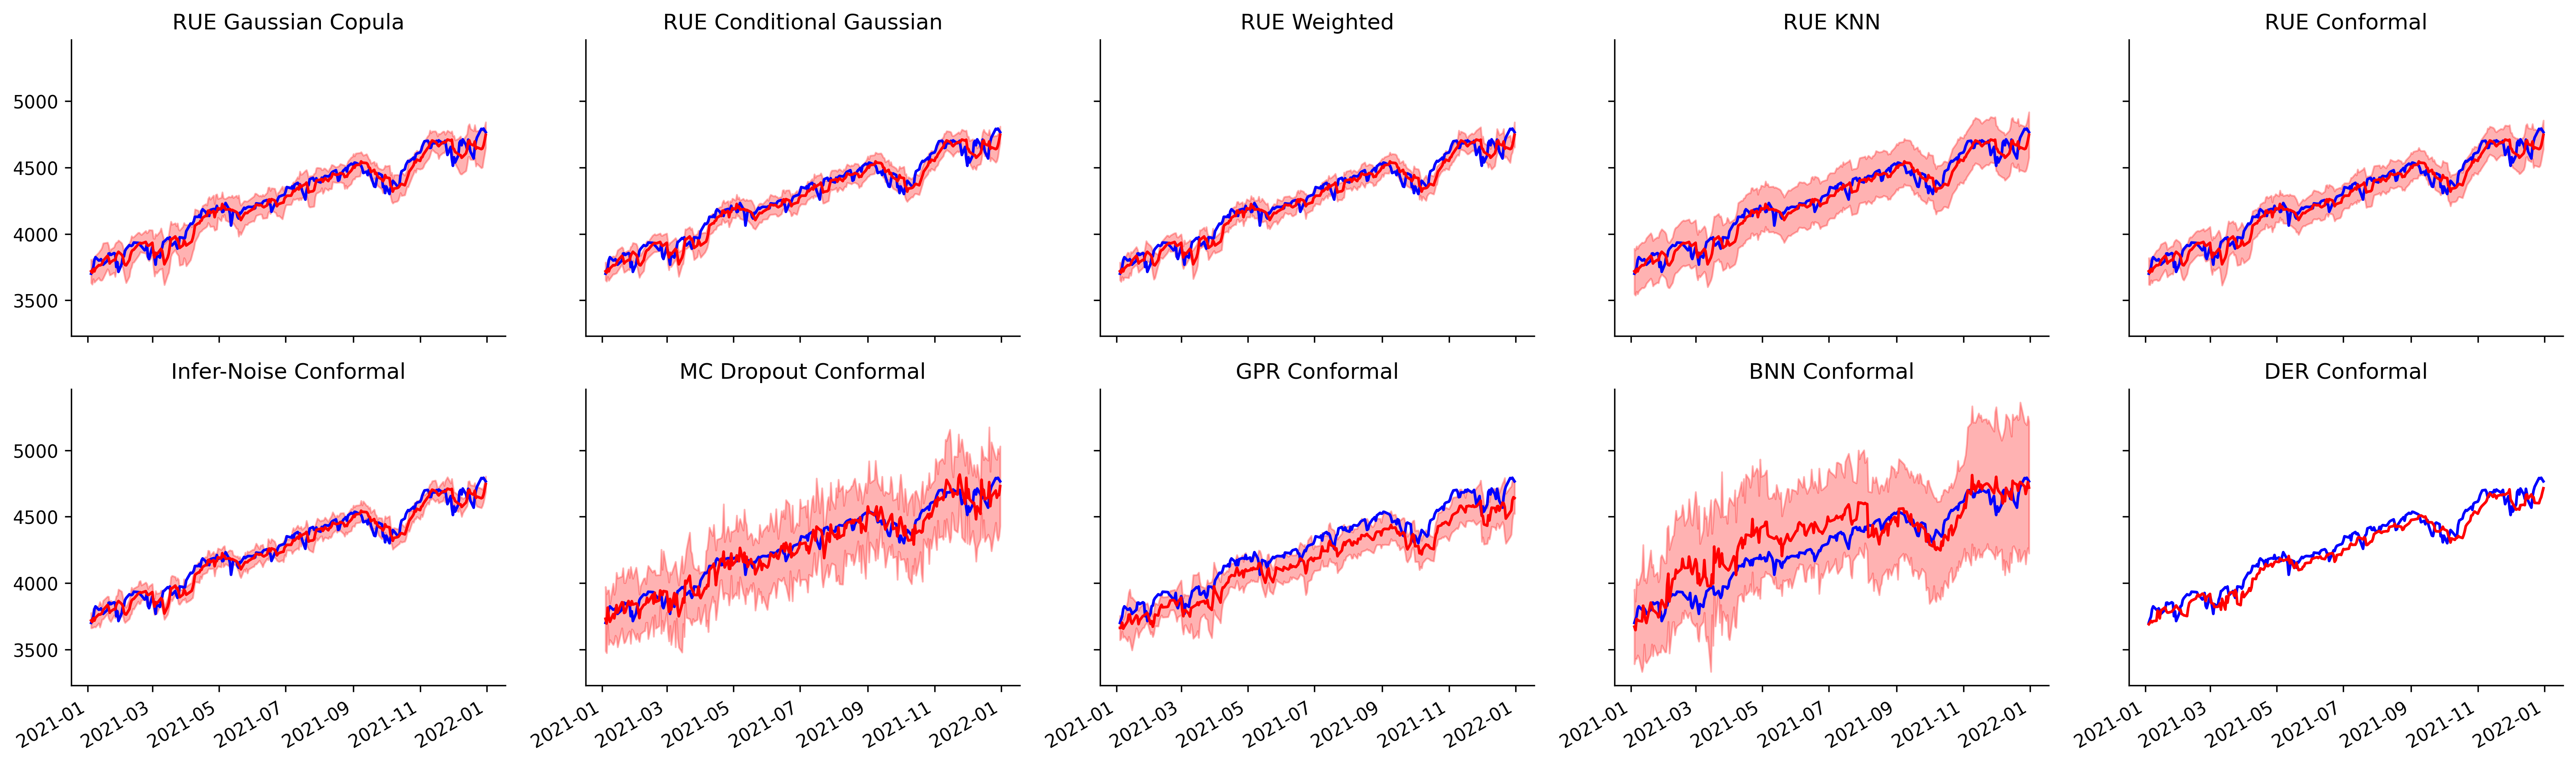

In [77]:
from math import ceil

def plot_predictions_with_pi_across_methods(
    df_dict, pi_dict, scaler, seed, dpi=300, save_fig=False, year_range=None,
    regressor_label = "t+3", num_cols=5
    ):
    fp_fig_folder = os.path.join(fp_project_model_evaluations, str(seed), "pi_line_graphs")
    create_folder(fp_fig_folder)

    features = scaler.feature_names_in_

    num_methods = len(pi_dict)
    num_rows = ceil(num_methods/num_cols)
    
    # Plot for all three methods
    fig, axes = plt.subplots(
        num_rows, num_cols, dpi=dpi, figsize=(4*num_cols, 3*num_rows), sharey=True, sharex="col")
    if num_rows > 1:
        axes = axes.flatten()
    
    # Plots in multiples of three
    for i, (pi_name, pi_info) in enumerate(pi_dict.items()):
        ax = axes[i]
        # print(pi_name, ":")
        pred_label, ue_col, pi_label = pi_info["pred_label"], pi_info["ue_col"], pi_info["pi_label"]

        test_df_info = df_dict[regressor_label]
        test_df = test_df_info["test_df"]
        pred_cols = test_df_info["pred_cols"]
        
        # Only show a range of years
        if year_range is not None:
            test_df = test_df[
                (test_df[f"target_date_{regressor_label}"] >= year_range[0]) &
                (test_df[f"target_date_{regressor_label}"] <= year_range[1]) 
            ]

        #     # Sort columns for display
        zipped_cols = list(zip(features, pred_cols))
        zipped_cols = sorted(zipped_cols, key = lambda x: x[0])
        

        for j, (feature, pred_col) in enumerate(zipped_cols):
            y_pred_col = pred_col+pred_label+"_"+regressor_label

            index = pd.to_datetime(test_df[f"target_date_{regressor_label}"], format="%Y-%m-%d")
            y_true = test_df[pred_col+"_unscaled"].values
            y_pred = test_df[y_pred_col+"_unscaled"].values
            pi = test_df[pred_col+"_"+ue_col+pi_label].values
            
            # Plot predictions and their CI
            ax.plot(index, y_true, color="blue")
            ax.plot(index, y_pred, color="red")
            ax.fill_between(
                index, (y_pred-pi), (y_pred+pi), 
                color='red', alpha=0.3
            )  
            if j!=0:
                ax.set_ylabel(feature)
            ax.set_title(pi_name)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    fig.autofmt_xdate()
    plt.tight_layout()
    if save_fig:
        plt.savefig(os.path.join(fp_fig_folder, f"pi_comparison_across_methods_{regressor_label}.jpg"), bbox_inches="tight")
    plt.show()

plot_predictions_with_pi_across_methods(
    df_dict, pi_dict, scaler, seed=seed, dpi=300, save_fig=True,
    year_range=["2021-01-01", "2022-01-01"]
)

#### Parallel Coordinate Plot

In [ ]:
def plot_pi_metrics_parallel_coordinate(pi_stats, seed, categories=["CovP", "PINAW", "PINAFD"], save_fig=False):
    from matplotlib import cm
    from matplotlib.colors import rgb2hex
    import seaborn as sns
    
    pi_stats = pi_stats.copy().sort_values(by=["Time Horizon", "Method"])
    num_cat = len(categories)
    
    rue_colors = sns.color_palette('spring', n_colors=4)
    other_colors = sns.color_palette('winter', n_colors=3)
    
    # color_list =  other_colors + rue_colors
    color_list = sns.color_palette('rainbow', n_colors=pi_stats["Method"].nunique())
    print(pi_stats["Method"].unique())
    # color_list = [
    #     '#1f77b4',  # muted blue
    #     '#ff7f0e',  # safety orange
    #     '#2ca02c',  # cooked asparagus green
    #     '#d62728',  # brick red
    #     '#9467bd',  # muted purple
    #     '#8c564b',  # chestnut brown
    #     '#e377c2',  # raspberry yogurt pink
    # #     '#7f7f7f',  # middle gray
    # #     '#bcbd22',  # curry yellow-green
    # #     '#17becf'   # blue-teal
    # ]
    
    fig, axes = plt.subplots(1, num_cat, sharey=True, dpi=300, figsize=(num_cat*3, 3))
    xticks = range(num_cat)
    
    for i, (time_horizon_label, time_df) in enumerate(pi_stats.groupby("Time Horizon")):
        time_df[categories] = (time_df[categories]-time_df[categories].min())/(time_df[categories].max()-time_df[categories].min())
        for j, (method_label, method_df) in enumerate(time_df.groupby("Method")):
            # print(method_df[categories].values.flatten())
            axes[i].plot(xticks, method_df[categories].values.flatten(), label=method_label if i==0 else None, linestyle="--" if "RUE" not in method_label else "-")
            axes[i].set_xticks(xticks, categories)
        axes[i].set_title(time_horizon_label)

    reorder=lambda hl,nc:(sum((lis[i::nc]for i in range(nc)),[])for lis in hl)
    h_l = axes[0].get_legend_handles_labels()
    fig.legend(*reorder(h_l, 5), loc='upper center', bbox_to_anchor=(0.5, 0), ncol=5, fontsize=8)
    plt.tight_layout()
    if save_fig:
        fp_fig_folder = os.path.join(fp_project_model_evaluations, str(seed))
        plt.savefig(os.path.join(fp_fig_folder, "parallel_coord.jpg"), bbox_inches="tight")
    

['BNN Conformal' 'DER Conformal' 'GPR Conformal' 'Infer-Noise Conformal'
 'MC Dropout Conformal' 'RUE Conditional Gaussian' 'RUE Conformal'
 'RUE Gaussian Copula' 'RUE KNN' 'RUE Weighted']


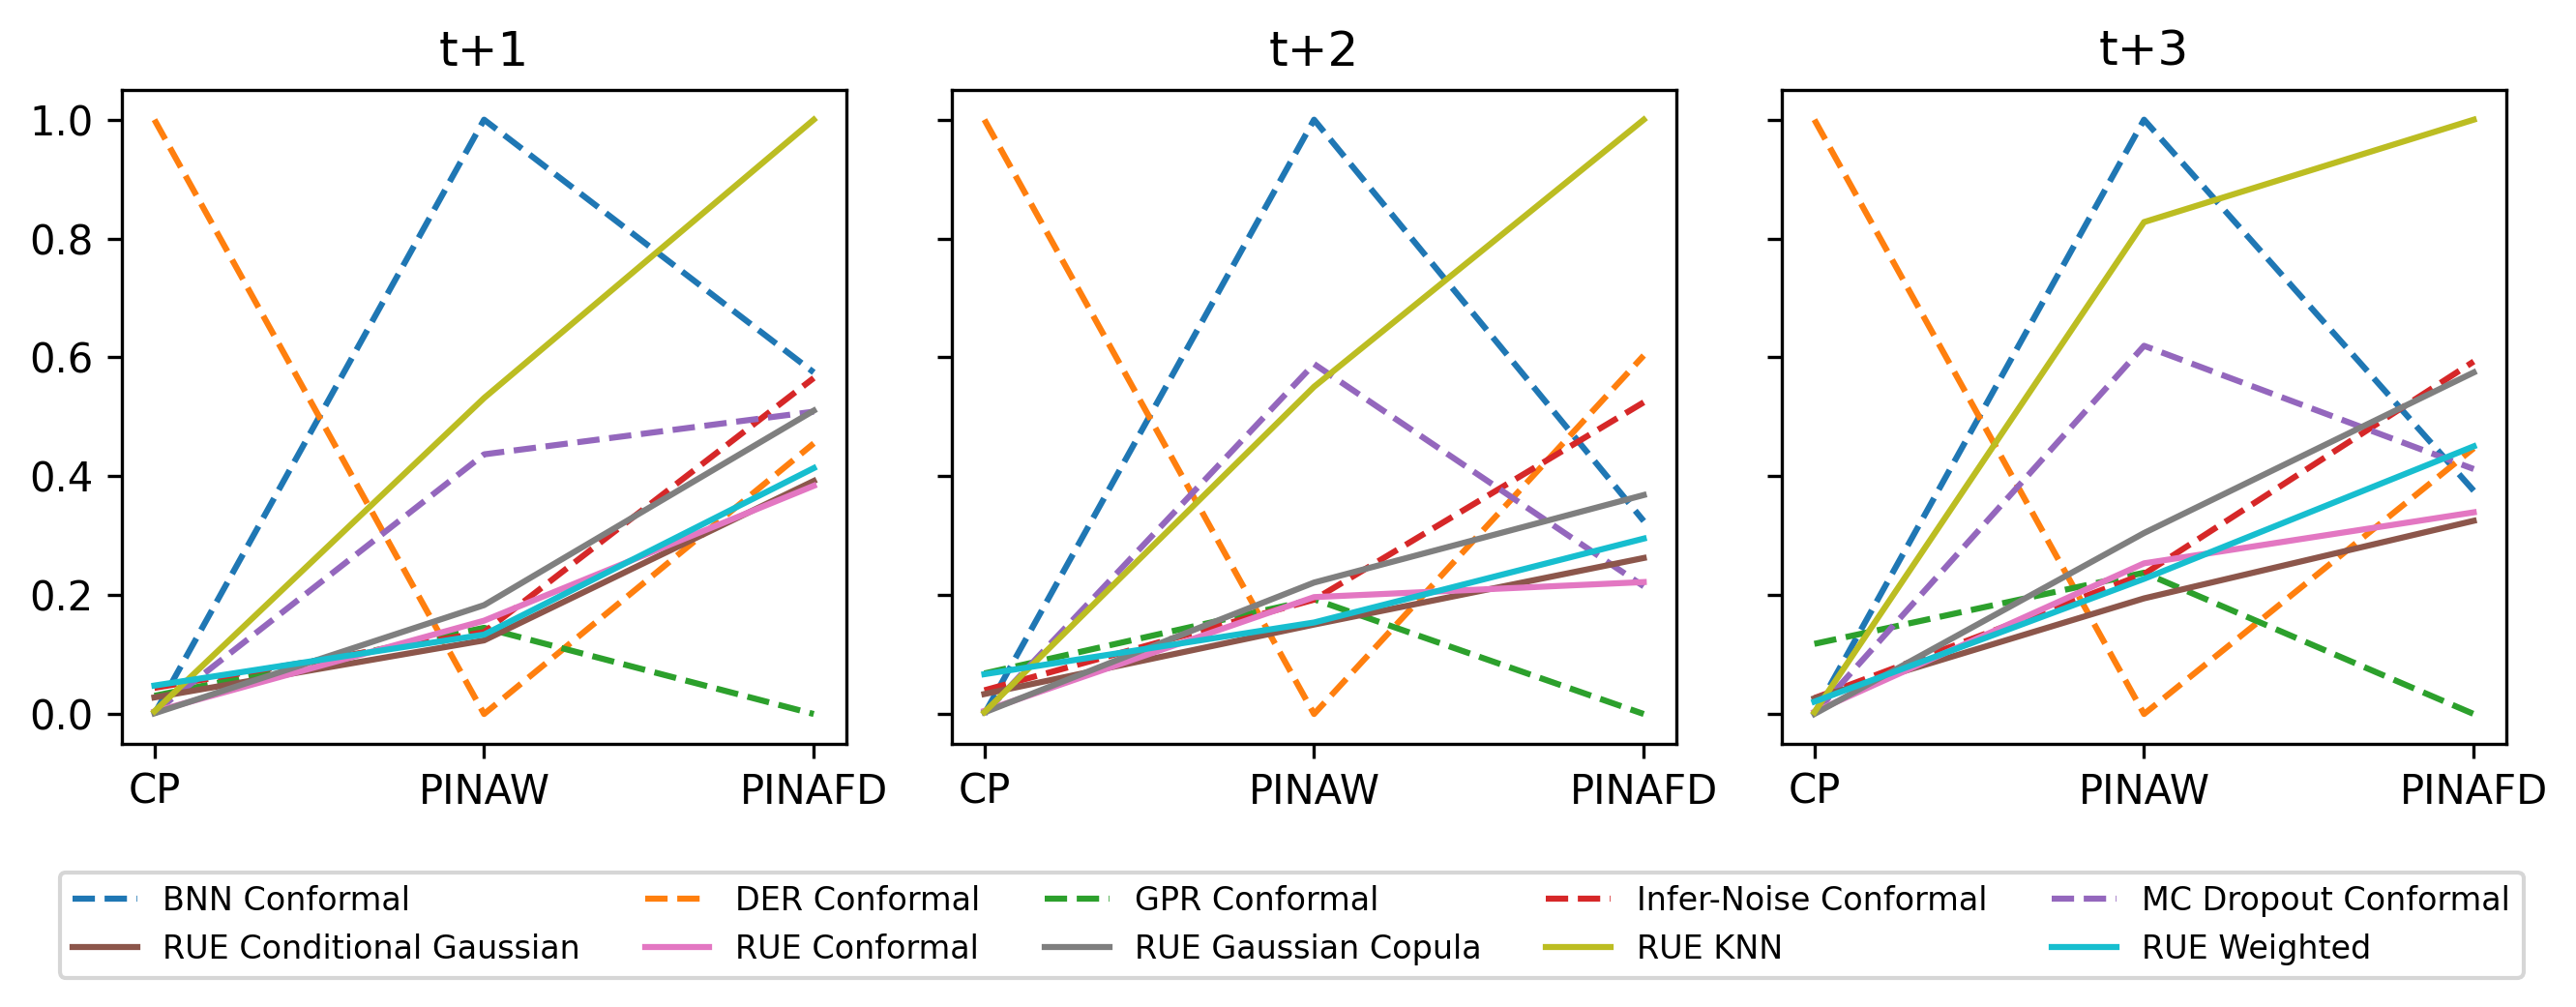

In [ ]:
plot_pi_metrics_parallel_coordinate(pi_stats, seed=seed, categories=["CovP", "PINAW", "PINAFD"], save_fig=True)

#### UE-Error Scatter Plot

In [30]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', pad=0, y=0.975)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

# Scatter plot of rows of t+1, t+2... t+3
# - In each row, we have the scatterplots of each UE
def get_ue_loss_scatterplot(test_df_dict, ue_dict, seed, nbins=10, dpi=300, save_fig=False):
    eqn_label_fs = 7
    line_col = 'black'
    point_color = "#0090C1"
    point_size = 75
    point_alpha = 0.5
    marker = "."
    formatting_dict = dict(color=point_color, s=point_size, alpha=point_alpha, marker=marker, edgecolors='none')
    
    bin_width = int(100/nbins)
    num_cols = len(ue_dict)
    num_rows = len(test_df_dict) # num intervals
    #, constrained_layout=True
    # fig, axes = plt.subplots(num_rows*2, num_cols, dpi=dpi, figsize=(num_cols*4, 1.5*2*num_rows)) # , sharey="row", sharex="col"
    fig = plt.figure(dpi=dpi, figsize=(num_cols*3, 2*2*num_rows))
    grid = fig.add_gridspec(num_rows, 1, height_ratios=[1 for i in range(num_rows)], hspace=0.3)
    
    # For all time intervals 
    for time_i ,(regressor_label, test_df_info) in enumerate(test_df_dict.items()):
        cur_gs = grid[time_i].subgridspec(2, num_cols, wspace=0, hspace=0.1)
        axes = cur_gs.subplots(sharey='row', sharex='col')
        test_df = test_df_info["test_df"]
        pred_cols = test_df_info["pred_cols"]
        y_true = test_df[pred_cols].values

        create_subtitle(fig, grid[time_i, ::], regressor_label)
        # For each ue 
        for ue_i, (ue_type, ue_info) in enumerate(ue_dict.items()):
            
            ue_df = test_df.copy()
            
            pred_label = ue_info["pred_label"]
            ue_col = ue_info["ue_col"]

            # Get error and UE cols
            y_pred_cols = [col+pred_label+"_"+regressor_label for col in pred_cols]
            y_pred = test_df[y_pred_cols].values
            ue = test_df[ue_col].values
            loss = np.mean(np.abs(y_true-y_pred), axis=1)
            ue_df["loss"] = loss

            # Normalise UE
            ue = min_max_norm_wo_outliers(ue)
            ue_df[ue_col] = ue
            max_range = round(max(ue), 1)
            bin_edges = np.array([0]+list(np.linspace(bin_width, int(max_range*100), num=int(max_range*10))/100))
            
            # Plot scatter
            scatter_ax = axes[0, ue_i]
            scatter_ax.axvspan(0, bin_width/100, color='grey', alpha=0.2, linewidth=0)
            scatter_ax.scatter(ue, loss, **formatting_dict)
            # Plot line
            m, c = np.polyfit(ue, loss, 1) 
            ue = np.sort(ue)
            scatter_ax.plot(ue, m*ue+c, color=line_col, linestyle='-', label=f'y = {m:.3f}x + {c:.3f}', linewidth=1.5)
            scatter_ax.legend(fontsize=eqn_label_fs)
            if ue_i == 0:
                axes[0, ue_i].set_ylabel("MAE")
                
            # Plot Barplot
            ue_df['bin'] = pd.cut(ue_df[ue_col], bins=bin_edges, labels=bin_edges[1:], include_lowest=True, right=True)
            grouped = ue_df.groupby("bin", observed=False)
            grouped_loss = grouped["loss"].mean()
            # Comparison of losses
            bar_ax = axes[1, ue_i]
            bar_ax.bar(
                bin_edges[1:]-bin_width/100/2, grouped_loss, width=bin_width/100*0.9, color="#0090C1")
            ticks = list(axes[1, ue_i].get_yticks(minor=True)) + [grouped_loss[0.1]]
            bar_ax.set_yticks(ticks, minor=True)
            if ue_i == 0:
                bar_ax.set_ylabel("Mean MAE")
            bar_ax.set_xlabel(ue_type)

    if save_fig:
        fp_fig_folder = os.path.join(fp_project_model_evaluations, str(seed))
        plt.savefig(os.path.join(fp_fig_folder, "ue_error_scatter.jpg"), bbox_inches="tight")


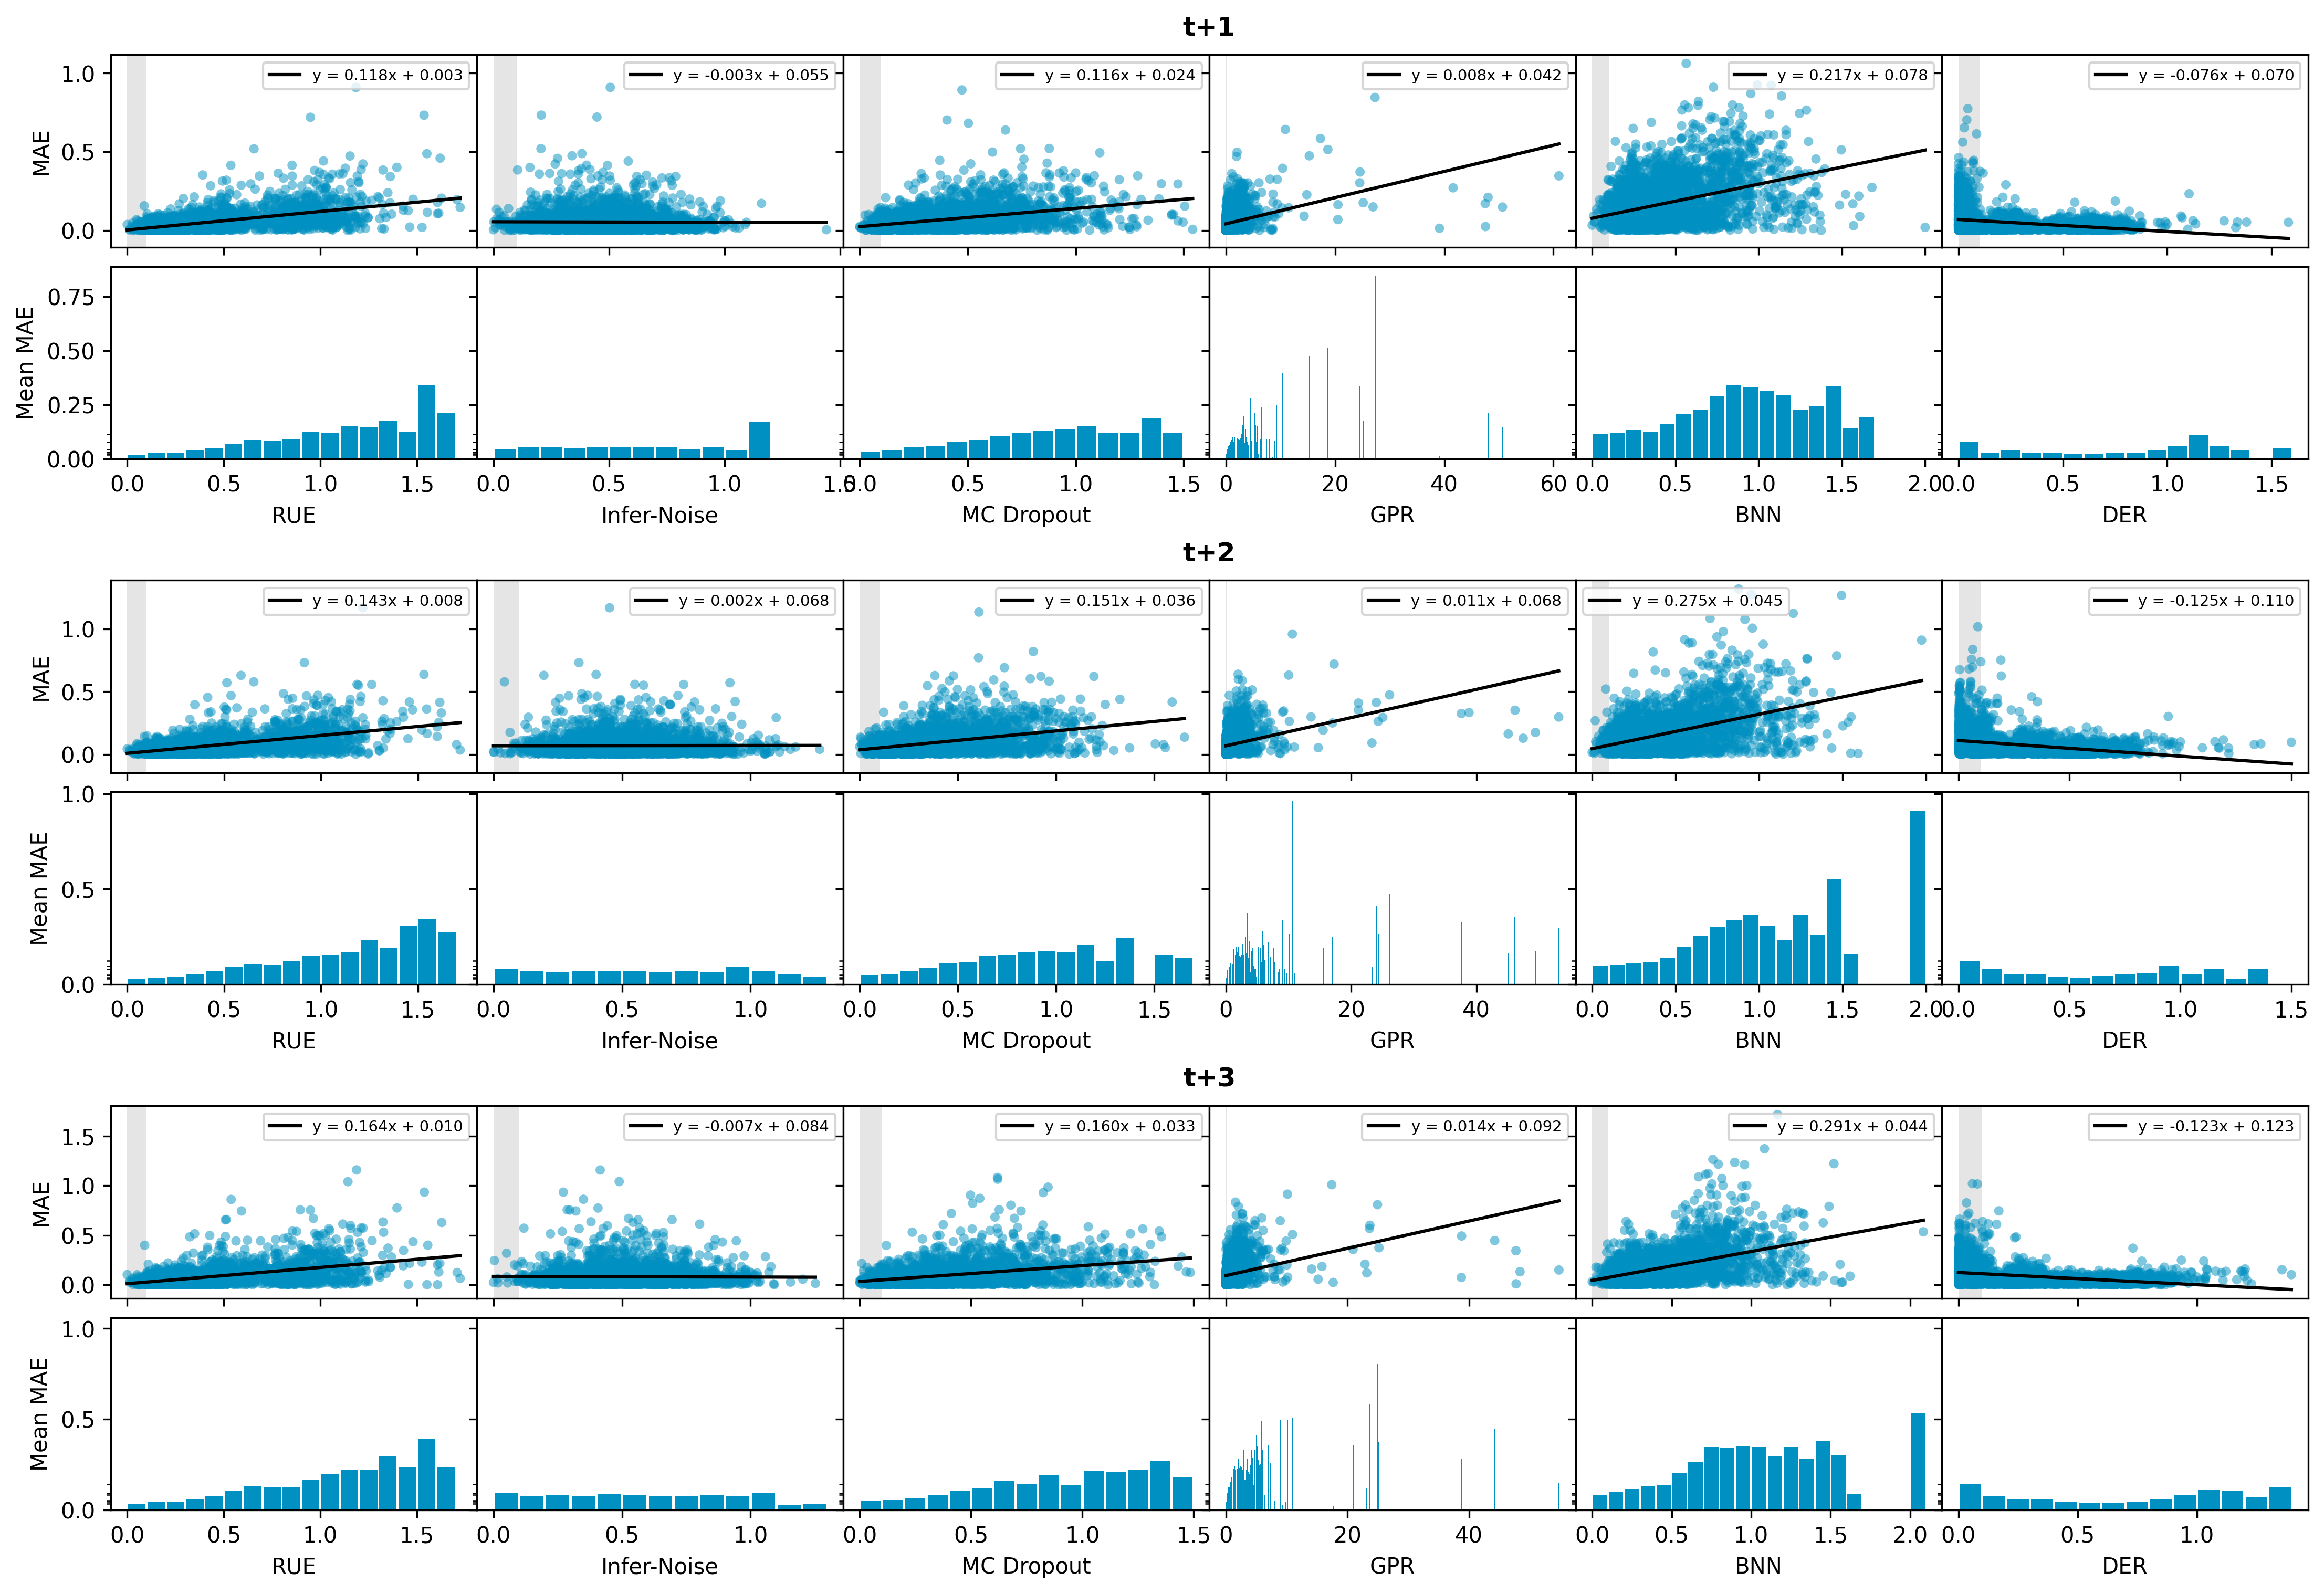

In [31]:
ue_dict = {
    "RUE": {
        "pred_label": "_direct", "ue_col": "rue", 
    },
    "Infer-Noise": {
        "pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", 
    },
    "MC Dropout": {
        "pred_label": "_mean", "ue_col": "mcd", 
    },
    "GPR": {
        "pred_label": "_gpr", "ue_col": "gpr_std_mean", 
    },
    "BNN": {
        "pred_label": "_bnn", "ue_col": "bnn_uncertainty", 
    },
    "DER": {
        "pred_label": "_der", "ue_col": "der_uncertainty", 
    },
}    
get_ue_loss_scatterplot(df_dict, ue_dict, seed=seed, dpi=300, save_fig=True)

#### Starplot

In [ ]:
def plot_pi_metrics_starplot(pi_stats, categories=pi_stats.columns.tolist()[2:-2]):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    from plotly.colors import hex_to_rgb
    fig = make_subplots(
        rows=1, cols=pi_stats["Time Horizon"].nunique(),
        specs=[[{"type": "scatterpolar"}, {"type": "scatterpolar"}, {"type": "scatterpolar"}]], 
        subplot_titles=pi_stats["Time Horizon"].unique()
    )
    pi_stats = pi_stats.copy()
    color_list = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
    #     '#7f7f7f',  # middle gray
    #     '#bcbd22',  # curry yellow-green
    #     '#17becf'   # blue-teal
    ]
    
    for i, (time_horizon_label, time_df) in enumerate(pi_stats.groupby("Time Horizon")):
        # time_df[categories] = (time_df[categories]-time_df[categories].min())/(time_df[categories].max()-time_df[categories].min())
        time_df[categories] = time_df[categories]/time_df[categories].max()
        # time_df[categories] = np.log(time_df[categories])
        for j, (method_label, method_df) in enumerate(time_df.groupby("Method")):
            cur_col = list(hex_to_rgb(color_list[j]))
            cur_fill_col = f'rgba({cur_col[0]}, {cur_col[1]}, {cur_col[2]}, 0.3)'
            cur_outline_col = f'rgba({cur_col[0]}, {cur_col[1]}, {cur_col[2]}, 0.8)'
            fig.append_trace(
                go.Scatterpolar(
                      r=method_df[categories].values[0],
                      theta=categories,
                      fill='toself',
                      name=method_label if i==0 else None,
                      fillcolor=cur_fill_col,
                      marker=dict(color=cur_outline_col, line=dict(
                            color=color_list[j],
                            width=1
                        ),
                    ),
                    showlegend=i==0
                ), row=1, col=i+1
            )

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
              visible=False,
            )
        ),
        polar2=dict(
            radialaxis=dict(
              visible=False,
            )
          ),
        polar3=dict(
            radialaxis=dict(
              visible=False,
            )
      ),
      showlegend=True, 
      width=850,  
      height=350,
      title_x=0.5,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            xanchor="center",
            y=-0.5,
            x=0.5,
            entrywidth=180
        )
    )
#     fig.show()
    return fig
        
plot_pi_metrics_starplot(pi_stats, categories=pi_stats.columns.tolist()[3:-1])

## Repeat Experiment

In [ ]:
hp_seed = 2023

def train_rue_n_predictor(seed, data_dict, override_checkpoints, testing):
    # Load Best HP
    all_rue_decoder_best_hp = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_rue_decoder_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"rue_{time_label}")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Get best hyperparameter
                best_hp = all_rue_decoder_best_hp[time_label]
                # Train model
                ae_regressor = model_training(
                    best_hp, predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
                    train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed,
                    batch_size=batch_size, max_epochs=10000 if not testing else 1, verbose=1, patience=20
                ) 
                # Save model
                save_model(
                    model=ae_regressor, name=f"rue_{time_label}", 
                    fp_checkpoints=os.path.join(fp_project_models, str(seed)), override=True)
            else:
                print(f"- Skip {time_label} Training")

def predict_rue_n_predictor(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"rue_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                rue_valid_df = model_test_predictions(
                    ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["valid_df"], 
                    pred_cols=time_info_dict["outputs"], predictors=feat_cols, 
                    regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10 if not testing else 2, seed=seed
                )
                rue_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set 
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"rue_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                rue_test_df = model_test_predictions(
                    ae_regressor, df_train=time_info_dict["train_df"], df_test=time_info_dict["test_df"], 
                    pred_cols=time_info_dict["outputs"], predictors=feat_cols, 
                    regressor_label="_"+time_label, pred_min=int(time_label[-1]), T=10 if not testing else 2, seed=seed
                )
                rue_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")
            
def train_gpr(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"gpr_{time_label[-1]}")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Train model
                gpr = model_training_gpr( 
                    predictors=feat_cols, pred_cols=time_info_dict["outputs"], 
                    train_df=time_info_dict["train_df"], valid_df = time_info_dict["valid_df"], seed=seed
                ) 
                # Save model
                save_model_gpr(model=gpr, name=f"gpr_{time_label[-1]}", fp_checkpoints=os.path.join(fp_project_models, str(seed)), predictors=feat_cols)
            else:
                print(f"- Skip {time_label} Training")

def predict_gpr(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            gpr = load_model_gpr(name=f"gpr_{time_label[-1]}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"gpr_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                gpr_valid_df = model_test_predictions_gpr(
                    gpr=gpr, df_test=time_info_dict["valid_df"], pred_cols=time_info_dict["outputs"], 
                    predictors=feat_cols, regressor_label=f"_{time_label}", pred_min=int(time_label[-1]), seed=seed)
                gpr_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"gpr_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                gpr_test_df = model_test_predictions_gpr(
                    gpr=gpr, df_test=time_info_dict["test_df"], pred_cols=time_info_dict["outputs"], 
                    predictors=feat_cols, regressor_label=f"_{time_label}", pred_min=int(time_label[-1]), seed=seed)
                gpr_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")    
                
def predict_infernoise(seed, data_dict, override_checkpoints, testing):
    # Load best hp for infernoise
    infernoise_hp_dict = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_infernoise_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            ae_regressor = load_model(name=f"rue_{time_label}", fp_checkpoints=os.path.join(fp_project_models, str(seed)))
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"infernoise_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                infernoise_valid_df = infernoise_test_predictions(
                     ae_regressor, test_df=time_info_dict["valid_df"], inputs=feat_cols, outputs=time_info_dict["outputs"], regressor_label="_"+time_label, 
                     seed=seed, T=10 if not testing else 2, stddev=infernoise_hp_dict[time_label]
                ) 
                infernoise_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"infernoise_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                infernoise_test_df = infernoise_test_predictions(
                     ae_regressor, test_df=time_info_dict["test_df"], inputs=feat_cols, outputs=time_info_dict["outputs"], regressor_label="_"+time_label, 
                     seed=seed, T=10 if not testing else 2, stddev=infernoise_hp_dict[time_label]
                ) 
                infernoise_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")    

def train_bnn(seed, data_dict, override_checkpoints, testing):
    # Load Best HP
    all_bnn_best_hp = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_bnn_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Get best hyperparameter
                bnn_best_hp = all_bnn_best_hp[time_label]
                # Train model
                bnn_model = train_model_w_best_param(
                    best_param=bnn_best_hp, train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
                    feat_cols=feat_cols, target_cols=time_info_dict["outputs"],
                    epochs=500 if not testing else 1, patience=5, seed=seed, fp_model=fp_model
                )
            else:
                print(f"- Skip {time_label} Training")

def predict_bnn(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            fp_model = os.path.join(fp_project_models, str(seed), f"bnn_{time_label}.pt")
            bnn_model = torch.load(fp_model)
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"bnn_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                bnn_valid_df = bnn_model_prediction(
                    bnn_model, time_info_dict["valid_df"], 
                    feat_cols=feat_cols, target_cols=time_info_dict["outputs"], 
                    T=10 if not testing else 2, seed=seed, regressor_label=time_label)
                bnn_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set 
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"bnn_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                bnn_test_df = bnn_model_prediction(
                    bnn_model, time_info_dict["test_df"], 
                    feat_cols=feat_cols, target_cols=time_info_dict["outputs"], 
                    T=10 if not testing else 2, seed=seed, regressor_label=time_label)
                bnn_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")

def train_der(seed, data_dict, override_checkpoints, testing):
    # Load Best HP
    all_der_best_hp = joblib.load(os.path.join(fp_tuning, str(hp_seed), "all_der_best_hp.joblib"))
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
            # Check if fp_model exists
            if override_checkpoints or not os.path.exists(fp_model):
                # Get best hyperparameter
                best_hp = all_der_best_hp[time_label]
                # Train model
                der_model, _ = train_der_w_param(
                    **best_hp, train_df=time_info_dict["train_df"], valid_df=time_info_dict["valid_df"], 
                    inputs=feat_cols, outputs=time_info_dict["outputs"],
                    seed=seed, max_epochs= 500 if not testing else 1, patience=5
                )
                torch.save(der_model, fp_model)
            else:
                print(f"- Skip {time_label} Training")

def predict_der(seed, data_dict, override_checkpoints, testing):
    with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
        for time_label, time_info_dict in pbar:
            pbar.set_description(time_label)
            # Load model
            fp_model = os.path.join(fp_project_models, str(seed), f"der_{time_label}.pt")
            der_model = torch.load(fp_model)
            # Check if we have predicted on the validation set
            fp_valid_df = os.path.join(fp_project_predictions, str(seed), f"der_valid_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_valid_df):
                der_valid_df = der_model_prediction(
                    der_model, test_df=time_info_dict["valid_df"], 
                    feat_cols=feat_cols, target_cols=time_info_dict["outputs"], 
                    seed=seed, silent=False, regressor_label=time_label)
                der_valid_df.to_csv(fp_valid_df)
            else:
                print(f"- Skip {time_label} Validation Prediction")
                
            # Check if we have predicted on the testing set 
            fp_test_df = os.path.join(fp_project_predictions, str(seed), f"der_test_{time_label[-1]}.csv")
            if override_checkpoints or not os.path.exists(fp_test_df):
                der_test_df = der_model_prediction(
                    der_model, test_df=time_info_dict["test_df"], 
                    feat_cols=feat_cols, target_cols=time_info_dict["outputs"], 
                    seed=seed, silent=False, regressor_label=time_label)
                der_test_df.to_csv(fp_test_df)
            else:
                print(f"- Skip {time_label} Testing Prediction")
                
def save_df_dict_fast(df_dict, seed):
    fp_df_dict = os.path.join(fp_project_pi_predictions, str(seed), "df_dict.joblib")
    joblib.dump(df_dict, fp_df_dict)

def load_df_dict_fast( seed):
    fp_df_dict = os.path.join(fp_project_pi_predictions, str(seed), "df_dict.joblib")
    return joblib.load(fp_df_dict)

def retrieve_history_file(seed):
    fp_history = os.path.join(fp_project_pi_predictions, str(seed), "df_dict_history.joblib")
    if os.path.exists(fp_history):
        return joblib.load(fp_history)
    else:
        return []

def add_to_pi_history_file(event, seed):
    fp_history = os.path.join(fp_project_pi_predictions, str(seed), "df_dict_history.joblib")
    if not os.path.exists(fp_history):
        history = set(event)
    else:
        history = joblib.load(fp_history)
        history.add(event)
    joblib.dump(history, fp_history)
    
def create_df_dict(seed, data_dict, override_checkpoints, testing):
    event = "creation"
    history = retrieve_history_file(seed)
    if (override_checkpoints) or (event not in history):
        df_dict = {}
        with tqdm(data_dict.items(), total=len(data_dict)) as pbar:
            for time_label, time_info_dict in pbar:
                df_dict[time_label] = {
                    "valid_df": load_all_predictions(time_label=int(time_label[-1]), split="valid", seed=seed),
                    "test_df": load_all_predictions(time_label=int(time_label[-1]), split="test", seed=seed),
                    "pred_cols": time_info_dict["outputs"]
                }
        save_df_dict_fast(df_dict, seed)
        add_to_pi_history_file(event, seed)
    else:
        print(f"- Skip df_dict creation!")

def generate_prediction_interval(seed, data_dict, override_checkpoints, testing, 
                                 event, pi_func, ue_dict):
    history = retrieve_history_file(seed)
    if (override_checkpoints) or (event not in history):
        df_dict = load_df_dict_fast(seed)
        scaler = load_scaler(fp_scaler)
        for time_label, time_info in df_dict.items():
            val_df, test_df, pred_cols = time_info["valid_df"], time_info["test_df"], time_info["pred_cols"]
            for ue_label, ue_info in ue_dict.items():
                pred_label, ue_col = ue_info["pred_label"], ue_info["ue_col"]
                df_dict[time_label]["test_df"] = pi_func(
                    df_val=df_dict[time_label]["valid_df"], df_test=df_dict[time_label]["test_df"], predictors=feat_cols, pred_cols=pred_cols, 
                    pred_label=pred_label, regressor_label=time_label, ue_col=ue_col, scaler=scaler, seed=seed
                )
        save_df_dict_fast(df_dict, seed)
        add_to_pi_history_file(event, seed)
    else:
        print(f"- Skip {event} PI!")

def generate_knn_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="knn", pi_func=knn_prediction_interval, ue_dict=ue_dict)

def generate_weighted_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="weighted", pi_func=weighted_prediction_interval, ue_dict=ue_dict)

def generate_conditional_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="conditional", pi_func=cond_gauss_prediction_interval, ue_dict=ue_dict)

def generate_copula_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {"RUE": {"pred_label": "_direct", "ue_col": "rue"}} 
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="copula", pi_func=gauss_copula_prediction_interval, ue_dict=ue_dict)

def generate_conformal_pi(seed, data_dict, override_checkpoints, testing):
    ue_dict = {
        "RUE": {"pred_label": "_direct", "ue_col": "rue"},
        "MC Dropout": {"pred_label": "_mean", "ue_col": "mcd", },
        "GPR": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", },
        "Infer-Noise": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", },
        "BNN": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", },
        "DER": {"pred_label": "_der", "ue_col": "der_uncertainty", }
    }   
    generate_prediction_interval(
        seed, data_dict, override_checkpoints, testing, 
        event="conformal", pi_func=conformal_prediction_interval, ue_dict=ue_dict)

def evaluate_model_perf(seed, data_dict, override_checkpoints, testing):
    df_dict = load_df_dict_fast(seed)
    ue_dict = {
        "RUE": {"pred_label": "_direct", "ue_col": "rue"},
        "MC Dropout": {"pred_label": "_mean", "ue_col": "mcd", },
        "GPR": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", },
        "Infer-Noise": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", },
        "BNN": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", },
        "DER": {"pred_label": "_der", "ue_col": "der_uncertainty", }
    }   
    fp_pred_perf = os.path.join(fp_project_model_evaluations, str(seed), "pred_perf.csv")
    if override_checkpoints or not os.path.exists(fp_pred_perf):
        pred_perf_df = get_prediction_performance_table(df_dict, ue_dict)
        display(pred_perf_df)
        pred_perf_df.to_csv(fp_pred_perf)
    else:
        print(f"- Skip prediction performance evaluation!")

def evaluate_ue_perf(seed, data_dict, override_checkpoints, testing):
    df_dict = load_df_dict_fast(seed)
    ue_dict = {
        "RUE": {"pred_label": "_direct", "ue_col": "rue"},
        "MC Dropout": {"pred_label": "_mean", "ue_col": "mcd", },
        "GPR": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", },
        "Infer-Noise": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", },
        "BNN": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", },
        "DER": {"pred_label": "_der", "ue_col": "der_uncertainty", }
    }   
    fp_ue_perf = os.path.join(fp_project_model_evaluations, str(seed), "ue_perf.csv")
    if override_checkpoints or not os.path.exists(fp_ue_perf):
        ue_perf_df = get_ue_performance_table(df_dict, ue_dict)
        display(ue_perf_df)
        ue_perf_df.to_csv(fp_ue_perf)
    else:
        print(f"- Skip UE performance evaluation!")

    fp_ue_scatter = os.path.join(fp_project_model_evaluations, str(seed), "ue_error_scatter.jpg")
    if override_checkpoints or not os.path.exists(fp_ue_scatter):
        get_ue_loss_scatterplot(df_dict, ue_dict, seed=seed, dpi=300, save_fig=True)
    else:
        print(f"- Skip UE-Error Scatter Plot!")

def evaluate_pi_perf(seed, data_dict, override_checkpoints, testing):
    override_checkpoints = True
    df_dict = load_df_dict_fast(seed)
    scaler = load_scaler(fp_scaler)
    pi_dict = {
        "RUE Gaussian Copula": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_gauss_copula"},
        "RUE Conditional Gaussian": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_cond_gauss"},
        "RUE Weighted": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_weighted"},
        "RUE KNN": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_knn"},
        "RUE Conformal": {"pred_label": "_direct", "ue_col": "rue", "pi_label": "_conformal"},
        "Infer-Noise Conformal": {"pred_label": "_infernoise", "ue_col": "infernoise_uncertainty", "pi_label": "_conformal"},
        "MC Dropout Conformal": {"pred_label": "_mean", "ue_col": "mcd", "pi_label": "_conformal"},
        "GPR Conformal": {"pred_label": "_gpr", "ue_col": "gpr_std_mean", "pi_label": "_conformal"},
        "BNN Conformal": {"pred_label": "_bnn", "ue_col": "bnn_uncertainty", "pi_label": "_conformal"},
        "DER Conformal": {"pred_label": "_der", "ue_col": "der_uncertainty", "pi_label": "_conformal"},
    }   
    fp_pi_perf = os.path.join(fp_project_model_evaluations, str(seed), "pi_perf.csv")
    if override_checkpoints or not os.path.exists(fp_pi_perf):
        pi_perf_df = calculate_metrics(df_dict, pi_dict)
        display(pi_perf_df)
        pi_perf_df.to_csv(fp_pi_perf)
    else:
        pi_perf_df = pd.read_csv(fp_pi_perf, index_col=0)
        print(f"- Skip PI performance evaluation!")

    fp_pi_folder = os.path.join(fp_project_model_evaluations, str(seed), "pi_line_graphs")
    if override_checkpoints or not os.path.exists(fp_pi_folder):
        plot_predictions_with_pi(df_dict, pi_dict, scaler, seed=seed, dpi=300, save_figs=True)
    else:
        print(f"- Skip PI Line Plots!")

    fp_pi_parallel_coord = os.path.join(fp_project_model_evaluations, str(seed), "parallel_coord.jpg")
    if override_checkpoints or not os.path.exists(fp_pi_parallel_coord):
        plot_pi_metrics_parallel_coordinate(pi_perf_df, seed=seed, categories=["CovP", "PINAW", "PINAFD"], save_fig=True)
    else:
        print(f"- Skip PI Parallel Coordinates Plot!")
    
def run_one_experiment(seed, override_checkpoints=False, testing=False):
    checkpoint_dict = {
        "Train RUE and Predictor": train_rue_n_predictor,
        "Prediction with RUE and Predictor": predict_rue_n_predictor,
        "Prediction with Infer-Noise": predict_infernoise,
        "Train GPR": train_gpr,
        "Prediction with GPR": predict_gpr,
        "Train BNN": train_bnn, 
        "Prediction with BNN": predict_bnn, 
        "Train DER": train_der, # <-
        "Prediction with DER": predict_der,
        "Create DF Dict": create_df_dict,
        "Generate KNN PI":generate_knn_pi,
        "Generate Weighted PI": generate_weighted_pi,
        "Generate Conditional PI": generate_conditional_pi,
        "Generate Copula PI": generate_copula_pi,
        "Generate Conformal PI": generate_conformal_pi,
        "Evaluate Model Performance": evaluate_model_perf,
        "Evaluate UE Performance": evaluate_ue_perf,
        "Evaluate PI Performance": evaluate_pi_perf
    }
    create_all_seed_folders(seed)
    for i, (checkpoint_name, checkpoint_func) in enumerate(checkpoint_dict.items()):
        print(f"{i+1}. {checkpoint_name}")
        start = time.time()
        checkpoint_func(seed, data_dict, override_checkpoints, testing)
        print(f"- {checkpoint_name} took {time.time()-start} s.")

def run_multiple_experiments(seed_list, override_checkpoints=False, testing=False):
    with tqdm(seed_list, total=len(seed_list)) as pbar:
        for seed in pbar:
            pbar.set_description(str(seed))
            run_one_experiment(seed, override_checkpoints, testing)

start_seed = 2024
num_experiments = 4
seed_list = range(start_seed, start_seed+num_experiments)
run_multiple_experiments(seed_list, override_checkpoints=False, testing=False)

### Analyse Results

In [5]:
seed_list=list(range(2023, 2023+5))
def combine_mean_n_std_matrices(mean, std, sp=3):
    assert mean.shape == std.shape
    shape = mean.shape
    returned_list = []
    for i in range(shape[0]):
        cur_list = []
        for j in range(shape[1]):
            cur_mean = str(round(mean[i][j], sp)).ljust(sp+2, "0")
            cur_list.append(f"{cur_mean} ± {std[i][j]:.3f}")
        returned_list.append(cur_list)
    return returned_list

def get_average_of_all_seed_csvs(seed_list, fp_folder, filename, index_col=None, sp=3):
    result_list = []
    for cur_seed in seed_list:
        fp_perf = os.path.join(fp_folder, str(cur_seed), filename)
        df = pd.read_csv(fp_perf, index_col=0)
        if index_col:
            df = df.set_index(index_col)
        result_list.append(df.values)
    results = np.array(result_list)
    combined_mean = np.mean(results, axis=0)
    combined_std = np.std(results, axis=0)
    return pd.DataFrame(
        combine_mean_n_std_matrices(combined_mean, combined_std, sp=sp), 
        index=df.index, columns=df.columns)

def get_mean_of_all_seed_csvs(seed_list, fp_folder, filename, index_col=None):
    result_list = []
    for cur_seed in seed_list:
        fp_perf = os.path.join(fp_folder, str(cur_seed), filename)
        df = pd.read_csv(fp_perf, index_col=0)
        if index_col:
            df = df.set_index(index_col)
        result_list.append(df.values)
    results = np.array(result_list)
    combined_mean = np.mean(results, axis=0)
    return pd.DataFrame(
        combined_mean, 
        index=df.index, columns=df.columns)

best_color = "#88E7B8"
second_best_color = "#FAC05E"

# Function to highlight most and second highest
def highlight_first_n_second_highest(s):
    s = s.map(lambda x: float(x.split(" ")[0]))
    highest = s.drop_duplicates().nlargest(1).iloc[-1] # Find the highest value
    second_highest = s.drop_duplicates().nlargest(2).iloc[-1]  # Find the second highest value
    output = []
    for v in s:
        if v == highest:
            output.append(f'background-color: {best_color}')
        elif v == second_highest:
            output.append(f'background-color: {second_best_color}')
        else:
            output.append("")
    return output

def highlight_first_n_second_lowest(s):
    s = s.map(lambda x: float(x.split(" ")[0]))
    smallest = s.drop_duplicates().nsmallest(1).iloc[-1] # Find the highest value
    second_smallest = s.drop_duplicates().nsmallest(2).iloc[-1]  # Find the second highest value
    output = []
    for v in s:
        if v == smallest:
            output.append(f'background-color: {best_color}')
        elif v == second_smallest:
            output.append(f'background-color: {second_best_color}')
        else:
            output.append("")
    return output

#### Prediction Performance

In [6]:
def get_consolidated_pred_perf(seed_list):
    return get_average_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="pred_perf.csv", index_col="Model", sp=4)

def display_consolidated_pred_perf(pred_perf_df):
    display(pred_perf_df.style.apply(highlight_first_n_second_lowest))

pred_perf_df = get_consolidated_pred_perf(seed_list)
# display(pred_perf_df)
display_consolidated_pred_perf(pred_perf_df)
pred_perf_df.to_csv(os.path.join(fp_project_consolidated_results, "pred_perf.csv"))

In [9]:
# Function to bold the best
def bold_best(s, direction):
    s = s.map(lambda x: float(x.replace(r"\underline{", "").replace("}", "").split(" ")[0]))
    if direction == "max":
        best = s.drop_duplicates().nlargest(1).iloc[-1] # Find the best
    elif direction == "min":
        best = s.drop_duplicates().nsmallest(1).iloc[-1] # Find the best
    else:
        raise Exception(f"Invalid direction {direction}!")
    
    output = []
    for v in s:
        if v == best:
            output.append("textbf:--rwrap;")
        else:
            output.append("")
    return output

# Function to underline the second best
def underline_second_best(s, direction):
    ori_s = s.copy()
    s = s.map(lambda x: float(x.split(" ")[0]))
    if direction == "max":
        second_best = s.drop_duplicates().nlargest(2).iloc[-1]  # Find the second best
    elif direction == "min":
        second_best = s.drop_duplicates().nsmallest(2).iloc[-1]  # Find the second best
    else:
        raise Exception(f"Invalid direction {direction}!")
    
    output = []
    for ori_v, v in zip(ori_s, s):
        if v == second_best:
            output.append(r'\underline{'+ori_v+'}')
        else:
            output.append(ori_v)
    return output

def df_to_latex(df, column_format_dict):
    df = df.copy()
    for col, direction in column_format_dict.items():
        df[col] = underline_second_best(df[col], direction)
    styler = df.style
    # Bold column names
    styler.map_index(lambda v: "textbf:--rwrap;", axis="columns")
    # Bold best
    for col, direction in column_format_dict.items():
        styler.apply(bold_best, subset=[col], direction=direction)
    return styler.to_latex(column_format='c'*(df.shape[1]+df.index.nlevels))

print(df_to_latex(pred_perf_df, column_format_dict={"t+1": "min", "t+2": "min", "t+3": "min"}))

\begin{tabular}{cccc}
 & \textbf{t+1} & \textbf{t+2} & \textbf{t+3} \\
Model &  &  &  \\
RUE & 0.0074 ± 0.001 & \textbf{0.0116 ± 0.001} & \textbf{0.0161 ± 0.000} \\
MC Dropout & 0.0106 ± 0.002 & 0.0175 ± 0.003 & 0.0193 ± 0.002 \\
GPR & \textbf{0.0068 ± 0.002} & 0.0138 ± 0.002 & 0.0225 ± 0.001 \\
Infer-Noise & \underline{0.0071 ± 0.001} & \underline{0.0120 ± 0.001} & \underline{0.0175 ± 0.003} \\
BNN & 0.0205 ± 0.016 & 0.0245 ± 0.013 & 0.0315 ± 0.013 \\
DER & 0.0099 ± 0.003 & 0.0168 ± 0.010 & 0.0213 ± 0.009 \\
\end{tabular}



#### UE Performance

In [10]:
def get_consolidated_ue_perf(seed_list):
    return get_average_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="ue_perf.csv", index_col="Model")

ue_perf_df = get_consolidated_ue_perf(seed_list)
display(ue_perf_df)
ue_perf_df.to_csv(os.path.join(fp_project_consolidated_results, "ue_perf.csv"))

t+1 Corr       t+1 Pval       t+1 AURC  t+1 Sigma=0.1  \
Model                                                                      
RUE           0.522 ± 0.017  0.000 ± 0.000  0.034 ± 0.004  0.023 ± 0.004   
MC Dropout    0.312 ± 0.161  0.121 ± 0.241  0.052 ± 0.003  0.039 ± 0.004   
GPR           0.417 ± 0.018  0.000 ± 0.000  0.031 ± 0.008  0.026 ± 0.004   
Infer-Noise   0.082 ± 0.165  0.550 ± 0.323  0.049 ± 0.012  0.042 ± 0.011   
BNN           0.479 ± 0.060  0.000 ± 0.000  0.068 ± 0.033  0.050 ± 0.032   
DER          -0.291 ± 0.055  0.000 ± 0.000  0.093 ± 0.016  0.096 ± 0.016   

             t+1 Sigma=0.2  t+1 Sigma=0.3  t+1 Sigma=0.4        t+2 Corr  \
Model                                                                      
RUE          0.028 ± 0.004  0.030 ± 0.004  0.033 ± 0.004   0.528 ± 0.018   
MC Dropout   0.044 ± 0.005  0.049 ± 0.005  0.052 ± 0.003   0.326 ± 0.161   
GPR          0.029 ± 0.004  0.033 ± 0.006  0.035 ± 0.007   0.382 ± 0.007   
Infer-Noise  0.047 ± 0.012  0.047 ± 0.010  0.050 ± 0.010   0.105 ± 0.138   
BNN          0.054 ± 0.033  0.062 ± 0.034  0.067 ± 0.031   0.491 ± 0.020   
DER          0.085 ± 0.017  0.079 ± 0.015  0.077 ± 0.014  -0.322 ± 0.121   

                  t+2 Pval       t+2 AURC  ...  t+2 Sigma=0.2  t+2 Sigma=0.3  \
Model                                      ...                                 
RUE          0.000 ± 0.000  0.044 ± 0.003  ...  0.036 ± 0.002  0.038 ± 0.003   
MC Dropout   0.155 ± 0.310  0.067 ± 0.002  ...  0.058 ± 0.008  0.061 ± 0.003   
GPR          0.000 ± 0.000  0.047 ± 0.009  ...  0.044 ± 0.004  0.049 ± 0.005   
Infer-Noise  0.089 ± 0.118  0.063 ± 0.011  ...  0.053 ± 0.009  0.063 ± 0.008   
BNN          0.000 ± 0.000  0.072 ± 0.023  ...  0.058 ± 0.024  0.065 ± 0.024   
DER          0.000 ± 0.000  0.123 ± 0.049  ...  0.143 ± 0.052  0.125 ± 0.049   

             t+2 Sigma=0.4        t+3 Corr       t+3 Pval       t+3 AURC  \
Model                                                                      
RUE          0.043 ± 0.003   0.487 ± 0.012  0.000 ± 0.000  0.050 ± 0.001   
MC Dropout   0.067 ± 0.001   0.285 ± 0.149  0.101 ± 0.202  0.069 ± 0.006   
GPR          0.053 ± 0.007   0.358 ± 0.013  0.000 ± 0.000  0.058 ± 0.004   
Infer-Noise  0.063 ± 0.008   0.074 ± 0.140  0.442 ± 0.326  0.075 ± 0.009   
BNN          0.072 ± 0.022   0.462 ± 0.114  0.000 ± 0.000  0.081 ± 0.020   
DER          0.110 ± 0.043  -0.358 ± 0.098  0.000 ± 0.000  0.143 ± 0.042   

             t+3 Sigma=0.1  t+3 Sigma=0.2  t+3 Sigma=0.3  t+3 Sigma=0.4  
Model                                                                    
RUE          0.035 ± 0.003  0.042 ± 0.001  0.044 ± 0.001  0.048 ± 0.000  
MC Dropout   0.061 ± 0.017  0.060 ± 0.010  0.065 ± 0.008  0.070 ± 0.005  
GPR          0.048 ± 0.003  0.055 ± 0.000  0.061 ± 0.000  0.065 ± 0.001  
Infer-Noise  0.077 ± 0.028  0.066 ± 0.013  0.076 ± 0.008  0.078 ± 0.008  
BNN          0.060 ± 0.014  0.068 ± 0.018  0.075 ± 0.020  0.082 ± 0.021  
DER          0.159 ± 0.046  0.141 ± 0.045  0.124 ± 0.038  0.117 ± 0.036  

[6 rows x 21 columns]

In [11]:
def display_consolidated_ue_perf(ue_perf_df, highest_cols=["Corr"], lowest_cols=["AURC", "Sigma=0.1", "Sigma=0.2", "Sigma=0.3", "Sigma=0.4"]):
    ue_perf_df = ue_perf_df.copy()
    # Split df into time label
    num_time, num_metrics = 3, 7
    for i in range(num_time):
        print(f"t+{i}:")
        column_indices = list(range(i*num_metrics, (i+1)*num_metrics))
        cur_df = ue_perf_df.iloc[:,column_indices]
        cur_df.columns = cur_df.columns.str.split(" ").str[-1] # remove time label from column names
        display(
            cur_df.style.apply(
                highlight_first_n_second_highest, subset=highest_cols).apply(
                    highlight_first_n_second_lowest, subset=lowest_cols
                )
        )
        
display_consolidated_ue_perf(ue_perf_df)

t+0:


t+1:


t+2:


In [14]:
# Function to bold the best
def bold_best_grouped(s, direction):
    s = s.map(lambda x: float(x.replace(r"\underline{", "").replace("}", "").split(" ")[0]))
    if direction == "max":
        best = s.nlargest(1).iloc[-1] # Find the best
    elif direction == "min":
        best = s.nsmallest(1).iloc[-1] # Find the best
    else:
        raise Exception(f"Invalid direction {direction}!")
    
    output = []
    for v in s:
        if v == best:
            output.append("textbf:--rwrap;")
        else:
            output.append("")
    return output

# Function to underline the second best
def bold_best_underline_second_best_grouped(s, direction, group_col):
    s = s.copy()
    output = []
    for group_name, group_s in s.groupby(level=group_col):
        ori_group_s = group_s.copy()
        group_s = group_s.map(lambda x: float(x.split(" ")[0]))
        if direction == "max":
            best = group_s.nlargest(1).iloc[-1] # Find the best
            second_best = group_s.nlargest(2).iloc[-1]  # Find the second best
        elif direction == "min":
            best = group_s.nsmallest(1).iloc[-1] # Find the best
            second_best = group_s.nsmallest(2).iloc[-1]  # Find the second best
        else:
            raise Exception(f"Invalid direction {direction}!")
        for ori_v, v in zip(ori_group_s, group_s):
            if v == best:
                output.append(r'\textbf{'+ori_v+'}')
            elif v == second_best:
                output.append(r'\underline{'+ori_v+'}')
            else:
                output.append(ori_v)
    return output

def ue_perf_to_latex(ue_perf_df):
    # TODO: Groupby + df to latex
    ue_perf_df = ue_perf_df.copy()
    
    # Split df into time label
    num_time, num_metrics = 3, 7
    all_dfs = []
    for i in range(num_time):
        print()
        column_indices = list(range(i*num_metrics, (i+1)*num_metrics))
        cur_df = ue_perf_df.iloc[:,column_indices]
        cur_df.columns = cur_df.columns.str.split(" ").str[-1] # remove time label from column names
        cur_df.loc[:,"Time Horizon"] = f"t+{i+1}"
        all_dfs.append(cur_df)
    all_dfs = pd.concat(all_dfs)
    all_dfs = all_dfs.reset_index().set_index(["Time Horizon", "Model"])
    column_format_dict={"Corr": "max", "AURC":"min", "Sigma=0.1": "min", "Sigma=0.2": "min", "Sigma=0.3": "min", "Sigma=0.4": "min"}
    for col, direction in column_format_dict.items():
        all_dfs[col] = bold_best_underline_second_best_grouped(all_dfs[col], direction , group_col="Time Horizon")
    
    return all_dfs.to_latex(column_format='c'*(all_dfs.shape[1]+all_dfs.index.nlevels))


In [ ]:
print(ue_perf_to_latex(ue_perf_df))

#### PI Performance

In [8]:
def get_consolidated_pi_perf(seed_list):
    return get_average_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="pi_perf.csv", index_col=["Time Horizon","Method"], sp=5)

pi_perf_df = get_consolidated_pi_perf(seed_list)
pi_perf_df.columns = ["CovP" if col == "CP" else col for col in pi_perf_df.columns]
display(pi_perf_df)
pi_perf_df.to_csv(os.path.join(fp_project_consolidated_results, "pi_perf.csv"))

PICP            PINAW  \
Time Horizon Method                                                       
t+1          RUE Gaussian Copula       0.91714 ± 0.013  0.02477 ± 0.001   
             RUE Conditional Gaussian  0.86256 ± 0.021  0.01989 ± 0.001   
             RUE Weighted              0.84702 ± 0.026  0.02109 ± 0.001   
             RUE KNN                   0.98760 ± 0.002  0.06368 ± 0.003   
             RUE Conformal             0.92559 ± 0.007  0.02461 ± 0.002   
             Infer-Noise Conformal     0.86494 ± 0.014  0.02341 ± 0.002   
             MC Dropout Conformal      0.97574 ± 0.008  0.05451 ± 0.004   
             GPR Conformal             0.87223 ± 0.015  0.02211 ± 0.001   
             BNN Conformal             0.94842 ± 0.012  0.05482 ± 0.027   
             DER Conformal             0.39407 ± 0.053  0.00808 ± 0.001   
t+2          RUE Gaussian Copula       0.93011 ± 0.004  0.03334 ± 0.001   
             RUE Conditional Gaussian  0.86437 ± 0.014  0.02541 ± 0.001   
             RUE Weighted              0.84135 ± 0.012  0.02587 ± 0.000   
             RUE KNN                   0.98215 ± 0.003  0.07403 ± 0.006   
             RUE Conformal             0.91431 ± 0.004  0.02983 ± 0.000   
             Infer-Noise Conformal     0.85995 ± 0.011  0.02877 ± 0.001   
             MC Dropout Conformal      0.97282 ± 0.004  0.06826 ± 0.003   
             GPR Conformal             0.83999 ± 0.001  0.02932 ± 0.000   
             BNN Conformal             0.94230 ± 0.014  0.05819 ± 0.022   
             DER Conformal             0.59005 ± 0.146  0.01645 ± 0.004   
t+3          RUE Gaussian Copula       0.93041 ± 0.007  0.03895 ± 0.001   
             RUE Conditional Gaussian  0.87790 ± 0.014  0.03043 ± 0.002   
             RUE Weighted              0.87409 ± 0.009  0.03190 ± 0.001   
             RUE KNN                   0.98652 ± 0.004  0.09716 ± 0.009   
             RUE Conformal             0.92033 ± 0.003  0.03623 ± 0.001   
             Infer-Noise Conformal     0.86272 ± 0.005  0.03294 ± 0.001   
             MC Dropout Conformal      0.97215 ± 0.003  0.07291 ± 0.003   
             GPR Conformal             0.75969 ± 0.003  0.03275 ± 0.000   
             BNN Conformal             0.94974 ± 0.013  0.06961 ± 0.019   
             DER Conformal             0.43160 ± 0.085  0.01187 ± 0.002   

                                                PINAFD             CovP  \
Time Horizon Method                                                       
t+1          RUE Gaussian Copula       0.00725 ± 0.001  0.00131 ± 0.001   
             RUE Conditional Gaussian  0.00673 ± 0.000  0.00827 ± 0.004   
             RUE Weighted              0.00688 ± 0.001  0.01149 ± 0.006   
             RUE KNN                   0.01249 ± 0.001  0.00134 ± 0.000   
             RUE Conformal             0.00660 ± 0.001  0.00069 ± 0.000   
             Infer-Noise Conformal     0.00797 ± 0.000  0.00760 ± 0.002   
             MC Dropout Conformal      0.00793 ± 0.001  0.00067 ± 0.000   
             GPR Conformal             0.00368 ± 0.000  0.00643 ± 0.002   
             BNN Conformal             0.00601 ± 0.001  0.00016 ± 0.000   
             DER Conformal             0.00799 ± 0.001  0.31294 ± 0.059   
t+2          RUE Gaussian Copula       0.00908 ± 0.001  0.00045 ± 0.000   
             RUE Conditional Gaussian  0.00813 ± 0.000  0.00771 ± 0.003   
             RUE Weighted              0.00856 ± 0.001  0.01216 ± 0.002   
             RUE KNN                   0.01190 ± 0.001  0.00098 ± 0.000   
             RUE Conformal             0.00784 ± 0.000  0.00137 ± 0.000   
             Infer-Noise Conformal     0.01001 ± 0.001  0.00841 ± 0.002   
             MC Dropout Conformal      0.00899 ± 0.001  0.00049 ± 0.000   
             GPR Conformal             0.00578 ± 0.000  0.01232 ± 0.000   
             BNN Conformal             0.00730 ± 0.001  0.00029 ± 0.000   
             DER Conformal             0.01099 ± 0.002  0.15159 ± 0.108   

In [9]:
pi_perf_df.index.unique(level="Method").tolist()

['RUE Gaussian Copula',
 'RUE Conditional Gaussian',
 'RUE Weighted',
 'RUE KNN',
 'RUE Conformal',
 'Infer-Noise Conformal',
 'MC Dropout Conformal',
 'GPR Conformal',
 'BNN Conformal',
 'DER Conformal']

In [10]:
def display_consolidated_pi_perf(pi_perf_df, highest_cols=["PICP"], lowest_cols=["PINAW", "PINAFD", "CovP"], methods=None, columns=None):
    pi_perf_df = pi_perf_df.copy()
    if columns:
        pi_perf_df = pi_perf_df[columns]
        highest_cols = [col for col in highest_cols if col in columns]
        lowest_cols = [col for col in lowest_cols if col in columns]
    if methods:
        rows_to_drop = [method for method in pi_perf_df.index.unique(level='Method') if method not in methods]
        pi_perf_df = pi_perf_df.drop(rows_to_drop, level="Method")
    # Split df into time label
    num_time, num_metrics = 3, 7
    for time_horizen, cur_df in pi_perf_df.groupby(level="Time Horizon"):
        print(f"{time_horizen}:")
        display(
            cur_df.style.apply(
                highlight_first_n_second_highest, subset=highest_cols).apply(
                    highlight_first_n_second_lowest, subset=lowest_cols
                )
        )

display_consolidated_pi_perf(pi_perf_df, highest_cols=["PICP"], lowest_cols=["PINAW", "PINAFD", "CovP","CWFDC"], columns=["CovP", "PINAW", "PINAFD"])

t+1:


t+2:


t+3:


In [11]:
print("RUE Methods:")
display_consolidated_pi_perf(
    pi_perf_df, highest_cols=["PICP"], lowest_cols=["PINAW", "PINAFD", "CovP","CWFDC"],
    methods=['RUE Gaussian Copula','RUE Conditional Gaussian','RUE Weighted','RUE KNN', 'RUE Conformal'],
    columns=["CovP", "PINAW", "PINAFD"]
)
print("RUE Gaussian Copula vs Other Methods:")
display_consolidated_pi_perf(
    pi_perf_df, highest_cols=["PICP"], lowest_cols=["PINAW", "PINAFD", "CovP","CWFDC"],
    methods=['RUE Gaussian Copula','Infer-Noise Conformal','MC Dropout Conformal','GPR Conformal','BNN Conformal','DER Conformal'],
    columns=["CovP", "PINAW", "PINAFD"]
)

RUE Methods:
t+1:


t+2:


t+3:


RUE Gaussian Copula vs Other Methods:
t+1:


t+2:


t+3:


In [15]:
def pi_perf_to_latex(pi_perf_df, methods=None):
    pi_perf_df = pi_perf_df.copy()
    if methods:
        rows_to_drop = [method for method in pi_perf_df.index.unique(level='Method') if method not in methods]
        pi_perf_df = pi_perf_df.drop(rows_to_drop, level="Method")
    columns = ["CovP", "PINAW", "PINAFD"]
    for col in columns:
        pi_perf_df[col] = bold_best_underline_second_best_grouped(pi_perf_df[col], direction="min" , group_col="Time Horizon")
    return pi_perf_df[columns].to_latex(column_format='c'*(len(columns)+pi_perf_df.index.nlevels))
print(pi_perf_to_latex(pi_perf_df))

\begin{tabular}{ccccc}
\toprule
 &  & CovP & PINAW & PINAFD \\
Time Horizon & Method &  &  &  \\
\midrule
\multirow[t]{10}{*}{t+1} & RUE Gaussian Copula & 0.00131 ± 0.001 & 0.02477 ± 0.001 & 0.00725 ± 0.001 \\
 & RUE Conditional Gaussian & 0.00827 ± 0.004 & \underline{0.01989 ± 0.001} & 0.00673 ± 0.000 \\
 & RUE Weighted & 0.01149 ± 0.006 & 0.02109 ± 0.001 & 0.00688 ± 0.001 \\
 & RUE KNN & 0.00134 ± 0.000 & 0.06368 ± 0.003 & 0.01249 ± 0.001 \\
 & RUE Conformal & 0.00069 ± 0.000 & 0.02461 ± 0.002 & 0.00660 ± 0.001 \\
 & Infer-Noise Conformal & 0.00760 ± 0.002 & 0.02341 ± 0.002 & 0.00797 ± 0.000 \\
 & MC Dropout Conformal & \underline{0.00067 ± 0.000} & 0.05451 ± 0.004 & 0.00793 ± 0.001 \\
 & GPR Conformal & 0.00643 ± 0.002 & 0.02211 ± 0.001 & \textbf{0.00368 ± 0.000} \\
 & BNN Conformal & \textbf{0.00016 ± 0.000} & 0.05482 ± 0.027 & \underline{0.00601 ± 0.001} \\
 & DER Conformal & 0.31294 ± 0.059 & \textbf{0.00808 ± 0.001} & 0.00799 ± 0.001 \\
\cline{1-5}
\multirow[t]{10}{*}{t+2} & RUE

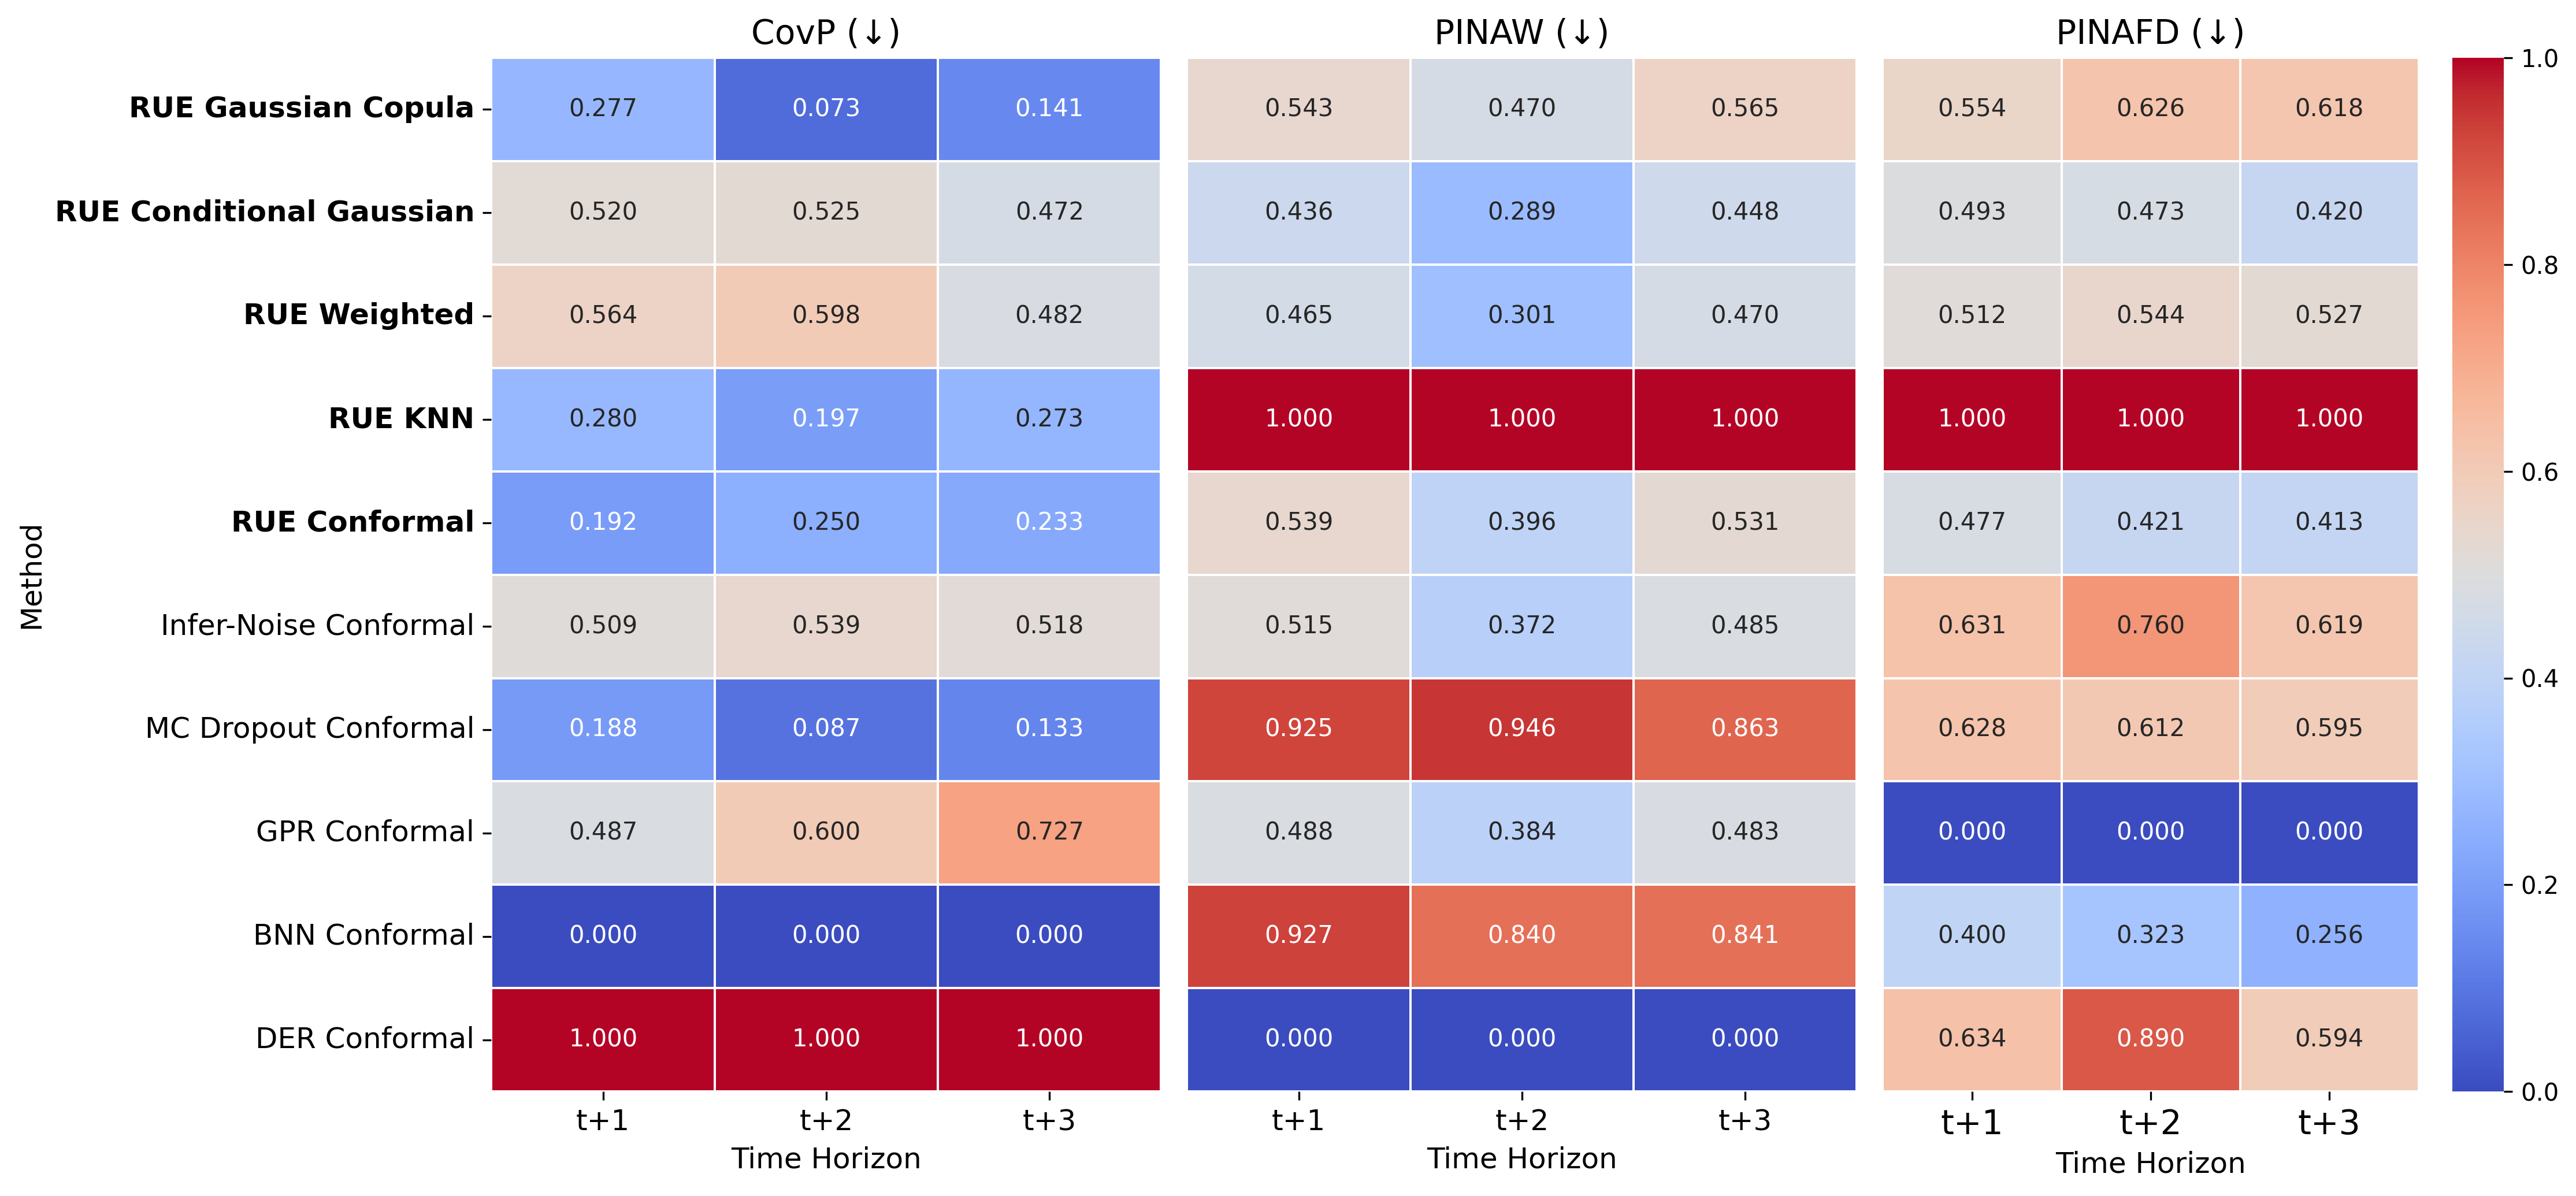

In [20]:
def generate_pi_heatmap(
    seed_list, categories=["CovP", "PINAW", "PINAFD"], methods=None, save_fig=False, filename=None, 
    legend_ncol=5, legend_fs=16, title_fs=16, xlabel_fs=16, ylabel_fs=16, xtick_fs=16, ytick_fs=16,
    width=15, height=6, bold_rue=True
):
    from matplotlib.colors import Normalize
    from matplotlib.font_manager import FontProperties
    df = get_mean_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="pi_perf.csv", index_col=["Time Horizon","Method"]).reset_index()
    df.columns = ["CovP" if col == "CP" else col for col in df.columns]
    if methods:
        df = df[df["Method"].isin(methods)]
    else:
        methods = df["Method"].unique()

    # Define bold font
    bold_font = FontProperties(weight='bold')
    
    df = pd.melt(
        df, 
        id_vars=['Time Horizon', "Method"], 
        value_vars=categories, 
        var_name="Metric", 
        value_name="Value"
    )
    df["Metric"] = df["Metric"].astype(str) + " (↓)"
    
    df["Value"] = np.log(df["Value"])
    df["Value"] = df.groupby(["Metric", "Time Horizon"])["Value"].transform(
        lambda x:  (x - x.min()) / (x.max() - x.min()) # (x - x.mean()) / x.std()
    )
    df = df.sort_values(by=["Metric", "Time Horizon", "Value"])
    vmin, vmax = df["Value"].min(), df["Value"].max()

    # display(df)
    metrics = [col + " (↓)" for col in categories]
    
    # Plot subplots of heatmaps for each metric
    fig, axes = plt.subplots(1, len(metrics), figsize=(width, height), dpi=300) # sharey=True
    
    for i, metric in enumerate(metrics):
        # Filter data for the current metric
        metric_data = df[df["Metric"] == metric]
        
        # display(metric_data)
        heatmap_data = metric_data.pivot_table(
            index="Method", 
            columns="Time Horizon", 
            values="Value"
        )
        heatmap_data = heatmap_data.reindex(methods)
    
        # Create heatmap for the current metric
        sns.heatmap(
            heatmap_data, 
            ax=axes[i], 
            annot=True, 
            fmt=".3f", 
            cmap='coolwarm',  # Use custom colormap
            linewidths=0.5, 
            vmin=vmin, 
            vmax=vmax,  # Ensure the same scale across subplots
            cbar=i == len(metrics) - 1,  # Add a color bar only to the last subplot
            # cbar_kws={"label": "Value"} if i == len(metrics) - 1 else None
        )
       
        axes[i].set_title(metric, size=title_fs)
        axes[i].set_xlabel("Time Horizon", size=xlabel_fs)
        if i != 0:
            axes[i].set_ylabel("")
            axes[i].set_yticks([])
        else:
            axes[i].set_ylabel("Method", size=ylabel_fs)
            for label in axes[i].get_yticklabels():
                if "RUE" in label.get_text():
                    label.set_fontproperties(bold_font)

        axes[i].tick_params(axis='x', labelsize=xtick_fs)
        axes[i].tick_params(axis='y', labelsize=ytick_fs)
        if i == len(metrics)-1:
            axes[i].tick_params(axis="both", labelsize=legend_fs)
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(os.path.join(fp_project_consolidated_results, f"{filename}.jpg"), bbox_inches="tight")
    plt.show()
    
generate_pi_heatmap(
    seed_list, save_fig=True, filename="rue_comparison_heatmap",
    methods=None,
    legend_ncol=3, legend_fs=14,  title_fs=14, xlabel_fs=12, ylabel_fs=12, xtick_fs=12, ytick_fs=12,
    width=15, height=7
)

# generate_pi_heatmap(
#     seed_list, save_fig=False, filename="rue_comparison_heatmap",
#     methods=['RUE Gaussian Copula','RUE Conditional Gaussian','RUE Weighted','RUE KNN', 'RUE Conformal'],
#     legend_ncol=3, legend_fs=14,  title_fs=14, xlabel_fs=12, ylabel_fs=12, xtick_fs=12, ytick_fs=12
# )

# generate_pi_heatmap(
#     seed_list, save_fig=False, filename="rue_comparison_heatmap",
#     methods=['RUE Gaussian Copula','Infer-Noise Conformal','MC Dropout Conformal','GPR Conformal','BNN Conformal','DER Conformal'],
#     legend_ncol=3, legend_fs=14,  title_fs=14, xlabel_fs=12, ylabel_fs=12, xtick_fs=12, ytick_fs=12
# )

In [56]:
pd.melt(pi_perf_df.reset_index(), id_vars=['Time Horizon', "Method"], value_vars=['CP', "PINAW", "CWFDC"], var_name="Metric")

Time Horizon                    Method Metric               value
0           t+1       RUE Gaussian Copula     CP     0.00131 ± 0.001
1           t+1  RUE Conditional Gaussian     CP     0.00827 ± 0.004
2           t+1              RUE Weighted     CP     0.01149 ± 0.006
3           t+1                   RUE KNN     CP     0.00134 ± 0.000
4           t+1             RUE Conformal     CP     0.00069 ± 0.000
..          ...                       ...    ...                 ...
85          t+3     Infer-Noise Conformal  CWFDC     7.86863 ± 0.930
86          t+3      MC Dropout Conformal  CWFDC     0.53881 ± 0.110
87          t+3             GPR Conformal  CWFDC     36.6528 ± 1.312
88          t+3             BNN Conformal  CWFDC     0.24779 ± 0.137
89          t+3             DER Conformal  CWFDC  276.96473 ± 83.354

[90 rows x 4 columns]

In [54]:
heatmap_data

Interval   Interval 1  Interval 2  Interval 3
Method                                       
Method 1     0.058084    0.866176    0.601115
Method 10    0.637557    0.887213    0.472215
Method 2     0.183405    0.304242    0.524756
Method 3     0.456070    0.785176    0.199674
Method 4     0.948886    0.965632    0.808397
Method 5     0.034389    0.909320    0.258780
Method 6     0.775133    0.939499    0.894827
Method 7     0.388677    0.271349    0.828738
Method 8     0.986887    0.772245    0.198716
Method 9     0.358466    0.115869    0.863103

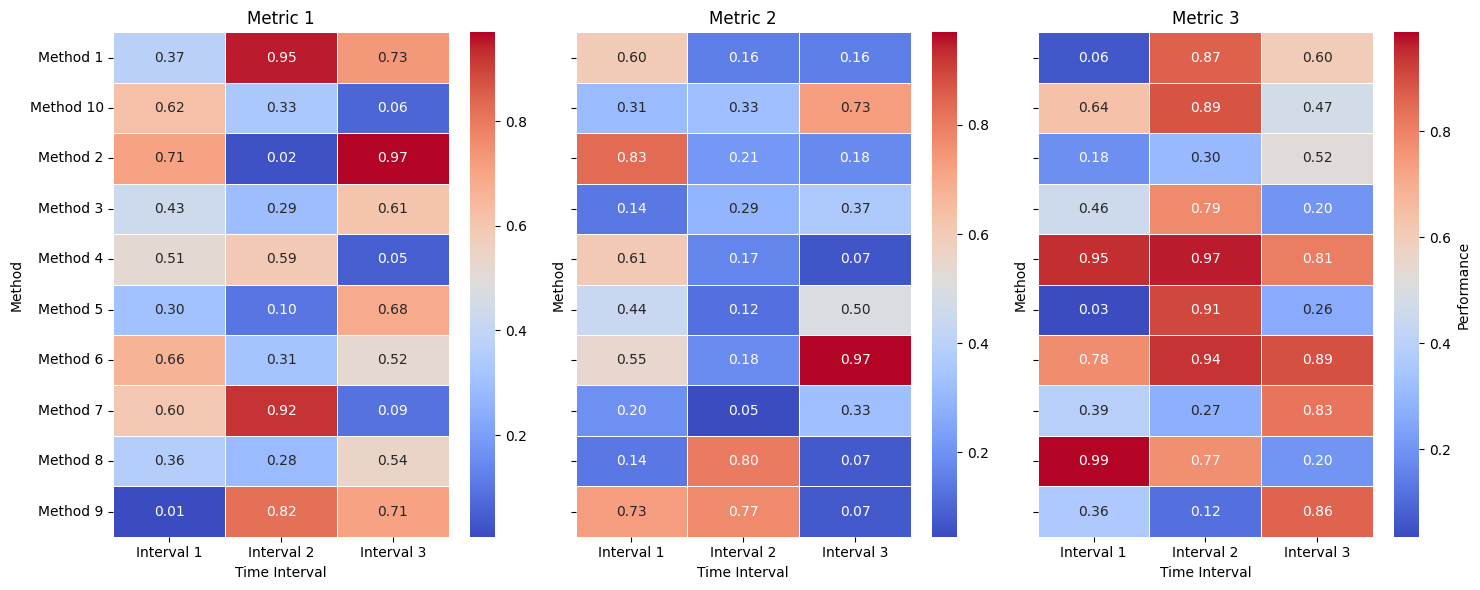

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate sample data (10 methods, 3 metrics, 3 time intervals)
methods = [f"Method {i+1}" for i in range(10)]
metrics = ["Metric 1", "Metric 2", "Metric 3"]
time_intervals = ["Interval 1", "Interval 2", "Interval 3"]

# Create random data for demonstration
np.random.seed(42)
data = np.random.rand(10, 3, 3)  # 10 methods, 3 metrics, 3 time intervals

# Flatten the data into a DataFrame for heatmap preparation
data_flat = []
for method_idx, method in enumerate(methods):
    for metric_idx, metric in enumerate(metrics):
        for time_idx, interval in enumerate(time_intervals):
            data_flat.append([method, metric, interval, data[method_idx, metric_idx, time_idx]])

df = pd.DataFrame(data_flat, columns=["Method", "Metric", "Interval", "Performance"])

# Plot subplots of heatmaps for each metric
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 6), sharey=True)

for i, metric in enumerate(metrics):
    # Filter data for the current metric
    metric_data = df[df["Metric"] == metric]
    heatmap_data = metric_data.pivot_table(
        index="Method", 
        columns="Interval", 
        values="Performance"
    )

    # Create heatmap for the current metric
    sns.heatmap(
        heatmap_data, 
        ax=axes[i], 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        linewidths=0.5, 
        cbar_kws={"label": "Performance"} if i == len(metrics) - 1 else None
    )
    axes[i].set_title(metric)
    axes[i].set_xlabel("Time Interval")
    if i == 0:
        axes[i].set_ylabel("Method")

plt.tight_layout()
plt.show()


In [ ]:
def plot_pi_mean_metrics_parallel_coordinate(
    seed_list, categories=["CovP", "PINAW", "PINAFD"], methods=None, save_fig=False, filename=None, 
    legend_ncol=5, legend_fs=16, title_fs=16, xlabel_fs=16
):
    from matplotlib import cm
    from matplotlib.colors import rgb2hex
    import seaborn as sns

    pi_stats = get_mean_of_all_seed_csvs(seed_list, fp_project_model_evaluations, filename="pi_perf.csv", index_col=["Time Horizon","Method"]).reset_index()
    
    pi_stats = pi_stats.copy().sort_values(by=["Time Horizon", "Method"])
    num_cat = len(categories)
    
    rue_colors = sns.color_palette('spring', n_colors=4)
    other_colors = sns.color_palette('winter', n_colors=3)
    color_list = sns.color_palette('rainbow', n_colors=pi_stats["Method"].nunique())

    fig, axes = plt.subplots(1, num_cat, sharey=True, dpi=300, figsize=(num_cat*3, 3))
    xticks = range(num_cat)

    if methods is None:
        methods = pi_states.index.unique(level="Method").to_list()
    
    for i, (time_horizon_label, time_df) in enumerate(pi_stats.groupby("Time Horizon")):
        if methods is not None:
            time_df = time_df[time_df["Method"].isin(methods)]
        minimum, maximum = time_df.loc[:,categories].min(), time_df.loc[:,categories].max()
        time_df.loc[:,categories] = (time_df[categories]-minimum)/(maximum-minimum)
        for j, method_label in enumerate(methods):
            method_df = time_df[time_df["Method"]==method_label]
        # for j, (method_label, method_df) in enumerate(time_df.groupby("Method")):
            # print(method_df[categories].values.flatten())
            axes[i].plot(xticks, method_df[categories].values.flatten(), label=method_label if i==0 else None, linestyle="--" if ("RUE" not in method_label) or ("Conformal" in method_label) else "-")
            axes[i].set_xticks(xticks, categories, fontsize=xlabel_fs)
        axes[i].set_title(time_horizon_label, fontsize=title_fs)

    reorder=lambda hl,nc:(sum((lis[i::nc]for i in range(nc)),[])for lis in hl)
    h_l = axes[0].get_legend_handles_labels()
    fig.legend(*reorder(h_l, 5), loc='upper center', bbox_to_anchor=(0.5, 0), ncol=legend_ncol, fontsize=legend_fs)
    plt.tight_layout()
    if save_fig:
        plt.savefig(os.path.join(fp_project_consolidated_results, f"{filename}.jpg"), bbox_inches="tight")

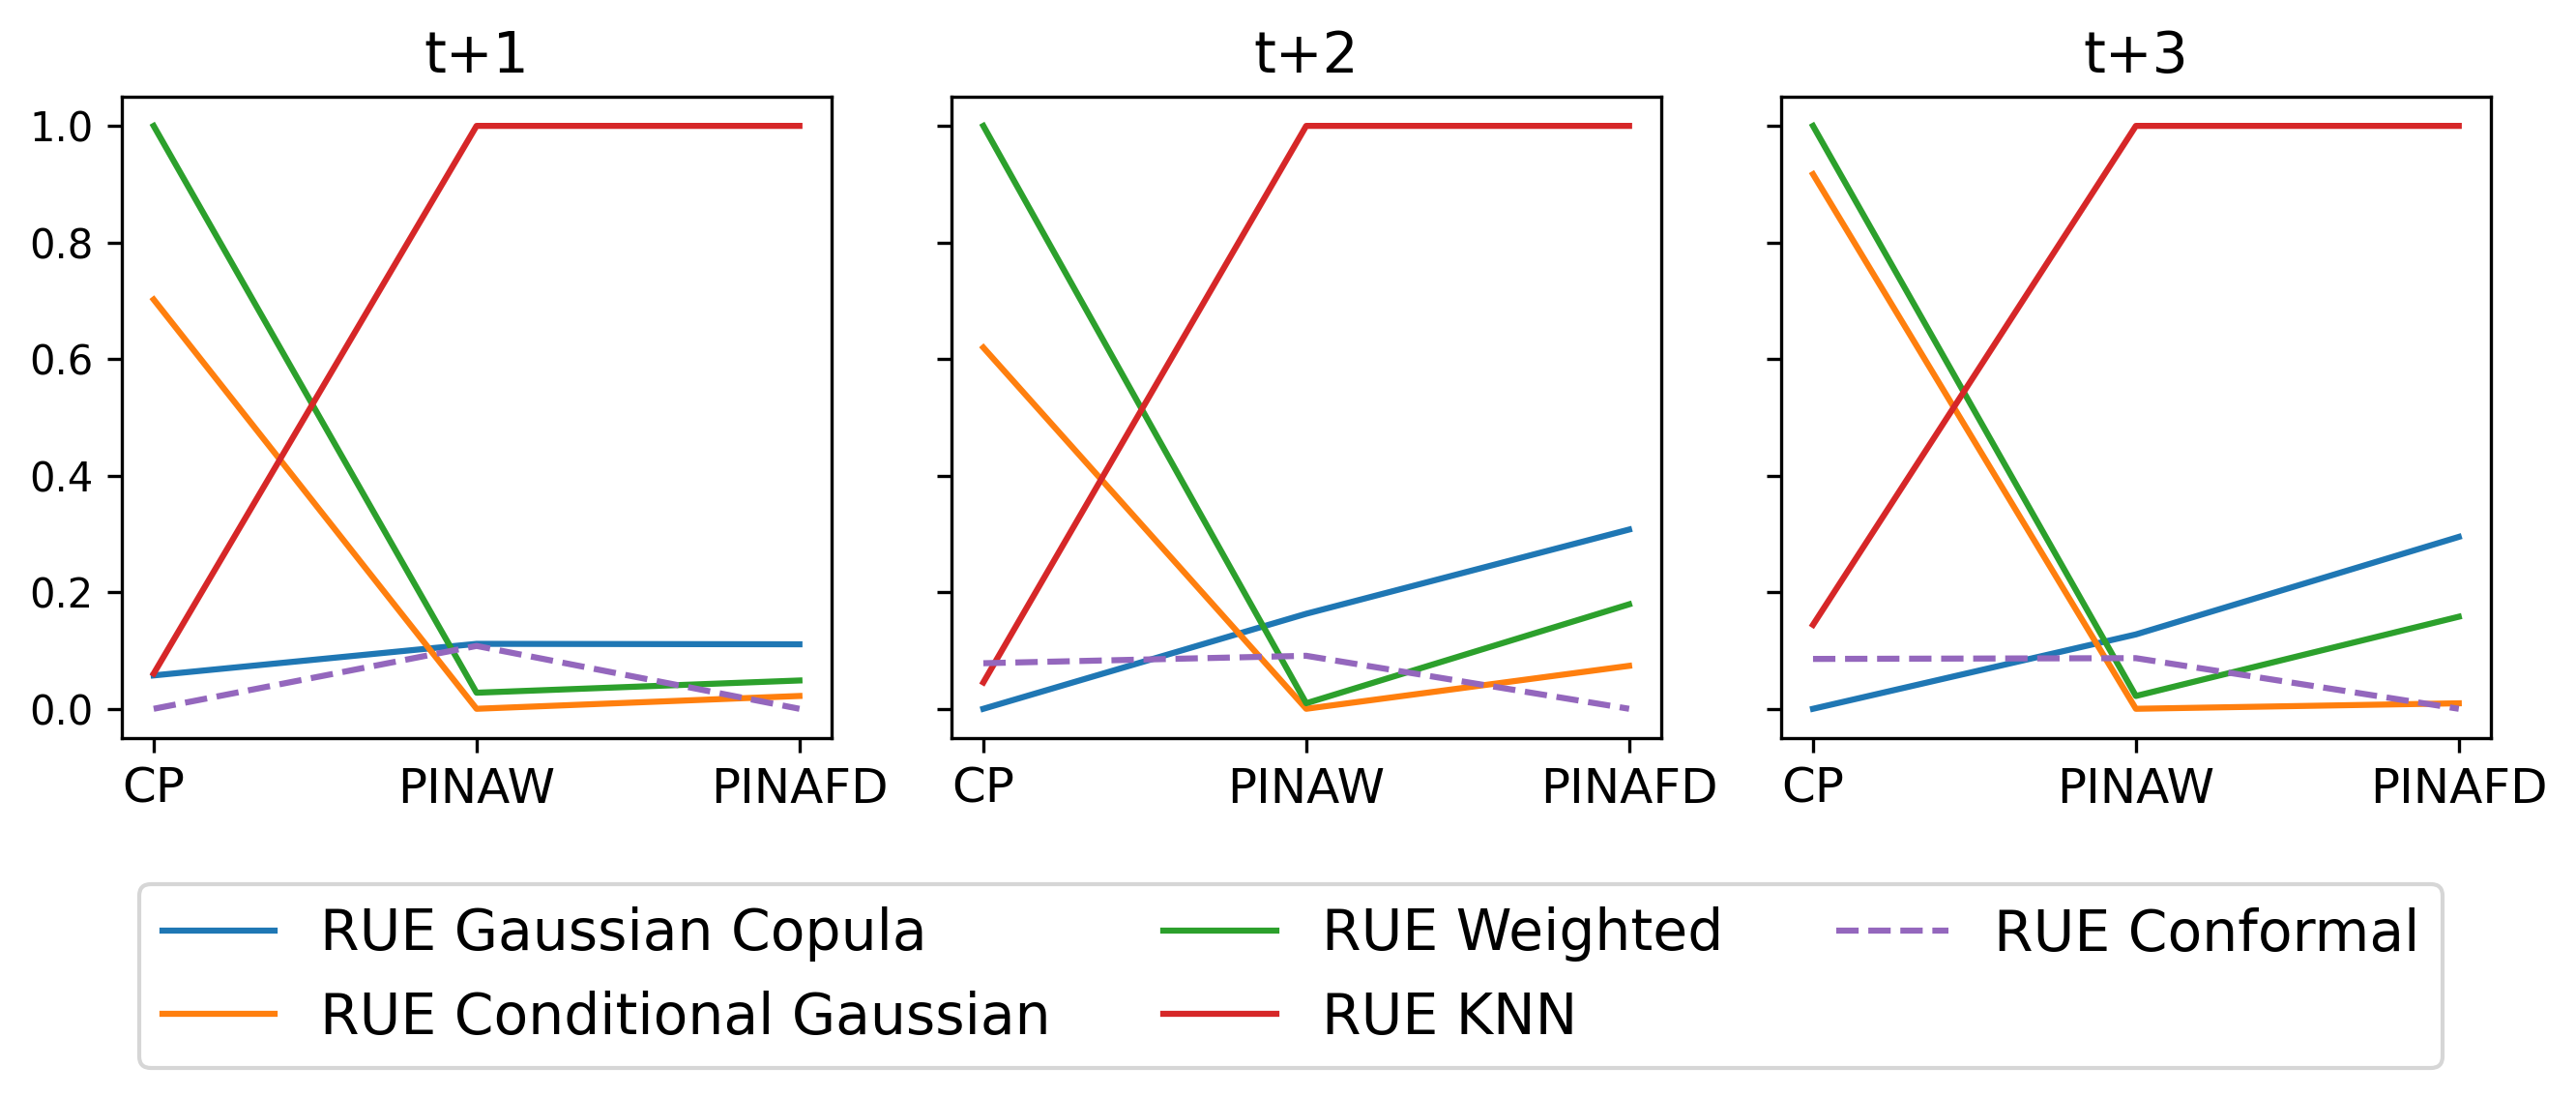

In [19]:
plot_pi_mean_metrics_parallel_coordinate(
    seed_list, save_fig=True, filename="rue_comparison_parallel_coord",
    methods=['RUE Gaussian Copula','RUE Conditional Gaussian','RUE Weighted','RUE KNN', 'RUE Conformal'],
    legend_ncol=3, legend_fs=14,  title_fs=14, xlabel_fs=12
)

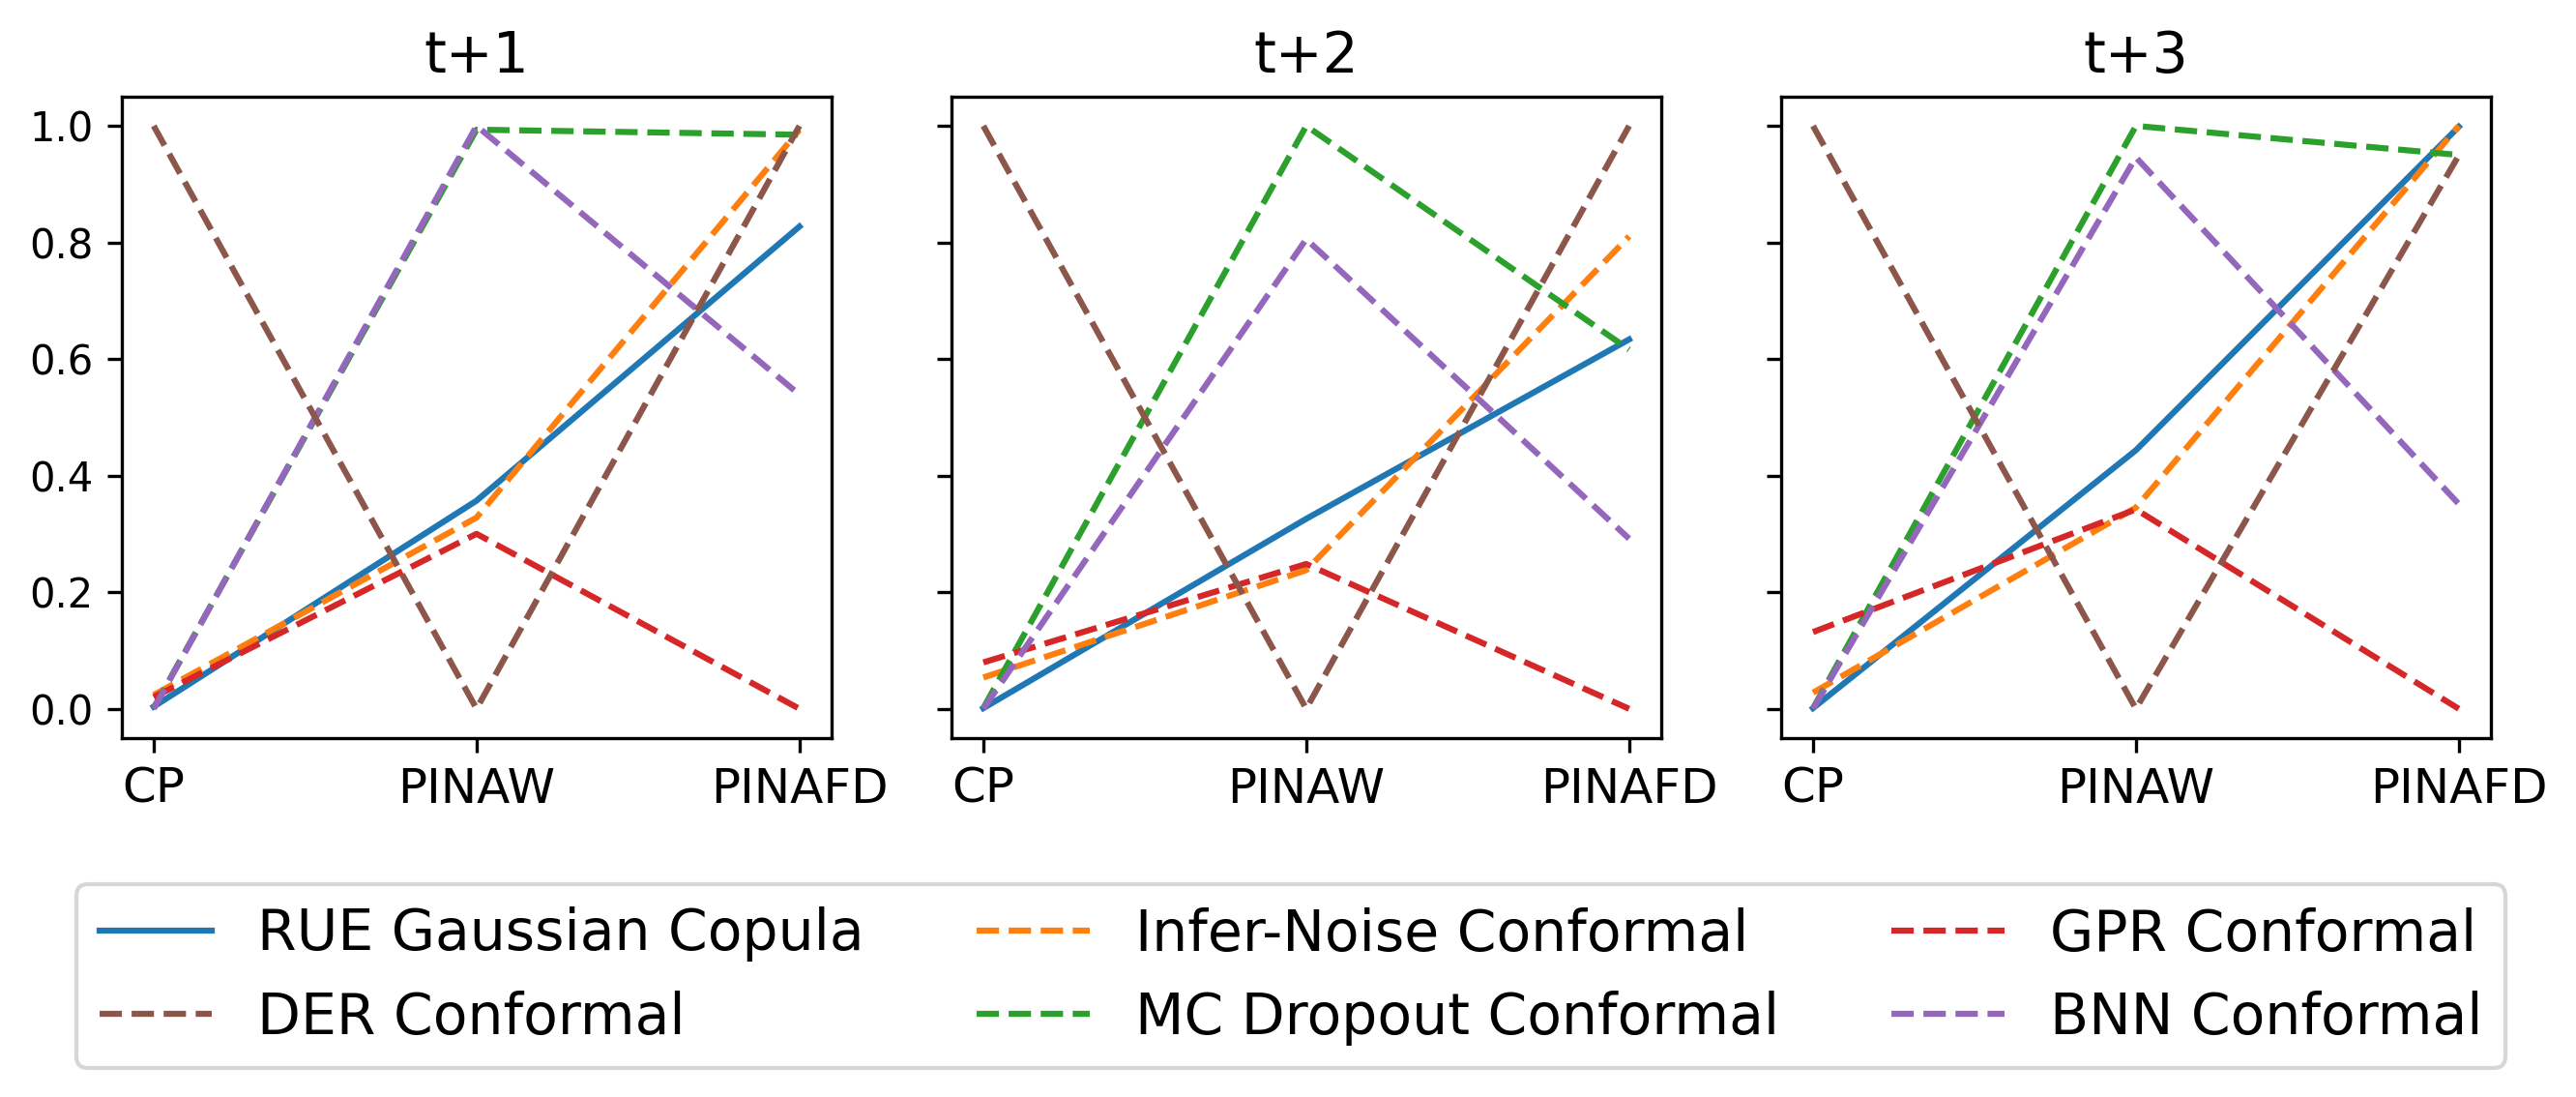

In [20]:
plot_pi_mean_metrics_parallel_coordinate(
    seed_list, save_fig=True, filename="rue_v_rest_comparison_parallel_coord",
    methods=['RUE Gaussian Copula','Infer-Noise Conformal','MC Dropout Conformal','GPR Conformal','BNN Conformal','DER Conformal'],
    legend_ncol=3, legend_fs=14,  title_fs=14, xlabel_fs=12
)

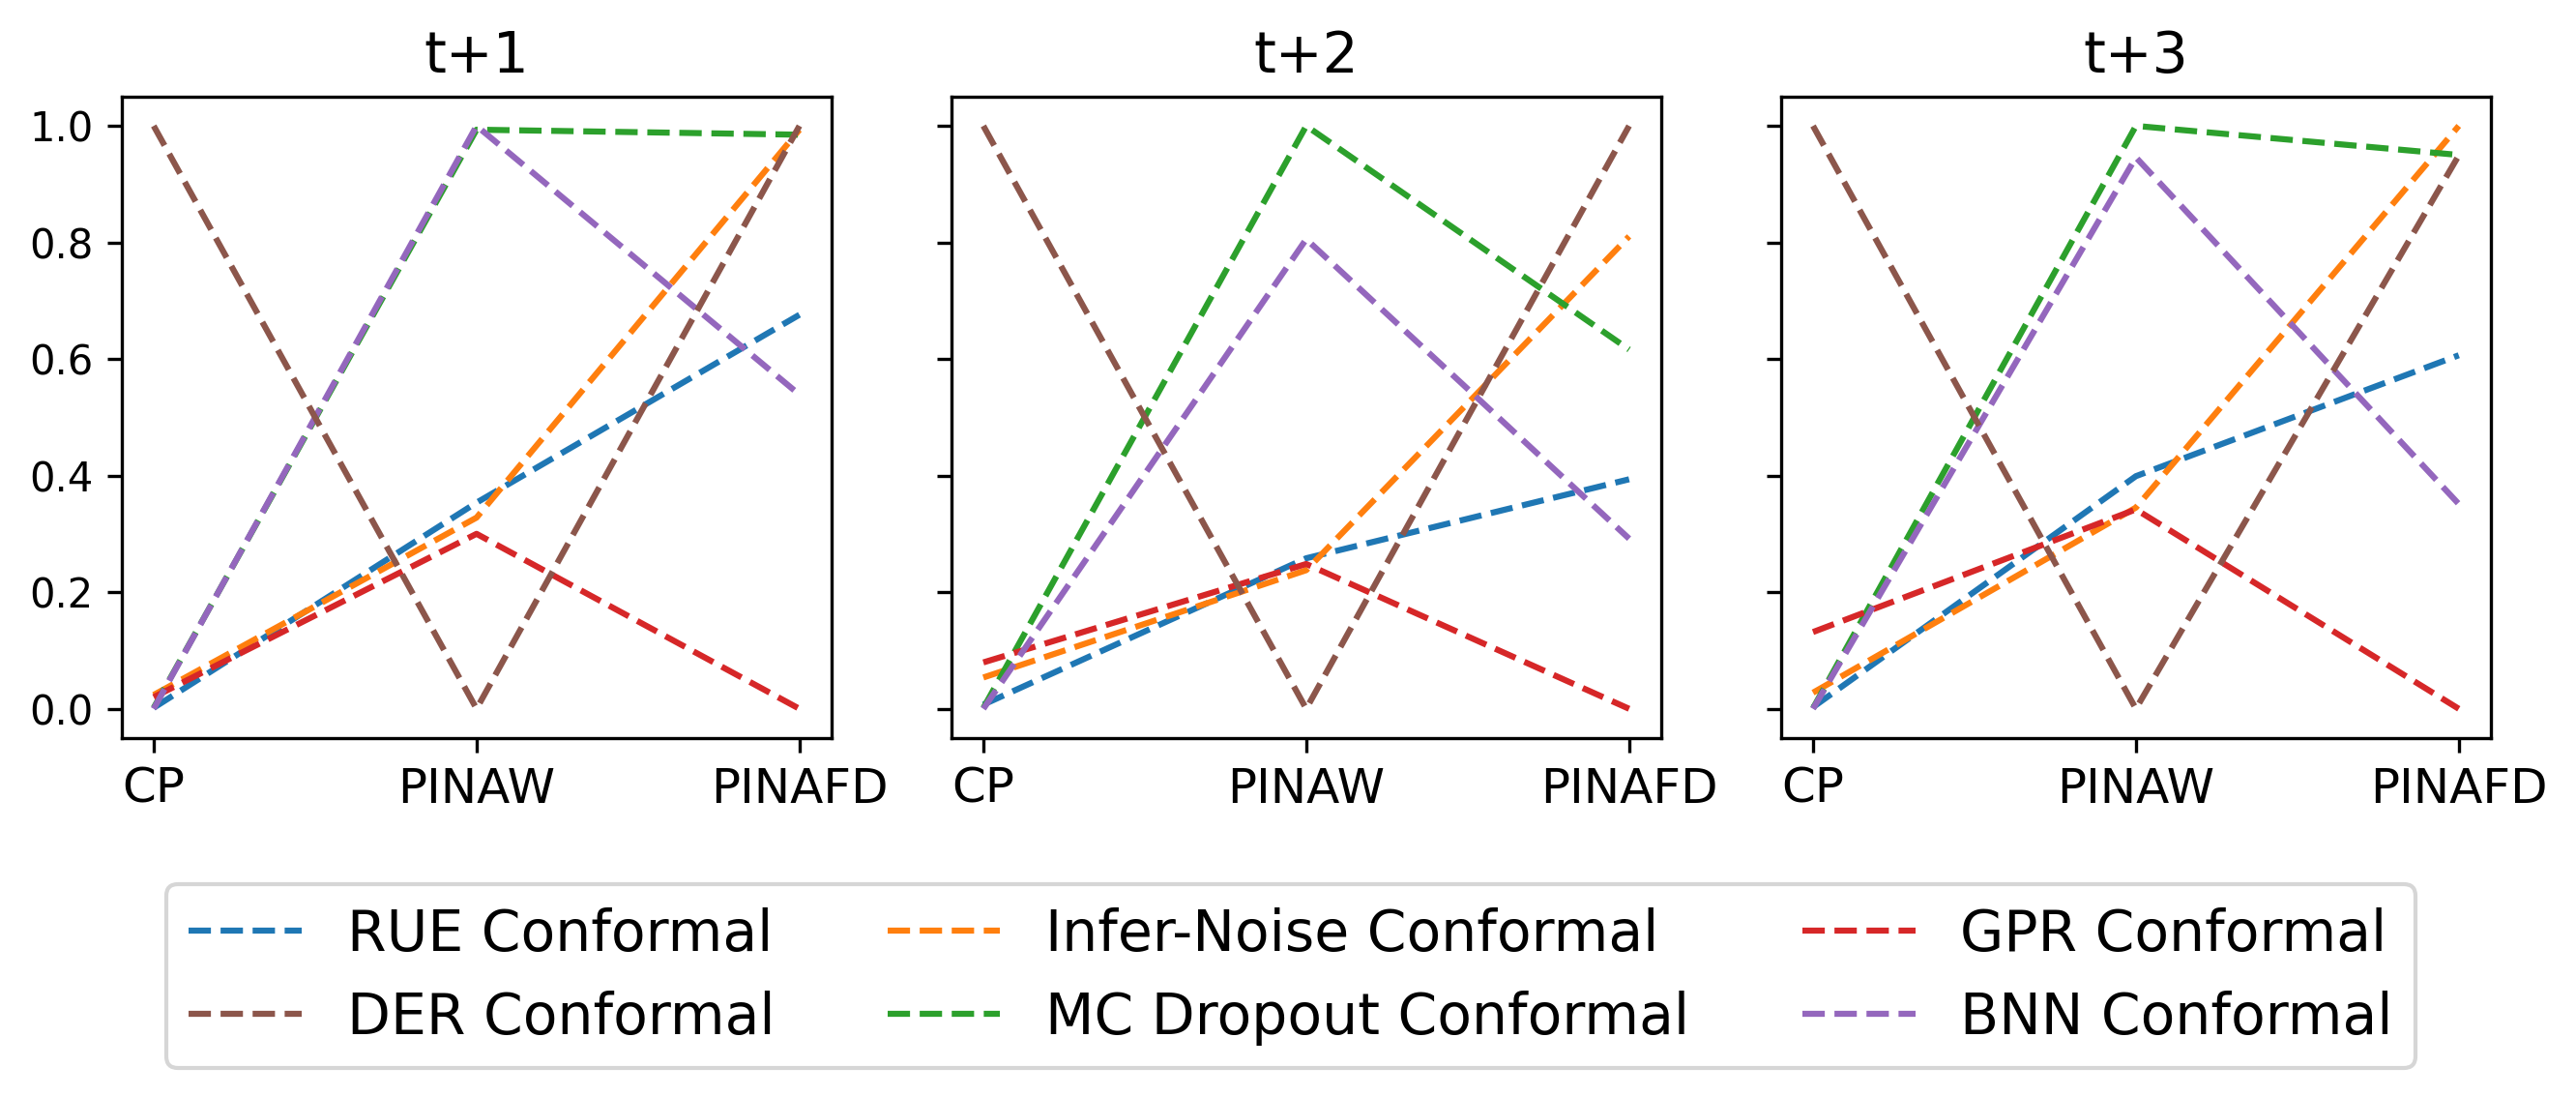

In [24]:
plot_pi_mean_metrics_parallel_coordinate(
    seed_list, save_fig=False, filename="rue_v_rest_comparison_parallel_coord",
    methods=['RUE Conformal','Infer-Noise Conformal','MC Dropout Conformal','GPR Conformal','BNN Conformal','DER Conformal'],
    legend_ncol=3, legend_fs=14,  title_fs=14, xlabel_fs=12
)

#### Runtime

In [125]:
def analyse_runtime():
    categories = ["Training", "Predicting", "PI"]
    time_df = pd.read_csv(fp_time_log, header=None)
    time_df.columns = ["Seed", "Description", "Time/s"]
    time_df = time_df.drop_duplicates(keep="last")
    time_series = time_df.groupby(by=["Description"])["Time/s"].mean()
    category_values = [category for op in time_series.index for category in categories if category in op]
    output_df = pd.DataFrame({"Category": category_values, "Operation":time_series.index, "Time/s": time_series.values})
    return output_df.sort_values(by=["Category", "Time/s"]).set_index(["Category", "Operation"])

runtime_df = analyse_runtime()
display(runtime_df)
runtime_df.to_csv(os.path.join(fp_project_consolidated_results, "runtime.csv"))

Time/s
Category   Operation                                       
PI         Conformal PI                            0.000617
           Conditional PI                          0.004386
           KNN PI                                  0.009464
           Copula PI                               0.032110
           Weighted PI                             0.101408
Predicting Predicting with DER                     0.002333
           Predicting with Decoder + Predictor     0.009925
           Predicting with GPR                     0.028449
           Predicting with Infer-Noise             0.031605
           Predicting with MC Dropout              0.051966
           Predicting with BNN                     7.784830
Training   Training Encoder and Predictor          7.658443
           Training Decoder                       10.645309
           Training GPR                           88.471155
           Training DER                          149.622003
           Training BNN                         1329.463078